In [1]:
#Made by: Leonardo Sole Luigi Scotto Rosato
#From: University of naples Federico II

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import networkx as nx
import matplotlib.pyplot as plt
import math
import time
import seaborn as sns
import pandas as pd
import os

# Dati del problema

- Origine (o deposito) $v_1$
- Destinazioni (o clienti) {$v_2$,$v_3$,...,$v_n$} che devono essere serviti a partire da $v_1$
- Grafo orientato G(V,A) con:
  V = {$v_2$,$v_3$,...,$v_n$} insieme di nodi
  A = Insieme di archi del grafo
- Costo $C_ij$ definito per ciascun arco (i,j) € A 
- Ogni destinazione $V_i$ ($i\neq 1$) con una domanda $d_i$>=0
- Per effettuare le consegne è disponibile una flotta di m veicoli ciascuno con una portata massima $Q_i, i=1,2,...,m$

# Funzione obiettivo

Sia $𝑻={𝑇_1,𝑇_2,…,𝑇_𝑚}$ una generica soluzione ammissibile
Sia $L(𝑇_𝑘)$ somma dei costi di transito associati agli archi del ciclo hamiltoniano $𝑇_𝑘$

Il valore della funzione obiettivo (costo totale) è dato da:
$Z(T)=$$\sum_{k=1}^{m} L(T_k)$


# Varianti del problema trattate

- Tipo di operazione: Prelievo
- Numero di automezzi: Fissato a priori
- Tipo di automezzi: Stessa portata
- Numero di depositi: Singolo
- Funzione obiettivo: Distanza percorsa

# Formulazione matematica

- Costi totali di trasporto -> $min$$\sum_{i=1}^{n}$$\sum_{j=1}^{n} c_ij x_ij$
- Se un veicolo entra in i deve anche uscirne -> $\sum_{j=1}^{n} x_ij$ = $\sum_{j=1}^{n} x_ji $ $i€{1,2,...n}$
- Dal deposito devono uscire m veicoli -> $\sum_{j=2}^{n} x_1j = m$
- Ogni cliente deve essere servito da un unico camion -> $\sum_{j=1}^{n} x_ij = 1$
- Quando il camion parte dal deposito non ha ancora servito nessuna domanda -> $u_1 = 0$
- Quando il camion arriva al cliente i, la domanda totale servita deve essere minore della sua capacità -> $u_i <= Q i€V $
- $𝑢_𝑗−𝑢_𝑖≥𝑑_𝑗 𝑥_𝑖𝑗−𝑄(1−𝑥_𝑖𝑗 )  𝑖,𝑗∈𝑉,𝑖≠𝑗,𝑗≠1$
- $x_ij € (0,1)    𝑖,𝑗∈(1,2,…,𝑛) $

In [2]:
directory = "Istanza_A/"
estensione = ".vrp"
estensione_sol = ".sol"

# Liste per salvare i nomi dei file:
nomi_file = [] #File delle istanze
nomi_sol = []  #File delle soluzioni

# Scansione dei file istanze nella directory
for filename in os.listdir(directory):
    if filename.endswith(estensione):
        # Aggiungi il nome del file alla lista
        nomi_file.append(filename)

# Scansione dei file solouzioni nella directory
for filename in os.listdir(directory):
    if filename.endswith(estensione_sol):
        # Aggiungi il nome del file alla lista
        nomi_sol.append(filename)

# # Stampa dei nomi dei file
print(nomi_file)
print("-----------------------------------")
print(nomi_sol)

['A-n32-k5.vrp', 'A-n33-k5.vrp', 'A-n33-k6.vrp', 'A-n34-k5.vrp', 'A-n36-k5.vrp', 'A-n37-k5.vrp', 'A-n37-k6.vrp', 'A-n38-k5.vrp', 'A-n39-k5.vrp', 'A-n39-k6.vrp', 'A-n44-k6.vrp', 'A-n45-k6.vrp', 'A-n45-k7.vrp', 'A-n46-k7.vrp', 'A-n48-k7.vrp', 'A-n53-k7.vrp', 'A-n54-k7.vrp', 'A-n55-k9.vrp', 'A-n60-k9.vrp', 'A-n61-k9.vrp', 'A-n62-k8.vrp', 'A-n63-k10.vrp', 'A-n63-k9.vrp', 'A-n64-k9.vrp', 'A-n65-k9.vrp', 'A-n69-k9.vrp', 'A-n80-k10.vrp']
-----------------------------------
['A-n32-k5.sol', 'A-n33-k5.sol', 'A-n33-k6.sol', 'A-n34-k5.sol', 'A-n36-k5.sol', 'A-n37-k5.sol', 'A-n37-k6.sol', 'A-n38-k5.sol', 'A-n39-k5.sol', 'A-n39-k6.sol', 'A-n44-k6.sol', 'A-n45-k6.sol', 'A-n45-k7.sol', 'A-n46-k7.sol', 'A-n48-k7.sol', 'A-n53-k7.sol', 'A-n54-k7.sol', 'A-n55-k9.sol', 'A-n60-k9.sol', 'A-n61-k9.sol', 'A-n62-k8.sol', 'A-n63-k10.sol', 'A-n63-k9.sol', 'A-n64-k9.sol', 'A-n65-k9.sol', 'A-n69-k9.sol', 'A-n80-k10.sol']


# Funzione per leggere all'interno di un file .vrp, andrà a leggerne le righe e a salvarne i valori:

In [3]:
def read_file(nome_file):
    directory="Istanza_A/"
    file_path = directory + nome_file 
    #Utilizzo di variabili globali per modificarle anche all'interno del main senza passarle come parametri
    global capacity
    global node_coord_section
    global demand_section
    global depot_section
    global num_vehicl
    
    # Flag per determinare quando leggere i dati della sezione "DEMAND_SECTION"
    read_demand = False

    # Flag per determinare quando leggere i dati della sezione "DEPOT_SECTION"
    read_depot = False

    # Leggi il file e analizza le righe
    with open(file_path, "r") as file:
        #loop che itera su ogni riga del file.
        for line in file:
            #Rimozione spazi bianchi iniziali e finali
            line = line.strip()
            if line.startswith("COMMENT"):
                comment_line = line
            #Se la riga inizia con CAPACITY, mettiamo nelle capacità
            elif line.startswith("CAPACITY"):
                _, capacity = line.split(":")
                #Conversione del valore in intero
                capacity = int(capacity.strip())
            elif line.startswith("NODE_COORD_SECTION"):
                # Leggi le coordinate dei nodi fino alla sezione DEMAND_SECTION
                for line in file:
                    line = line.strip()
                    if line == "DEMAND_SECTION":
                        read_demand = True
                        break
                    node_id, x, y = map(int, line.split())
                    node_coord_section.append((node_id, x, y))
            elif read_demand:
                if line == "DEPOT_SECTION":
                    # Fine della sezione DEMAND_SECTION, inizia la sezione DEPOT_SECTION
                    read_demand = False
                    read_depot = True
                else:
                    #estrae il node_id e la demand dalla riga corrente e li assegna alle rispettive variabili.
                    node_id, demand = map(int, line.split())
                    demand_section.append((node_id, demand))
            elif read_depot:
                if line == "EOF":
                    # Fine della sezione DEPOT_SECTION
                    read_depot = False
                else:
                    depot_id = int(line)
                    depot_section.append(depot_id)
    # Estrai il valore di "No of trucks" dalla linea COMMENT
    start_index = comment_line.find("No of trucks:") + len("No of trucks:")
    end_index = comment_line.find(",", start_index)
    num_vehicl = int(comment_line[start_index:end_index].strip())

# Funzione per plottare l'istanza del problema, mostrando i nodi in base alle coordinate

In [4]:
def instance_plot(nome_file):
    # Estrarre le coordinate dei nodi dal Node Coord Section
    node_coord = [(x, y) for _, x, y in node_coord_section]

    # Crea una figura e un grafico
    fig, ax = plt.subplots()

    # Plotta i punti dei nodi come puntini blu
    ax.scatter(*zip(*node_coord), color='blue')

    # Identifica il nodo 1 e plottalo come un puntino rosso
    node_1_coord = node_coord[0]
    ax.scatter(*node_1_coord, color='red')

    # Aggiungi etichette ai punti dei nodi
    for i, (x, y) in enumerate(node_coord):
        ax.annotate(str(i+1), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

    # Imposta i limiti dell'asse x e y
    ax.set_xlim(0, 105)
    ax.set_ylim(0, 105)

    #Nome sugli assi
    plt.xlabel('latitude')
    plt.ylabel('longitude')
    plt.grid()
    #titolo
    plt.title(nome_file)
    # Mostra il grafico
    plt.show()

# Funzioni di creazione strutture dati per il problema

In [5]:
def calculate_distance(x1, y1, x2, y2):
    #Calcola la distanza euclidea tra due punti nel piano.
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    #return round(distance,2) #Arrotondo i risultati a due cifre decimali
    return round(distance) #Arrotondo i risultati a intero

#Crea la matrice delle distanze basata sulle coordinate dei nodi.
def create_distance_matrix(node_coord_section):
    #Calcolo la dimensione
    num_nodes = len(node_coord_section)
    #Inizializzo la matrice a 0, in modo quadrato num_nodes x num_nodes
    distance_matrix = [[0] * num_nodes for _ in range(num_nodes)]
    
    #scorre su tutti i nodi nella lista node_coord_section
    for i in range(num_nodes):
        #Estraggo le coordinate del punto di partenza
        x1, y1 = node_coord_section[i][1], node_coord_section[i][2]
        for j in range(num_nodes):
            #Estraggo le coordinate degli altri punti
            x2, y2 = node_coord_section[j][1], node_coord_section[j][2]
            #Calcolo la distanza euclidea
            distance = calculate_distance(x1, y1, x2, y2)
            distance_matrix[i][j] = distance

    return distance_matrix

In [6]:
#Creo il modello per il problema
def create_data_model(distance_matrix, demand_section, capacity, num_vehicl):
    #crea un dizionario vuoto
    data = {}
    demand_data= [] #Lista per richieste di carico
    #Itero sulle richieste contenute in demand_section
    for item in demand_section:
        #Assegno i valori, l'indice 0 contiene id nodo, indice 1 la richiesta
        #Prendo solo la richiesta
        demand_data.append(item[1])
    data['distance_matrix'] = distance_matrix
    data['demands'] = demand_data
    data['vehicle_capacities'] = [capacity]* num_vehicl
    data['num_vehicles'] = num_vehicl
    data['depot'] = 0
    return data

#debug
# data= create_data_model(distance_matrix,demand_section,capacity,num_vehicl)
# for row in data['distance_matrix']:
#     print(row)
# print("Demands:")
# print(data['demands'])
# print("Vehicle Capacities:")
# print(data['vehicle_capacities'])
# print("Number of Vehicles:")
# print(data['num_vehicles'])
# print("Depot:")
# print(data['depot'])

# Stampa della soluzione in formato testuale

In [7]:
def print_solution(data, manager, routing, solution, execution_time):
    #Stampa dell'obiettivo di soluzione
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        # Ottiene l'indice del nodo di partenza del veicolo
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id+1)
        route_distance = 0
        route_load = 0
        # Itera finché non raggiunge il nodo finale del veicolo
        while not routing.IsEnd(index):
            # Converte l'indice del nodo in un identificatore del nodo
            node_index = manager.IndexToNode(index)
            # Aggiorna il carico attuale del veicolo dopo essere passato per il nodo
            route_load += data['demands'][node_index]
            
            plan_output += ' {0} Load({1}) -> '.format(node_index+1, route_load)
            # Salva l'indice precedente
            previous_index = index
            # Ottiene l'indice del prossimo nodo nella soluzione
            index = solution.Value(routing.NextVar(index))
             # Aggiorna la distanza del percorso
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        # Stampa il piano di percorso del veicolo
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    # Stampa la distanza totale di tutti i percorsi e il carico totale    
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))
    print('Total Execution Time: {}s'.format(execution_time))
    return total_distance

# Funzione di plot su grafico della soluzione

In [8]:
def get_routes_from_solution(nome_file,solution,FS,LSM):
    # Ottenere tutte le route dalla soluzione
    routes=[]
    #Itera su ciascun veicolo e ottiene la sequenza dei nodi visitati
    for vehicle_id in range(data['num_vehicles']):
        route = []
        index = routing.Start(vehicle_id)
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(node)
            index = solution.Value(routing.NextVar(index))
        #Salvo tutto in routes
        routes.append(route)


    # Estrarre le coordinate dei nodi dal Node Coord Section
    node_coord = [(x, y) for _, x, y in node_coord_section]

    # Crea una figura e un grafico
    fig, ax = plt.subplots()

    # Plotta i punti dei nodi come puntini blu
    ax.scatter(*zip(*node_coord), color='blue')

    # Identifica il nodo 1 e plottalo come un puntino rosso
    node_1_coord = node_coord[0]
    ax.scatter(*node_1_coord, color='red')

    # Aggiungi etichette ai punti dei nodi
    for i, (x, y) in enumerate(node_coord):
        ax.annotate(str(i+1), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

    # Lista dei colori per le route
    colors = ['green', 'red', 'blue', 'orange', 'purple']

    # Plotta le route come collegamenti tra i nodi
    for i, route in enumerate(routes):
        # Estrae le coordinate dei nodi nella route
        route_coords = [node_coord[node_id] for node_id in route]

        # Aggiungi il nodo di partenza come ultimo punto nella lista delle coordinate
        route_coords.append(node_coord[0])

        # Seleziona il colore corrispondente alla route
        color = colors[i % len(colors)]

        # Plotta la route come linea
        line, = ax.plot(*zip(*route_coords), color=color)
        line.set_label(f'Route {i+1}')  # Imposta l'etichetta per la linea

    #titolo Grafico
    titolo="Instance "+ nome_file+ " / Solved:"+FS + " & " + LSM
    plt.title(titolo)
        
    # Imposta i limiti dell'asse x e y
    ax.set_xlim(0, 105)
    ax.set_ylim(0, 105)

    #Nome sugli assi
    plt.xlabel('latitude')
    plt.ylabel('longitude')
    
    #Sfondo griglia
    plt.grid()
    
    #Legenda per le route
    plt.legend(loc='upper right', fontsize= 8)
    
    # Mostra il grafico
    plt.show()

In [9]:
#Funzione che acquisice qualsiasi coppia di località e restituisca la distanza tra loro.
#Utilizza la matrice delle distanze pre calcolata prima
def distance_callback(from_index, to_index):
    #Conversione degli indici dei nodi in indici della matrice.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    #Una volta diventati indici della matrice, posso accedere ai loro valori
    return data['distance_matrix'][from_node][to_node]

#Acquisisce il nodo in input e restituisce la domanda associata
def demand_callback(from_index):
    #Conversione dell'indice come indice del dizionario 
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

def apply_euristic(FS, LSM, time_limit=2):
    #Inizializza parametri di ricerca
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    #Imposta il metodo euristico per trovare la prima soluzione
    search_parameters.first_solution_strategy = getattr(routing_enums_pb2.FirstSolutionStrategy, FS)
    #Imposta la metaeuristica di ricerca locale
    search_parameters.local_search_metaheuristic = getattr(routing_enums_pb2.LocalSearchMetaheuristic, LSM)
    #Limite di tempo della funzione
    search_parameters.time_limit.FromSeconds(time_limit)

    return search_parameters

# search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)


def solve_routing_problem(nome_file,FS,LSM):
    #INIZIO TEMPO CALCOLO
    start_time = time.time()
    
    #Applica i parametri scelti
    search_parameters = apply_euristic(FS, LSM)

    # Risolve il problema con i parametri settati dalla funzione.
    solution = routing.SolveWithParameters(search_parameters)

    end_time = time.time()
    execution_time = end_time - start_time
    #FINE TEMPO CALCOLO
    
    
    # Stampa la soluzione in formato testo.
    if solution:
        total_distance = print_solution(data, manager, routing, solution,execution_time)
        
    #debug
    #print("DEBUG PROVA:", total_distance)

    #Plotto le route della soluzione sul grafico
    get_routes_from_solution(nome_file,solution,FS,LSM)
    result=(total_distance, execution_time,FS,LSM)
    #Salvo la tupla della soluzione
    sol.append(result)

# Funzione di lettura file di soluzioni

In [10]:
sol_opt = 0
def read_sol(nome_file):
    global sol_opt
    directory="Istanza_A/"
    file_path = directory + nome_file 
    # Leggi il file e analizza le righe
    with open(file_path, "r") as file:
        for line in file:
            line = line.strip()
            if line.startswith("Cost"):
                sol_opt = int(''.join(filter(str.isdigit, line)))
                break
        

# Valutazione del gap per ogni algoritmo

In [11]:
gap = []
def calc_gap(sol_opt):
    #global gap
    print("Soluzione ottima:",sol_opt)
    for ris in sol:
        print("Algoritmo utilizzato:",ris[2])
        print("Opzione di ricerca locale:",ris[3])
        print("Soluzione:",ris[0])
        local_gap=abs((sol_opt - ris[0] )) / abs(sol_opt) * 100
        gap.append(local_gap)
        print(f"Gap: {local_gap}%")
        #Tempo di esecuzione
        print('Tempo di esecuzione: {}s'.format(ris[1]))
        print('----------------------------------------')
#calc_gap(sol_opt)

In [12]:
#Funzione di calcolo distanza senza stampa
def calc_dist(data, manager, routing, solution, execution_time):

    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id+1)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index+1, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        total_distance += route_distance
        total_load += route_load

    return total_distance

In [13]:
#Funzione di risoluzione dei problemi senza plot su grafico
total_distance= 0
def solve_routing_problem_noPlot(FS,LSM):
    #INIZIO TEMPO CALCOLO
    start_time = time.time()
    search_parameters = apply_euristic(FS, LSM)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    end_time = time.time()
    execution_time = end_time - start_time
    #FINE TEMPO CALCOLO
    
    
    # Print solution on console.
    if solution:
        total_distance = calc_dist(data, manager, routing, solution,execution_time)
        
    #debug
    #print("DEBUG PROVA:", total_distance)


    result=(total_distance, execution_time,FS,LSM)
    sol.append(result)
    

# Esecuzione / Main

Solving INSTANCE: A-n32-k5.vrp


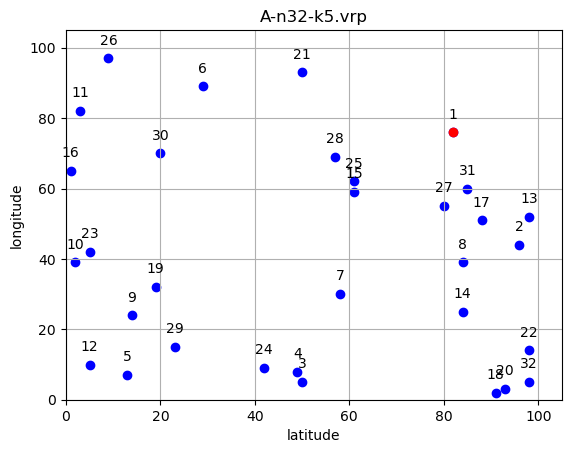

Soluzione ottima: 784
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 784
Route for vehicle 1:
 1 Load(0) ->  31 Load(14) ->  17 Load(32) ->  2 Load(51) ->  13 Load(72) ->  0 Load(72)
Distance of the route: 73m
Load of the route: 72

Route for vehicle 2:
 1 Load(0) ->  30 Load(2) ->  19 Load(3) ->  9 Load(9) ->  10 Load(25) ->  23 Load(29) ->  16 Load(51) ->  11 Load(59) ->  26 Load(83) ->  6 Load(90) ->  21 Load(98) ->  0 Load(98)
Distance of the route: 267m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  22 Load(12) ->  32 Load(21) ->  20 Load(45) ->  18 Load(64) ->  14 Load(80) ->  8 Load(96) ->  27 Load(98) ->  0 Load(98)
Distance of the route: 155m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  7 Load(12) ->  4 Load(18) ->  3 Load(39) ->  24 Load(47) ->  5 Load(66) ->  12 Load(80) ->  29 Load(95) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 230m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  25 Load(24)

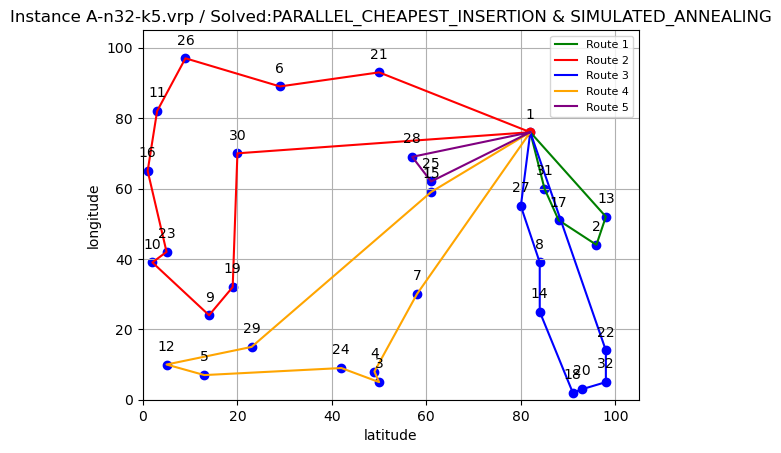

Local Search: TABU_SEARCH
Objective: 801
Route for vehicle 1:
 1 Load(0) ->  27 Load(2) ->  8 Load(18) ->  2 Load(37) ->  13 Load(58) ->  17 Load(76) ->  31 Load(90) ->  0 Load(90)
Distance of the route: 93m
Load of the route: 90

Route for vehicle 2:
 1 Load(0) ->  30 Load(2) ->  23 Load(6) ->  10 Load(22) ->  16 Load(44) ->  11 Load(52) ->  26 Load(76) ->  6 Load(83) ->  21 Load(91) ->  0 Load(91)
Distance of the route: 236m
Load of the route: 91

Route for vehicle 3:
 1 Load(0) ->  14 Load(16) ->  22 Load(28) ->  32 Load(37) ->  20 Load(61) ->  18 Load(80) ->  7 Load(92) ->  0 Load(92)
Distance of the route: 180m
Load of the route: 92

Route for vehicle 4:
 1 Load(0) ->  15 Load(3) ->  19 Load(4) ->  9 Load(10) ->  12 Load(24) ->  5 Load(43) ->  29 Load(58) ->  24 Load(66) ->  3 Load(87) ->  4 Load(93) ->  0 Load(93)
Distance of the route: 233m
Load of the route: 93

Route for vehicle 5:
 1 Load(0) ->  28 Load(20) ->  25 Load(44) ->  0 Load(44)
Distance of the route: 59m
Load of the

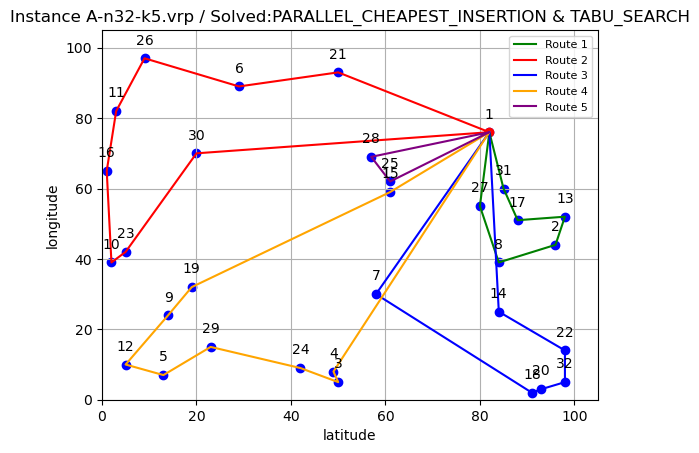

Local Search: GUIDED_LOCAL_SEARCH
Objective: 820
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  2 Load(40) ->  17 Load(58) ->  31 Load(72) ->  0 Load(72)
Distance of the route: 73m
Load of the route: 72

Route for vehicle 2:
 1 Load(0) ->  25 Load(24) ->  28 Load(44) ->  0 Load(44)
Distance of the route: 59m
Load of the route: 44

Route for vehicle 3:
 1 Load(0) ->  27 Load(2) ->  8 Load(18) ->  14 Load(34) ->  18 Load(53) ->  20 Load(77) ->  32 Load(86) ->  22 Load(98) ->  0 Load(98)
Distance of the route: 155m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  15 Load(3) ->  3 Load(24) ->  29 Load(39) ->  5 Load(58) ->  12 Load(72) ->  9 Load(78) ->  10 Load(94) ->  23 Load(98) ->  30 Load(100) ->  0 Load(100)
Distance of the route: 267m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  7 Load(12) ->  4 Load(18) ->  24 Load(26) ->  19 Load(27) ->  16 Load(49) ->  11 Load(57) ->  26 Load(81) ->  6 Load(88) ->  21 Load(96) ->  0 Load(96)
Distance of the route: 26

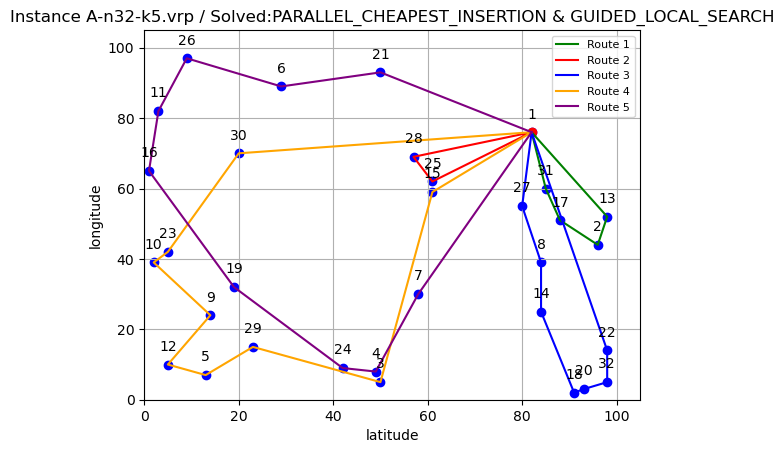

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 801
Route for vehicle 1:
 1 Load(0) ->  27 Load(2) ->  8 Load(18) ->  2 Load(37) ->  13 Load(58) ->  17 Load(76) ->  31 Load(90) ->  0 Load(90)
Distance of the route: 93m
Load of the route: 90

Route for vehicle 2:
 1 Load(0) ->  30 Load(2) ->  23 Load(6) ->  10 Load(22) ->  16 Load(44) ->  11 Load(52) ->  26 Load(76) ->  6 Load(83) ->  21 Load(91) ->  0 Load(91)
Distance of the route: 236m
Load of the route: 91

Route for vehicle 3:
 1 Load(0) ->  14 Load(16) ->  22 Load(28) ->  32 Load(37) ->  20 Load(61) ->  18 Load(80) ->  7 Load(92) ->  0 Load(92)
Distance of the route: 180m
Load of the route: 92

Route for vehicle 4:
 1 Load(0) ->  4 Load(6) ->  3 Load(27) ->  24 Load(35) ->  29 Load(50) ->  5 Load(69) ->  12 Load(83) ->  9 Load(89) ->  19 Load(90) ->  15 Load(93) ->  0 Load(93)
Distance of the route: 233m
Load of the route: 93

Route for vehicle 5:
 1 Load(0) ->  25 Load(24) ->  28 Load(44) ->  0 Load(44)
Distance of

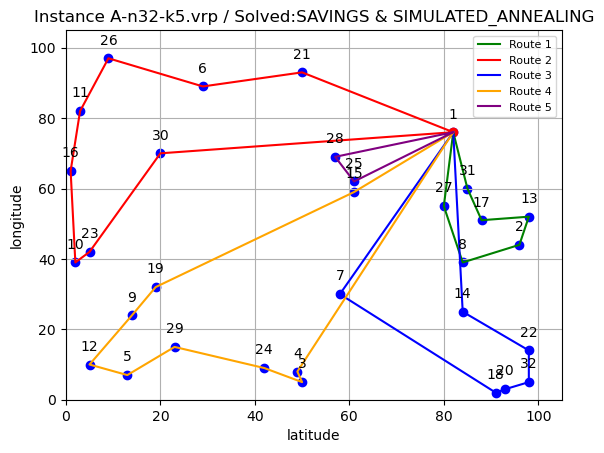

Local Search: TABU_SEARCH
Objective: 841
Route for vehicle 1:
 1 Load(0) ->  27 Load(2) ->  8 Load(18) ->  2 Load(37) ->  13 Load(58) ->  17 Load(76) ->  31 Load(90) ->  0 Load(90)
Distance of the route: 93m
Load of the route: 90

Route for vehicle 2:
 1 Load(0) ->  15 Load(3) ->  25 Load(27) ->  0 Load(27)
Distance of the route: 55m
Load of the route: 27

Route for vehicle 3:
 1 Load(0) ->  7 Load(12) ->  4 Load(18) ->  18 Load(37) ->  20 Load(61) ->  32 Load(70) ->  22 Load(82) ->  14 Load(98) ->  0 Load(98)
Distance of the route: 203m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  3 Load(21) ->  24 Load(29) ->  29 Load(44) ->  5 Load(63) ->  12 Load(77) ->  9 Load(83) ->  10 Load(99) ->  19 Load(100) ->  0 Load(100)
Distance of the route: 260m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  28 Load(20) ->  30 Load(22) ->  23 Load(26) ->  16 Load(48) ->  11 Load(56) ->  26 Load(80) ->  6 Load(87) ->  21 Load(95) ->  0 Load(95)
Distance of the route: 230m
Load 

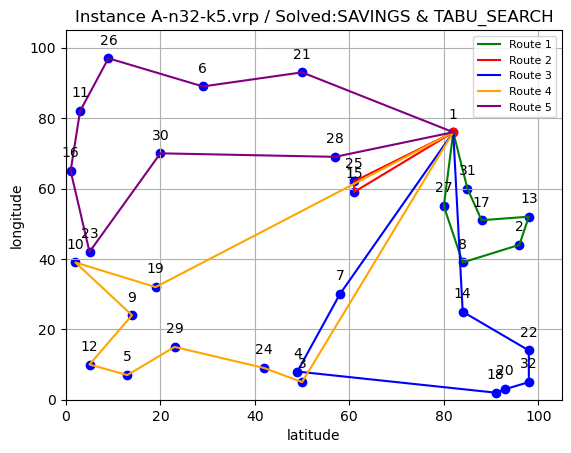

Local Search: GUIDED_LOCAL_SEARCH
Objective: 830
Route for vehicle 1:
 1 Load(0) ->  31 Load(14) ->  17 Load(32) ->  2 Load(51) ->  13 Load(72) ->  0 Load(72)
Distance of the route: 73m
Load of the route: 72

Route for vehicle 2:
 1 Load(0) ->  30 Load(2) ->  16 Load(24) ->  11 Load(32) ->  26 Load(56) ->  6 Load(63) ->  21 Load(71) ->  0 Load(71)
Distance of the route: 194m
Load of the route: 71

Route for vehicle 3:
 1 Load(0) ->  27 Load(2) ->  8 Load(18) ->  14 Load(34) ->  18 Load(53) ->  20 Load(77) ->  32 Load(86) ->  22 Load(98) ->  0 Load(98)
Distance of the route: 155m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  7 Load(12) ->  4 Load(18) ->  3 Load(39) ->  24 Load(47) ->  15 Load(50) ->  25 Load(74) ->  0 Load(74)
Distance of the route: 169m
Load of the route: 74

Route for vehicle 5:
 1 Load(0) ->  28 Load(20) ->  23 Load(24) ->  10 Load(40) ->  12 Load(54) ->  5 Load(73) ->  29 Load(88) ->  9 Load(94) ->  19 Load(95) ->  0 Load(95)
Distance of the route: 239m

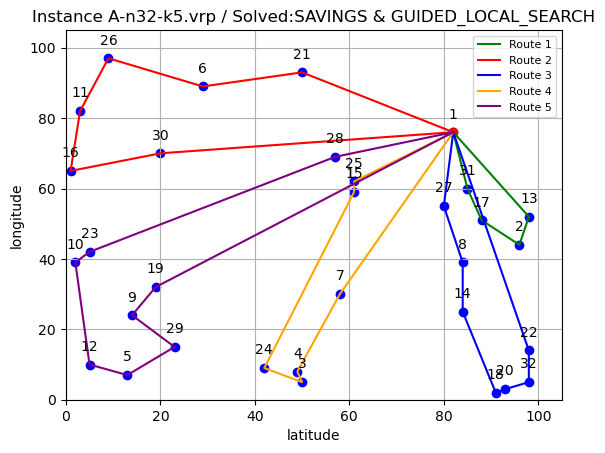

SOLVED INSTANCE: A-n32-k5.vrp
Soluzione ottima: 784
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 784
Gap: 0.0%
Tempo di esecuzione: 2.011997938156128s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 801
Gap: 2.1683673469387754%
Tempo di esecuzione: 2.001011371612549s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 820
Gap: 4.591836734693878%
Tempo di esecuzione: 1.9999990463256836s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 801
Gap: 2.1683673469387754%
Tempo di esecuzione: 2.0009660720825195s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 841
Gap: 7.270408163265306%
Tempo di e

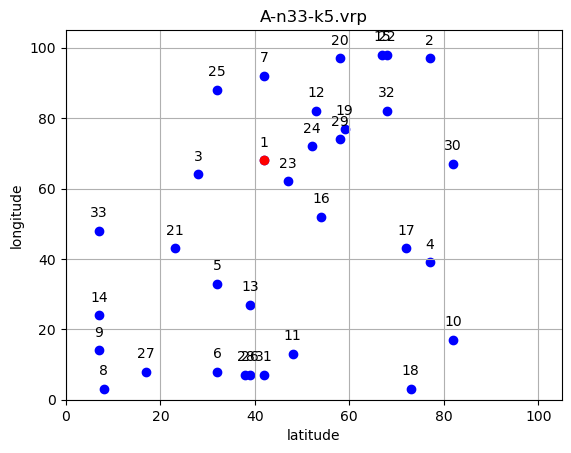

Soluzione ottima: 661
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 717
Route for vehicle 1:
 1 Load(0) ->  12 Load(5) ->  32 Load(29) ->  19 Load(42) ->  29 Load(57) ->  24 Load(71) ->  0 Load(71)
Distance of the route: 63m
Load of the route: 71

Route for vehicle 2:
 1 Load(0) ->  3 Load(23) ->  25 Load(36) ->  7 Load(54) ->  20 Load(68) ->  15 Load(77) ->  22 Load(87) ->  2 Load(92) ->  30 Load(100) ->  0 Load(100)
Distance of the route: 156m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  23 Load(19) ->  17 Load(29) ->  31 Load(49) ->  26 Load(63) ->  28 Load(86) ->  13 Load(95) ->  0 Load(95)
Distance of the route: 151m
Load of the route: 95

Route for vehicle 4:
 1 Load(0) ->  21 Load(8) ->  33 Load(11) ->  14 Load(34) ->  9 Load(44) ->  8 Load(63) ->  27 Load(65) ->  6 Load(73) ->  5 Load(86) ->  0 Load(86)
Distance of the route: 179m
Load of the route: 86

Route for vehicle 5:
 1 Load(0) ->  11 Load(20) ->  18 Load(44) ->  10 Loa

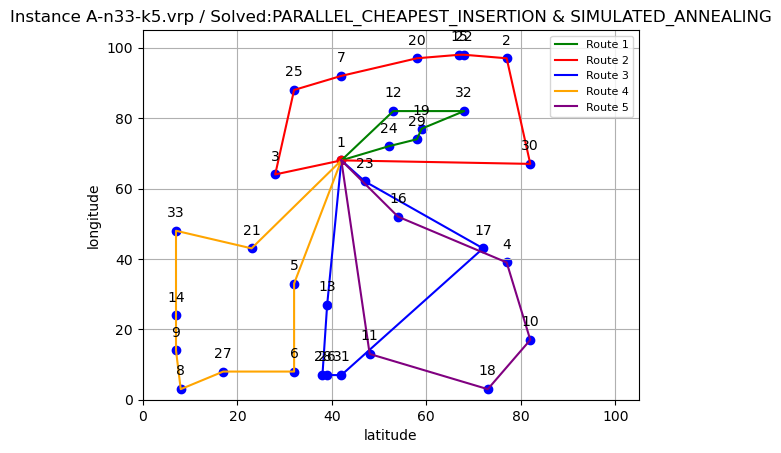

Local Search: TABU_SEARCH
Objective: 696
Route for vehicle 1:
 1 Load(0) ->  25 Load(13) ->  7 Load(31) ->  12 Load(36) ->  19 Load(49) ->  29 Load(64) ->  24 Load(78) ->  0 Load(78)
Distance of the route: 76m
Load of the route: 78

Route for vehicle 2:
 1 Load(0) ->  20 Load(14) ->  15 Load(23) ->  22 Load(33) ->  2 Load(38) ->  32 Load(62) ->  30 Load(70) ->  4 Load(84) ->  17 Load(94) ->  0 Load(94)
Distance of the route: 163m
Load of the route: 94

Route for vehicle 3:
 1 Load(0) ->  23 Load(19) ->  16 Load(37) ->  5 Load(50) ->  21 Load(58) ->  3 Load(81) ->  0 Load(81)
Distance of the route: 99m
Load of the route: 81

Route for vehicle 4:
 1 Load(0) ->  33 Load(3) ->  14 Load(26) ->  9 Load(36) ->  8 Load(55) ->  27 Load(57) ->  6 Load(65) ->  28 Load(88) ->  13 Load(97) ->  0 Load(97)
Distance of the route: 177m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  26 Load(14) ->  31 Load(34) ->  11 Load(54) ->  18 Load(78) ->  10 Load(96) ->  0 Load(96)
Distance of the rou

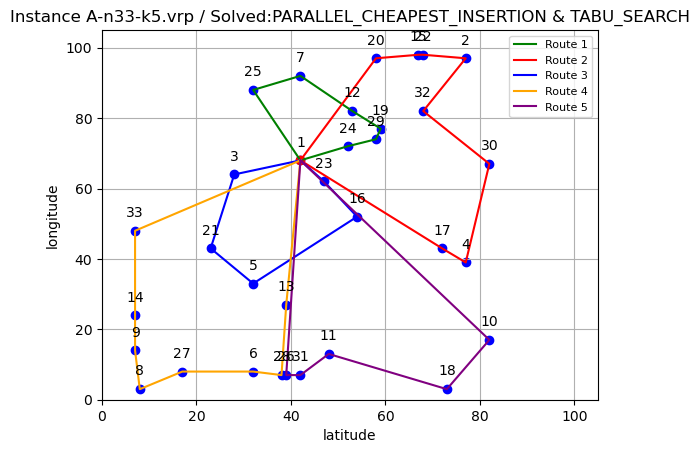

Local Search: GUIDED_LOCAL_SEARCH
Objective: 690
Route for vehicle 1:
 1 Load(0) ->  12 Load(5) ->  32 Load(29) ->  19 Load(42) ->  29 Load(57) ->  24 Load(71) ->  0 Load(71)
Distance of the route: 63m
Load of the route: 71

Route for vehicle 2:
 1 Load(0) ->  3 Load(23) ->  25 Load(36) ->  7 Load(54) ->  20 Load(68) ->  15 Load(77) ->  22 Load(87) ->  2 Load(92) ->  30 Load(100) ->  0 Load(100)
Distance of the route: 156m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  21 Load(8) ->  33 Load(11) ->  14 Load(34) ->  9 Load(44) ->  8 Load(63) ->  27 Load(65) ->  6 Load(73) ->  13 Load(82) ->  5 Load(95) ->  0 Load(95)
Distance of the route: 183m
Load of the route: 95

Route for vehicle 4:
 1 Load(0) ->  23 Load(19) ->  11 Load(39) ->  31 Load(59) ->  26 Load(73) ->  28 Load(96) ->  0 Load(96)
Distance of the route: 130m
Load of the route: 96

Route for vehicle 5:
 1 Load(0) ->  16 Load(18) ->  18 Load(42) ->  10 Load(60) ->  4 Load(74) ->  17 Load(84) ->  0 Load(84)
Distance

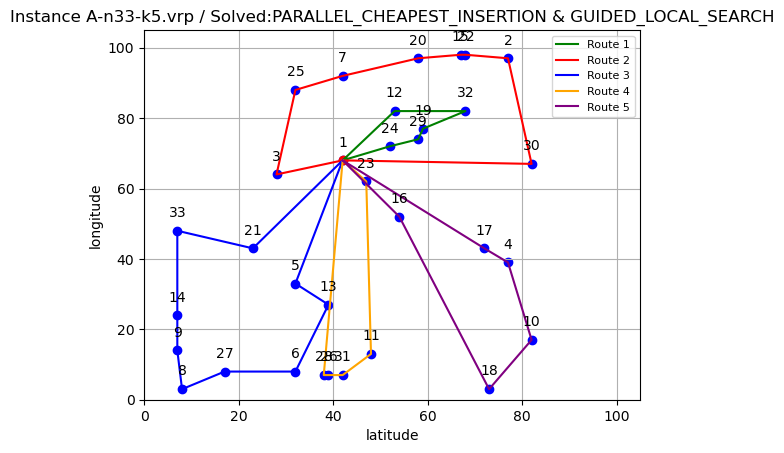

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 696
Route for vehicle 1:
 1 Load(0) ->  25 Load(13) ->  7 Load(31) ->  12 Load(36) ->  19 Load(49) ->  29 Load(64) ->  24 Load(78) ->  0 Load(78)
Distance of the route: 76m
Load of the route: 78

Route for vehicle 2:
 1 Load(0) ->  20 Load(14) ->  15 Load(23) ->  22 Load(33) ->  2 Load(38) ->  32 Load(62) ->  30 Load(70) ->  4 Load(84) ->  17 Load(94) ->  0 Load(94)
Distance of the route: 163m
Load of the route: 94

Route for vehicle 3:
 1 Load(0) ->  23 Load(19) ->  16 Load(37) ->  5 Load(50) ->  21 Load(58) ->  3 Load(81) ->  0 Load(81)
Distance of the route: 99m
Load of the route: 81

Route for vehicle 4:
 1 Load(0) ->  33 Load(3) ->  14 Load(26) ->  9 Load(36) ->  8 Load(55) ->  27 Load(57) ->  6 Load(65) ->  28 Load(88) ->  13 Load(97) ->  0 Load(97)
Distance of the route: 177m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  26 Load(14) ->  31 Load(34) ->  11 Load(54) ->  18 Load(78) ->  10 Load(96) ->  0 Lo

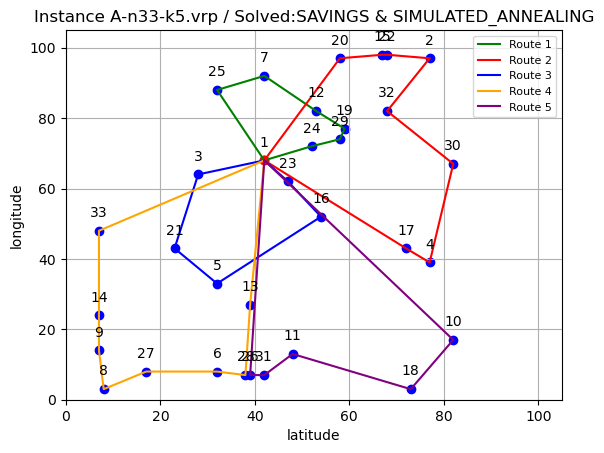

Local Search: TABU_SEARCH
Objective: 696
Route for vehicle 1:
 1 Load(0) ->  25 Load(13) ->  7 Load(31) ->  12 Load(36) ->  19 Load(49) ->  29 Load(64) ->  24 Load(78) ->  0 Load(78)
Distance of the route: 76m
Load of the route: 78

Route for vehicle 2:
 1 Load(0) ->  20 Load(14) ->  15 Load(23) ->  22 Load(33) ->  2 Load(38) ->  32 Load(62) ->  30 Load(70) ->  4 Load(84) ->  17 Load(94) ->  0 Load(94)
Distance of the route: 163m
Load of the route: 94

Route for vehicle 3:
 1 Load(0) ->  23 Load(19) ->  16 Load(37) ->  5 Load(50) ->  21 Load(58) ->  3 Load(81) ->  0 Load(81)
Distance of the route: 99m
Load of the route: 81

Route for vehicle 4:
 1 Load(0) ->  33 Load(3) ->  14 Load(26) ->  9 Load(36) ->  8 Load(55) ->  27 Load(57) ->  6 Load(65) ->  28 Load(88) ->  13 Load(97) ->  0 Load(97)
Distance of the route: 177m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  26 Load(14) ->  31 Load(34) ->  11 Load(54) ->  18 Load(78) ->  10 Load(96) ->  0 Load(96)
Distance of the rou

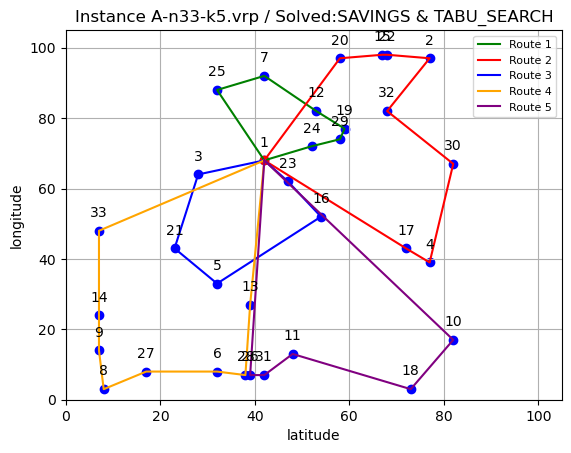

Local Search: GUIDED_LOCAL_SEARCH
Objective: 709
Route for vehicle 1:
 1 Load(0) ->  12 Load(5) ->  32 Load(29) ->  19 Load(42) ->  29 Load(57) ->  24 Load(71) ->  0 Load(71)
Distance of the route: 63m
Load of the route: 71

Route for vehicle 2:
 1 Load(0) ->  25 Load(13) ->  7 Load(31) ->  20 Load(45) ->  15 Load(54) ->  22 Load(64) ->  2 Load(69) ->  30 Load(77) ->  23 Load(96) ->  0 Load(96)
Distance of the route: 142m
Load of the route: 96

Route for vehicle 3:
 1 Load(0) ->  3 Load(23) ->  21 Load(31) ->  27 Load(33) ->  31 Load(53) ->  11 Load(73) ->  13 Load(82) ->  5 Load(95) ->  0 Load(95)
Distance of the route: 168m
Load of the route: 95

Route for vehicle 4:
 1 Load(0) ->  33 Load(3) ->  14 Load(26) ->  9 Load(36) ->  8 Load(55) ->  6 Load(63) ->  28 Load(86) ->  26 Load(100) ->  0 Load(100)
Distance of the route: 178m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  16 Load(18) ->  18 Load(42) ->  10 Load(60) ->  4 Load(74) ->  17 Load(84) ->  0 Load(84)
Distance

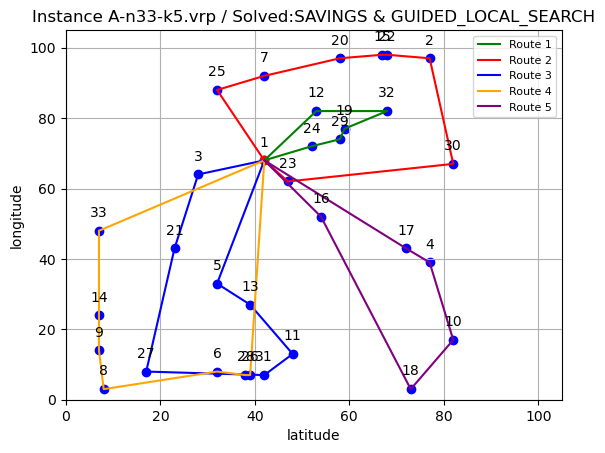

SOLVED INSTANCE: A-n33-k5.vrp
Soluzione ottima: 661
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 717
Gap: 8.472012102874432%
Tempo di esecuzione: 2.0009992122650146s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 696
Gap: 5.29500756429652%
Tempo di esecuzione: 2.0010323524475098s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 690
Gap: 4.387291981845689%
Tempo di esecuzione: 2.000999927520752s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 696
Gap: 5.29500756429652%
Tempo di esecuzione: 2.0000221729278564s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 696
Gap: 5.29500756429652%


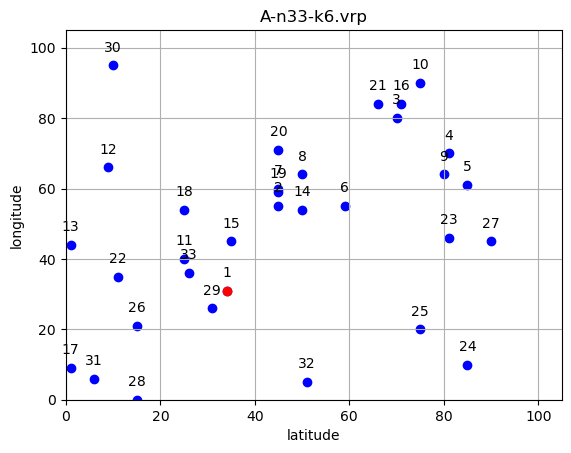

Soluzione ottima: 742
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 783
Route for vehicle 1:
 1 Load(0) ->  18 Load(17) ->  20 Load(39) ->  8 Load(54) ->  7 Load(59) ->  19 Load(76) ->  15 Load(92) ->  0 Load(92)
Distance of the route: 98m
Load of the route: 92

Route for vehicle 2:
 1 Load(0) ->  33 Load(22) ->  26 Load(33) ->  17 Load(40) ->  31 Load(65) ->  28 Load(76) ->  29 Load(97) ->  0 Load(97)
Distance of the route: 100m
Load of the route: 97

Route for vehicle 3:
 1 Load(0) ->  32 Load(2) ->  24 Load(9) ->  25 Load(30) ->  14 Load(55) ->  2 Load(81) ->  0 Load(81)
Distance of the route: 152m
Load of the route: 81

Route for vehicle 4:
 1 Load(0) ->  13 Load(66) ->  22 Load(91) ->  0 Load(91)
Distance of the route: 71m
Load of the route: 91

Route for vehicle 5:
 1 Load(0) ->  6 Load(7) ->  9 Load(23) ->  4 Load(29) ->  5 Load(44) ->  27 Load(65) ->  23 Load(81) ->  0 Load(81)
Distance of the route: 149m
Load of the route: 81

Route for veh

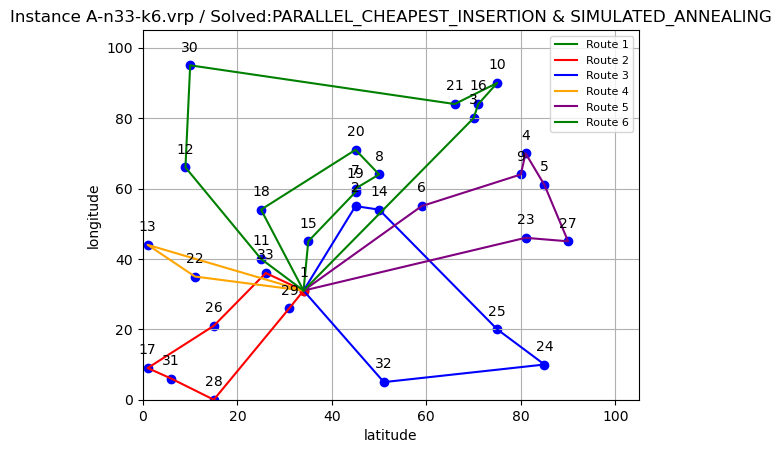

Local Search: TABU_SEARCH
Objective: 789
Route for vehicle 1:
 1 Load(0) ->  29 Load(21) ->  28 Load(32) ->  31 Load(57) ->  17 Load(64) ->  26 Load(75) ->  0 Load(75)
Distance of the route: 93m
Load of the route: 75

Route for vehicle 2:
 1 Load(0) ->  15 Load(16) ->  18 Load(33) ->  30 Load(55) ->  12 Load(76) ->  11 Load(77) ->  33 Load(99) ->  0 Load(99)
Distance of the route: 144m
Load of the route: 99

Route for vehicle 3:
 1 Load(0) ->  2 Load(26) ->  8 Load(41) ->  20 Load(63) ->  7 Load(68) ->  19 Load(85) ->  0 Load(85)
Distance of the route: 87m
Load of the route: 85

Route for vehicle 4:
 1 Load(0) ->  32 Load(2) ->  24 Load(9) ->  3 Load(26) ->  16 Load(37) ->  10 Load(54) ->  21 Load(64) ->  6 Load(71) ->  14 Load(96) ->  0 Load(96)
Distance of the route: 226m
Load of the route: 96

Route for vehicle 5:
 1 Load(0) ->  25 Load(21) ->  23 Load(37) ->  27 Load(58) ->  5 Load(73) ->  4 Load(79) ->  9 Load(95) ->  0 Load(95)
Distance of the route: 168m
Load of the route: 95

R

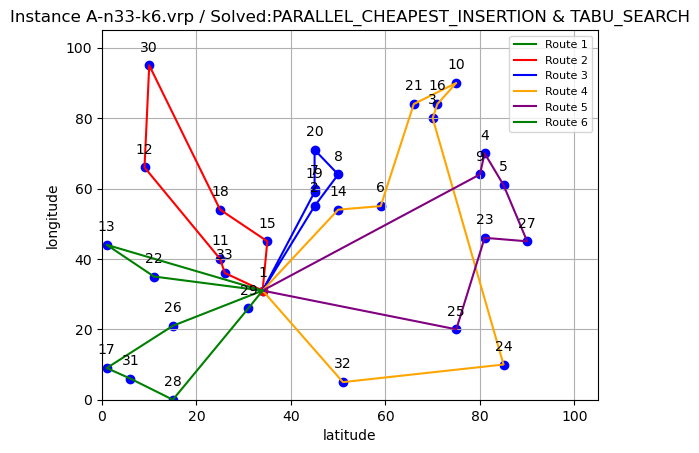

Local Search: GUIDED_LOCAL_SEARCH
Objective: 761
Route for vehicle 1:
 1 Load(0) ->  14 Load(25) ->  2 Load(51) ->  7 Load(56) ->  18 Load(73) ->  11 Load(74) ->  33 Load(96) ->  0 Load(96)
Distance of the route: 86m
Load of the route: 96

Route for vehicle 2:
 1 Load(0) ->  29 Load(21) ->  28 Load(32) ->  31 Load(57) ->  17 Load(64) ->  26 Load(75) ->  0 Load(75)
Distance of the route: 93m
Load of the route: 75

Route for vehicle 3:
 1 Load(0) ->  6 Load(7) ->  9 Load(23) ->  4 Load(29) ->  3 Load(46) ->  16 Load(57) ->  10 Load(74) ->  21 Load(84) ->  8 Load(99) ->  0 Load(99)
Distance of the route: 164m
Load of the route: 99

Route for vehicle 4:
 1 Load(0) ->  13 Load(66) ->  22 Load(91) ->  0 Load(91)
Distance of the route: 71m
Load of the route: 91

Route for vehicle 5:
 1 Load(0) ->  32 Load(2) ->  25 Load(23) ->  24 Load(30) ->  27 Load(51) ->  5 Load(66) ->  23 Load(82) ->  0 Load(82)
Distance of the route: 190m
Load of the route: 82

Route for vehicle 6:
 1 Load(0) ->  15 Loa

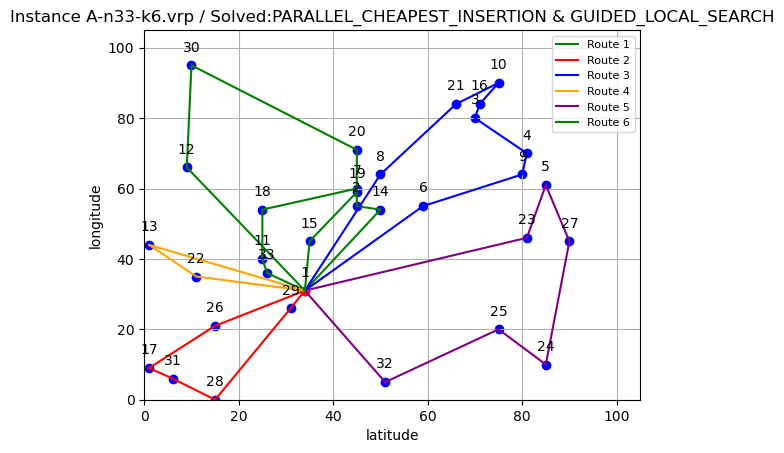

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 783
Route for vehicle 1:
 1 Load(0) ->  26 Load(11) ->  17 Load(18) ->  31 Load(43) ->  28 Load(54) ->  32 Load(56) ->  24 Load(63) ->  25 Load(84) ->  0 Load(84)
Distance of the route: 182m
Load of the route: 84

Route for vehicle 2:
 1 Load(0) ->  29 Load(21) ->  22 Load(46) ->  33 Load(68) ->  0 Load(68)
Distance of the route: 52m
Load of the route: 68

Route for vehicle 3:
 1 Load(0) ->  2 Load(26) ->  7 Load(31) ->  20 Load(53) ->  8 Load(68) ->  14 Load(93) ->  0 Load(93)
Distance of the route: 89m
Load of the route: 93

Route for vehicle 4:
 1 Load(0) ->  13 Load(66) ->  18 Load(83) ->  15 Load(99) ->  0 Load(99)
Distance of the route: 88m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  23 Load(16) ->  27 Load(37) ->  5 Load(52) ->  4 Load(58) ->  9 Load(74) ->  6 Load(81) ->  19 Load(98) ->  0 Load(98)
Distance of the route: 159m
Load of the route: 98

Route for vehicle 6:
 1 Load(0) ->  3 Load(17) ->  16

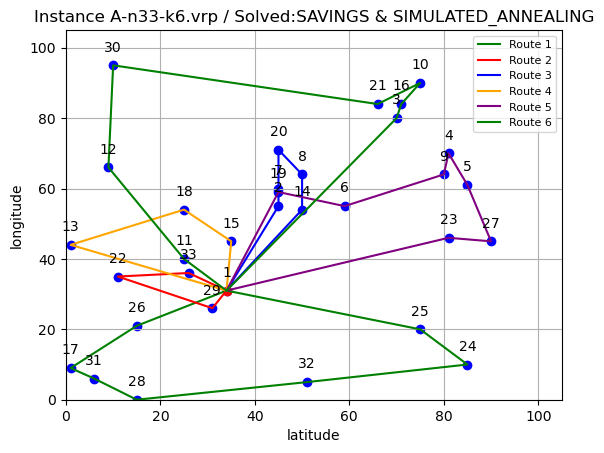

Local Search: TABU_SEARCH
Objective: 955
Route for vehicle 1:
 1 Load(0) ->  18 Load(17) ->  11 Load(18) ->  33 Load(40) ->  29 Load(61) ->  0 Load(61)
Distance of the route: 60m
Load of the route: 61

Route for vehicle 2:
 1 Load(0) ->  24 Load(7) ->  32 Load(9) ->  28 Load(20) ->  31 Load(45) ->  17 Load(52) ->  26 Load(63) ->  22 Load(88) ->  0 Load(88)
Distance of the route: 198m
Load of the route: 88

Route for vehicle 3:
 1 Load(0) ->  2 Load(26) ->  20 Load(48) ->  8 Load(63) ->  6 Load(70) ->  14 Load(95) ->  0 Load(95)
Distance of the route: 101m
Load of the route: 95

Route for vehicle 4:
 1 Load(0) ->  13 Load(66) ->  12 Load(87) ->  21 Load(97) ->  0 Load(97)
Distance of the route: 180m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  25 Load(21) ->  23 Load(37) ->  27 Load(58) ->  5 Load(73) ->  9 Load(89) ->  16 Load(100) ->  0 Load(100)
Distance of the route: 188m
Load of the route: 100

Route for vehicle 6:
 1 Load(0) ->  15 Load(16) ->  19 Load(33) ->  7 Load

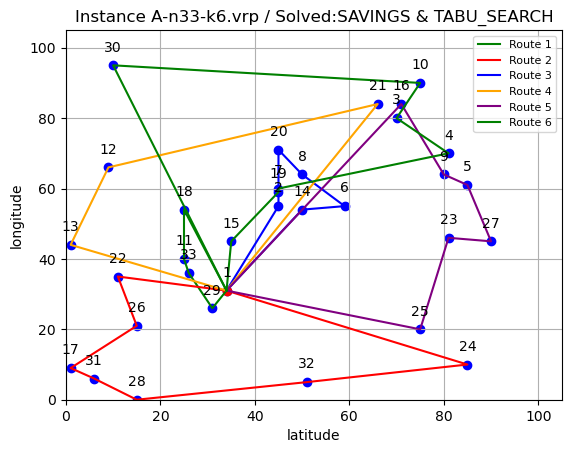

Local Search: GUIDED_LOCAL_SEARCH
Objective: 789
Route for vehicle 1:
 1 Load(0) ->  26 Load(11) ->  17 Load(18) ->  31 Load(43) ->  28 Load(54) ->  29 Load(75) ->  0 Load(75)
Distance of the route: 93m
Load of the route: 75

Route for vehicle 2:
 1 Load(0) ->  15 Load(16) ->  18 Load(33) ->  30 Load(55) ->  12 Load(76) ->  11 Load(77) ->  33 Load(99) ->  0 Load(99)
Distance of the route: 144m
Load of the route: 99

Route for vehicle 3:
 1 Load(0) ->  2 Load(26) ->  8 Load(41) ->  20 Load(63) ->  7 Load(68) ->  19 Load(85) ->  0 Load(85)
Distance of the route: 87m
Load of the route: 85

Route for vehicle 4:
 1 Load(0) ->  32 Load(2) ->  24 Load(9) ->  3 Load(26) ->  16 Load(37) ->  10 Load(54) ->  21 Load(64) ->  6 Load(71) ->  14 Load(96) ->  0 Load(96)
Distance of the route: 226m
Load of the route: 96

Route for vehicle 5:
 1 Load(0) ->  25 Load(21) ->  23 Load(37) ->  27 Load(58) ->  5 Load(73) ->  4 Load(79) ->  9 Load(95) ->  0 Load(95)
Distance of the route: 168m
Load of the rout

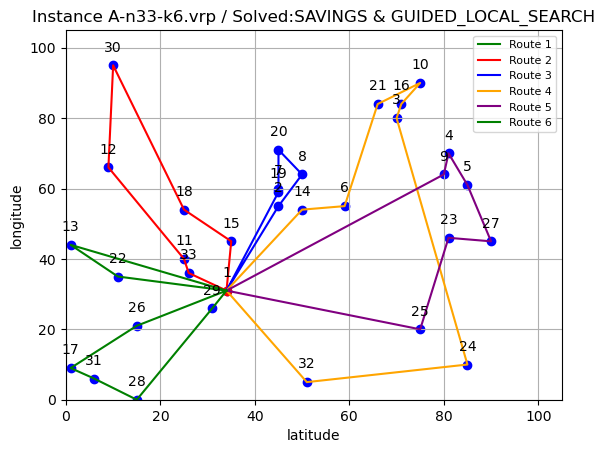

SOLVED INSTANCE: A-n33-k6.vrp
Soluzione ottima: 742
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 783
Gap: 5.525606469002695%
Tempo di esecuzione: 2.000974178314209s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 789
Gap: 6.334231805929918%
Tempo di esecuzione: 1.9989705085754395s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 761
Gap: 2.560646900269542%
Tempo di esecuzione: 2.0009992122650146s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 783
Gap: 5.525606469002695%
Tempo di esecuzione: 2.0009989738464355s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 955
Gap: 28.7061994609164

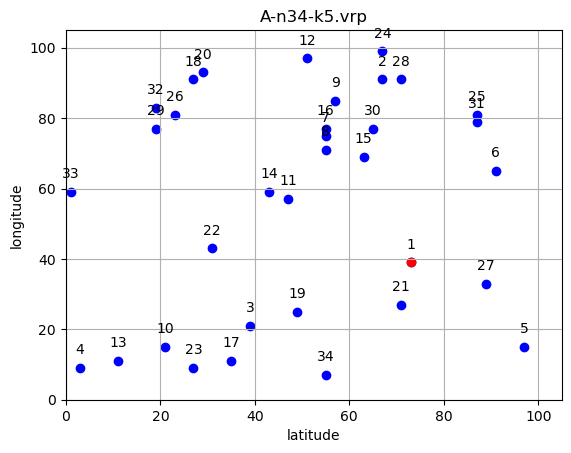

Soluzione ottima: 778
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 786
Route for vehicle 1:
 1 Load(0) ->  27 Load(20) ->  5 Load(35) ->  34 Load(36) ->  17 Load(60) ->  21 Load(73) ->  0 Load(73)
Distance of the route: 151m
Load of the route: 73

Route for vehicle 2:
 1 Load(0) ->  6 Load(15) ->  31 Load(34) ->  25 Load(54) ->  30 Load(66) ->  7 Load(90) ->  8 Load(97) ->  0 Load(97)
Distance of the route: 122m
Load of the route: 97

Route for vehicle 3:
 1 Load(0) ->  28 Load(3) ->  2 Load(26) ->  24 Load(50) ->  12 Load(57) ->  9 Load(82) ->  16 Load(87) ->  15 Load(100) ->  0 Load(100)
Distance of the route: 144m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  22 Load(16) ->  33 Load(31) ->  4 Load(55) ->  13 Load(60) ->  10 Load(73) ->  23 Load(86) ->  3 Load(89) ->  19 Load(98) ->  0 Load(98)
Distance of the route: 209m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  11 Load(5) ->  14 Load(19) ->  29 Load(34) ->  32 Loa

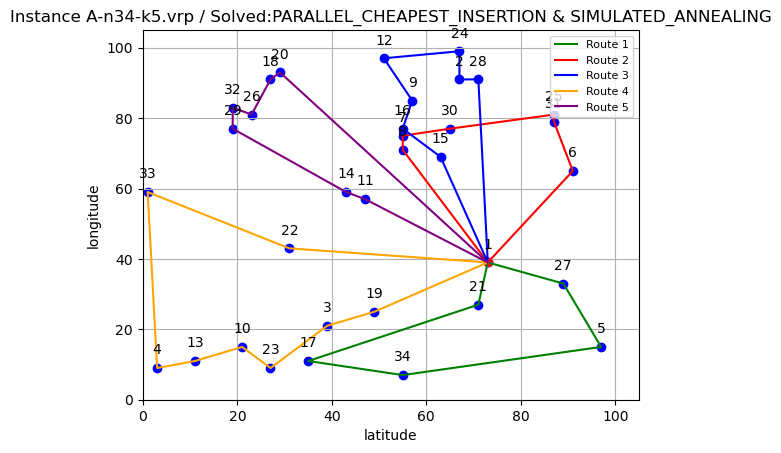

Local Search: TABU_SEARCH
Objective: 786
Route for vehicle 1:
 1 Load(0) ->  27 Load(20) ->  5 Load(35) ->  34 Load(36) ->  17 Load(60) ->  21 Load(73) ->  0 Load(73)
Distance of the route: 151m
Load of the route: 73

Route for vehicle 2:
 1 Load(0) ->  6 Load(15) ->  31 Load(34) ->  25 Load(54) ->  30 Load(66) ->  7 Load(90) ->  8 Load(97) ->  0 Load(97)
Distance of the route: 122m
Load of the route: 97

Route for vehicle 3:
 1 Load(0) ->  28 Load(3) ->  2 Load(26) ->  24 Load(50) ->  12 Load(57) ->  9 Load(82) ->  16 Load(87) ->  15 Load(100) ->  0 Load(100)
Distance of the route: 144m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  22 Load(16) ->  33 Load(31) ->  4 Load(55) ->  13 Load(60) ->  10 Load(73) ->  23 Load(86) ->  3 Load(89) ->  19 Load(98) ->  0 Load(98)
Distance of the route: 209m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  11 Load(5) ->  14 Load(19) ->  29 Load(34) ->  26 Load(57) ->  32 Load(61) ->  18 Load(76) ->  20 Load(92) ->  0 Load(92)

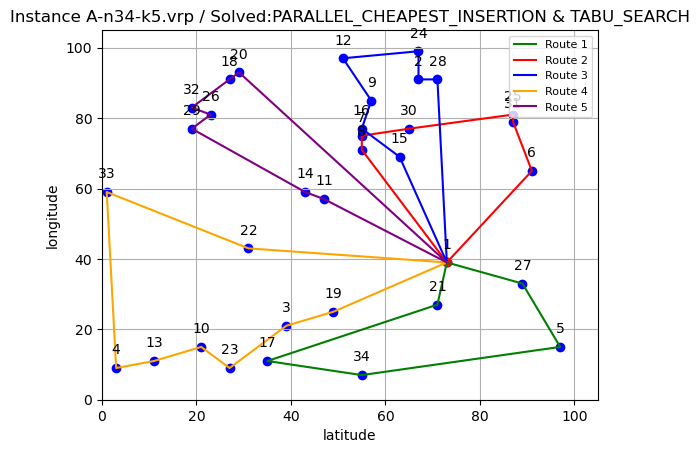

Local Search: GUIDED_LOCAL_SEARCH
Objective: 818
Route for vehicle 1:
 1 Load(0) ->  27 Load(20) ->  5 Load(35) ->  34 Load(36) ->  17 Load(60) ->  23 Load(73) ->  19 Load(82) ->  21 Load(95) ->  0 Load(95)
Distance of the route: 169m
Load of the route: 95

Route for vehicle 2:
 1 Load(0) ->  6 Load(15) ->  31 Load(34) ->  25 Load(54) ->  30 Load(66) ->  15 Load(79) ->  0 Load(79)
Distance of the route: 111m
Load of the route: 79

Route for vehicle 3:
 1 Load(0) ->  8 Load(7) ->  7 Load(31) ->  16 Load(36) ->  9 Load(61) ->  12 Load(68) ->  2 Load(91) ->  0 Load(91)
Distance of the route: 133m
Load of the route: 91

Route for vehicle 4:
 1 Load(0) ->  11 Load(5) ->  14 Load(19) ->  22 Load(35) ->  33 Load(50) ->  4 Load(74) ->  13 Load(79) ->  10 Load(92) ->  3 Load(95) ->  0 Load(95)
Distance of the route: 216m
Load of the route: 95

Route for vehicle 5:
 1 Load(0) ->  28 Load(3) ->  24 Load(27) ->  20 Load(43) ->  18 Load(58) ->  26 Load(81) ->  32 Load(85) ->  29 Load(100) ->  0 Loa

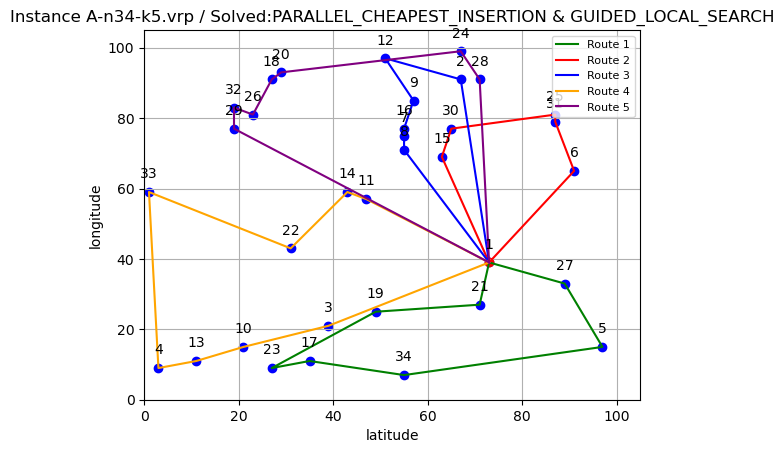

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 819
Route for vehicle 1:
 1 Load(0) ->  27 Load(20) ->  5 Load(35) ->  34 Load(36) ->  23 Load(49) ->  17 Load(73) ->  21 Load(86) ->  0 Load(86)
Distance of the route: 167m
Load of the route: 86

Route for vehicle 2:
 1 Load(0) ->  11 Load(5) ->  14 Load(19) ->  8 Load(26) ->  7 Load(50) ->  16 Load(55) ->  9 Load(80) ->  15 Load(93) ->  0 Load(93)
Distance of the route: 116m
Load of the route: 93

Route for vehicle 3:
 1 Load(0) ->  6 Load(15) ->  31 Load(34) ->  25 Load(54) ->  2 Load(77) ->  30 Load(89) ->  0 Load(89)
Distance of the route: 124m
Load of the route: 89

Route for vehicle 4:
 1 Load(0) ->  22 Load(16) ->  29 Load(31) ->  33 Load(46) ->  4 Load(70) ->  13 Load(75) ->  10 Load(88) ->  3 Load(91) ->  19 Load(100) ->  0 Load(100)
Distance of the route: 230m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  28 Load(3) ->  24 Load(27) ->  12 Load(34) ->  20 Load(50) ->  18 Load(65) ->  32 Load(69) ->  

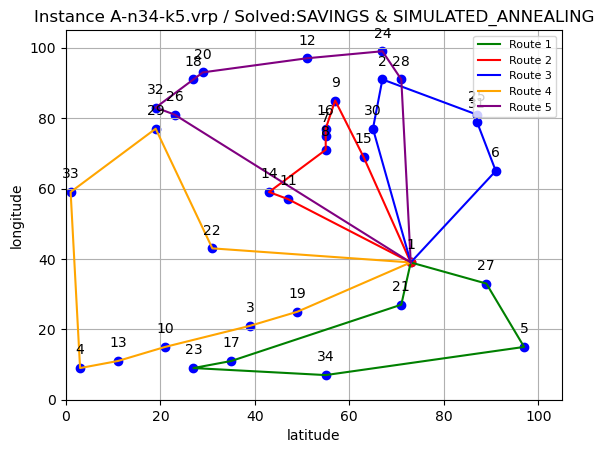

Local Search: TABU_SEARCH
Objective: 818
Route for vehicle 1:
 1 Load(0) ->  27 Load(20) ->  5 Load(35) ->  34 Load(36) ->  17 Load(60) ->  23 Load(73) ->  19 Load(82) ->  21 Load(95) ->  0 Load(95)
Distance of the route: 169m
Load of the route: 95

Route for vehicle 2:
 1 Load(0) ->  6 Load(15) ->  31 Load(34) ->  25 Load(54) ->  30 Load(66) ->  15 Load(79) ->  0 Load(79)
Distance of the route: 111m
Load of the route: 79

Route for vehicle 3:
 1 Load(0) ->  8 Load(7) ->  7 Load(31) ->  16 Load(36) ->  9 Load(61) ->  12 Load(68) ->  2 Load(91) ->  0 Load(91)
Distance of the route: 133m
Load of the route: 91

Route for vehicle 4:
 1 Load(0) ->  11 Load(5) ->  14 Load(19) ->  22 Load(35) ->  33 Load(50) ->  4 Load(74) ->  13 Load(79) ->  10 Load(92) ->  3 Load(95) ->  0 Load(95)
Distance of the route: 216m
Load of the route: 95

Route for vehicle 5:
 1 Load(0) ->  28 Load(3) ->  24 Load(27) ->  20 Load(43) ->  18 Load(58) ->  32 Load(62) ->  26 Load(85) ->  29 Load(100) ->  0 Load(100)
D

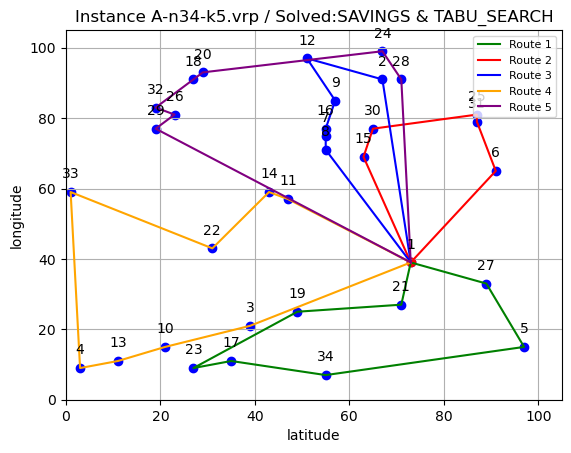

Local Search: GUIDED_LOCAL_SEARCH
Objective: 786
Route for vehicle 1:
 1 Load(0) ->  27 Load(20) ->  5 Load(35) ->  34 Load(36) ->  17 Load(60) ->  21 Load(73) ->  0 Load(73)
Distance of the route: 151m
Load of the route: 73

Route for vehicle 2:
 1 Load(0) ->  8 Load(7) ->  20 Load(23) ->  18 Load(38) ->  32 Load(42) ->  26 Load(65) ->  29 Load(80) ->  14 Load(94) ->  11 Load(99) ->  0 Load(99)
Distance of the route: 161m
Load of the route: 99

Route for vehicle 3:
 1 Load(0) ->  6 Load(15) ->  31 Load(34) ->  25 Load(54) ->  30 Load(66) ->  16 Load(71) ->  7 Load(95) ->  0 Load(95)
Distance of the route: 123m
Load of the route: 95

Route for vehicle 4:
 1 Load(0) ->  22 Load(16) ->  33 Load(31) ->  4 Load(55) ->  13 Load(60) ->  10 Load(73) ->  23 Load(86) ->  3 Load(89) ->  19 Load(98) ->  0 Load(98)
Distance of the route: 209m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  28 Load(3) ->  2 Load(26) ->  24 Load(50) ->  12 Load(57) ->  9 Load(82) ->  15 Load(95) ->  0 Loa

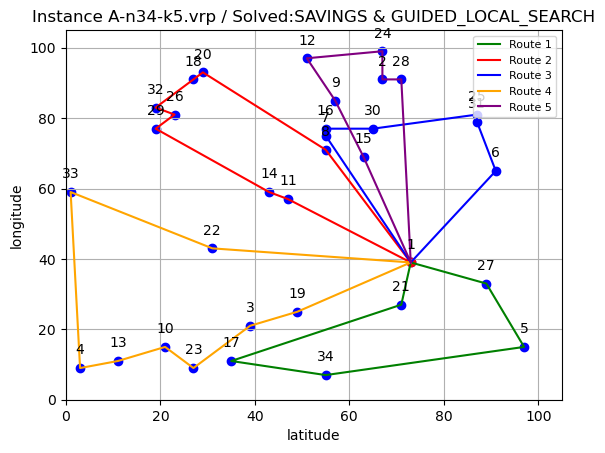

SOLVED INSTANCE: A-n34-k5.vrp
Soluzione ottima: 778
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 786
Gap: 1.0282776349614395%
Tempo di esecuzione: 2.001005172729492s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 786
Gap: 1.0282776349614395%
Tempo di esecuzione: 1.9999995231628418s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 818
Gap: 5.141388174807198%
Tempo di esecuzione: 2.000032901763916s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 819
Gap: 5.269922879177378%
Tempo di esecuzione: 2.0010344982147217s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 818
Gap: 5.1413881748071

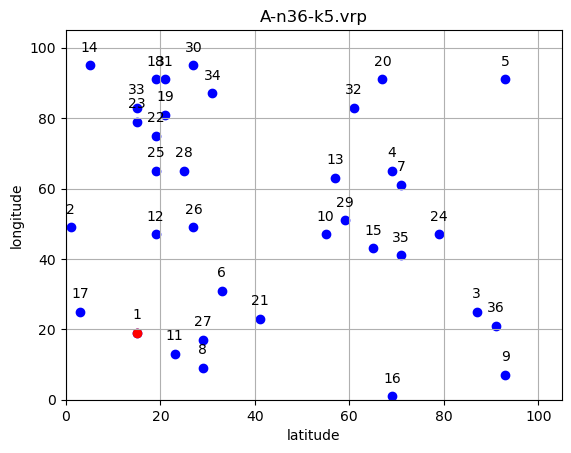

Soluzione ottima: 799
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 869
Route for vehicle 1:
 1 Load(0) ->  27 Load(13) ->  8 Load(35) ->  11 Load(58) ->  0 Load(58)
Distance of the route: 39m
Load of the route: 58

Route for vehicle 2:
 1 Load(0) ->  12 Load(12) ->  25 Load(25) ->  22 Load(40) ->  23 Load(51) ->  19 Load(70) ->  28 Load(78) ->  26 Load(97) ->  0 Load(97)
Distance of the route: 132m
Load of the route: 97

Route for vehicle 3:
 1 Load(0) ->  6 Load(18) ->  13 Load(39) ->  29 Load(54) ->  10 Load(72) ->  21 Load(92) ->  0 Load(92)
Distance of the route: 134m
Load of the route: 92

Route for vehicle 4:
 1 Load(0) ->  16 Load(9) ->  9 Load(16) ->  36 Load(27) ->  3 Load(41) ->  24 Load(47) ->  7 Load(49) ->  4 Load(64) ->  32 Load(85) ->  34 Load(87) ->  33 Load(99) ->  0 Load(99)
Distance of the route: 275m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  17 Load(10) ->  2 Load(11) ->  14 Load(13) ->  18 Load(17) ->  31 Load(

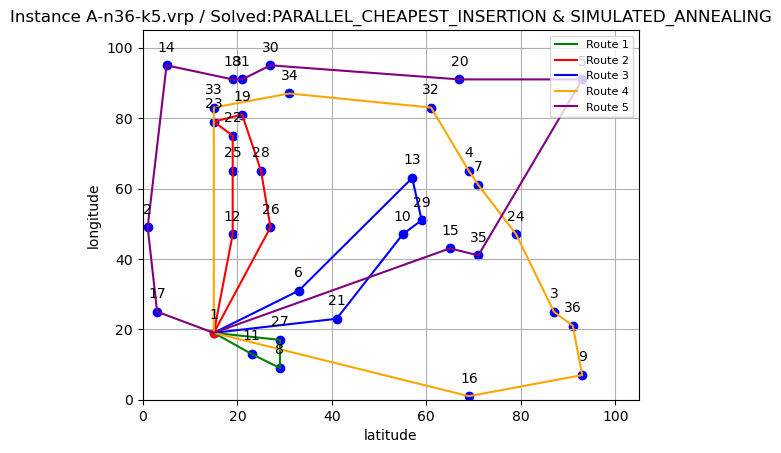

Local Search: TABU_SEARCH
Objective: 864
Route for vehicle 1:
 1 Load(0) ->  27 Load(13) ->  8 Load(35) ->  11 Load(58) ->  0 Load(58)
Distance of the route: 39m
Load of the route: 58

Route for vehicle 2:
 1 Load(0) ->  17 Load(10) ->  12 Load(22) ->  25 Load(35) ->  22 Load(50) ->  19 Load(69) ->  28 Load(77) ->  26 Load(96) ->  0 Load(96)
Distance of the route: 138m
Load of the route: 96

Route for vehicle 3:
 1 Load(0) ->  10 Load(18) ->  29 Load(33) ->  15 Load(47) ->  35 Load(70) ->  21 Load(90) ->  0 Load(90)
Distance of the route: 132m
Load of the route: 90

Route for vehicle 4:
 1 Load(0) ->  6 Load(18) ->  13 Load(39) ->  7 Load(41) ->  4 Load(56) ->  32 Load(77) ->  33 Load(89) ->  23 Load(100) ->  0 Load(100)
Distance of the route: 210m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  16 Load(9) ->  9 Load(16) ->  36 Load(27) ->  3 Load(41) ->  24 Load(47) ->  5 Load(58) ->  20 Load(60) ->  34 Load(62) ->  30 Load(80) ->  31 Load(91) ->  18 Load(95) ->  14 Load(9

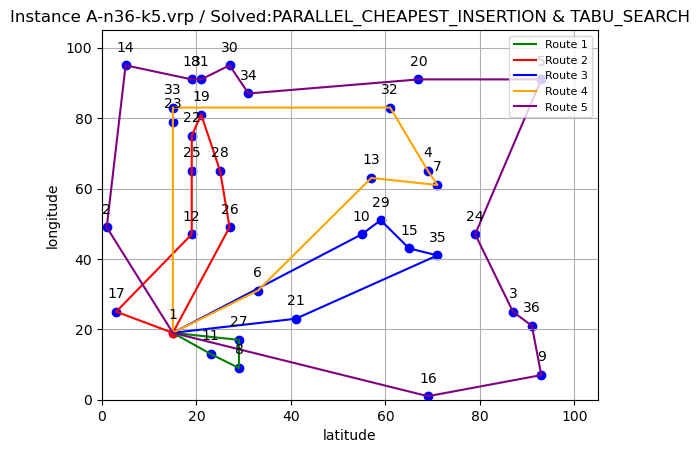

Local Search: GUIDED_LOCAL_SEARCH
Objective: 848
Route for vehicle 1:
 1 Load(0) ->  27 Load(13) ->  8 Load(35) ->  11 Load(58) ->  0 Load(58)
Distance of the route: 39m
Load of the route: 58

Route for vehicle 2:
 1 Load(0) ->  17 Load(10) ->  13 Load(31) ->  32 Load(52) ->  20 Load(54) ->  5 Load(65) ->  4 Load(80) ->  7 Load(82) ->  29 Load(97) ->  0 Load(97)
Distance of the route: 244m
Load of the route: 97

Route for vehicle 3:
 1 Load(0) ->  21 Load(20) ->  35 Load(43) ->  15 Load(57) ->  10 Load(75) ->  6 Load(93) ->  0 Load(93)
Distance of the route: 127m
Load of the route: 93

Route for vehicle 4:
 1 Load(0) ->  22 Load(15) ->  23 Load(26) ->  33 Load(38) ->  19 Load(57) ->  34 Load(59) ->  30 Load(77) ->  31 Load(88) ->  18 Load(92) ->  14 Load(94) ->  2 Load(95) ->  0 Load(95)
Distance of the route: 196m
Load of the route: 95

Route for vehicle 5:
 1 Load(0) ->  16 Load(9) ->  9 Load(16) ->  36 Load(27) ->  3 Load(41) ->  24 Load(47) ->  28 Load(55) ->  25 Load(68) ->  26 Lo

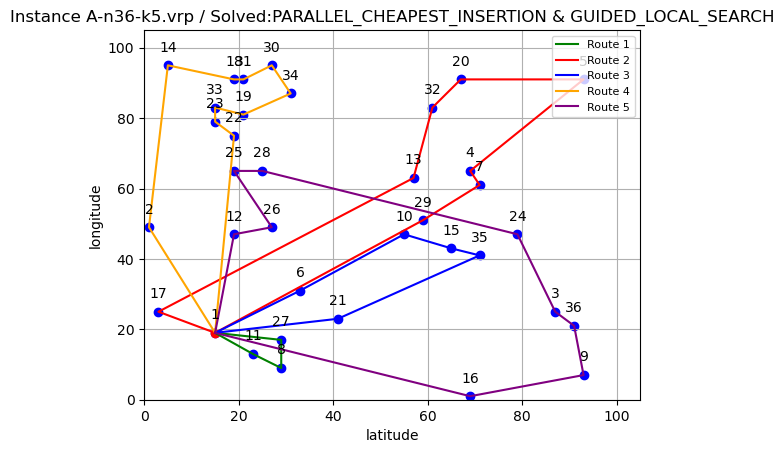

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 881
Route for vehicle 1:
 1 Load(0) ->  8 Load(22) ->  11 Load(45) ->  0 Load(45)
Distance of the route: 34m
Load of the route: 45

Route for vehicle 2:
 1 Load(0) ->  17 Load(10) ->  2 Load(11) ->  14 Load(13) ->  19 Load(32) ->  22 Load(47) ->  25 Load(60) ->  28 Load(68) ->  26 Load(87) ->  12 Load(99) ->  0 Load(99)
Distance of the route: 178m
Load of the route: 99

Route for vehicle 3:
 1 Load(0) ->  16 Load(9) ->  9 Load(16) ->  36 Load(27) ->  3 Load(41) ->  24 Load(47) ->  35 Load(70) ->  15 Load(84) ->  29 Load(99) ->  0 Load(99)
Distance of the route: 205m
Load of the route: 99

Route for vehicle 4:
 1 Load(0) ->  6 Load(18) ->  13 Load(39) ->  4 Load(54) ->  32 Load(75) ->  34 Load(77) ->  33 Load(89) ->  23 Load(100) ->  0 Load(100)
Distance of the route: 204m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  27 Load(13) ->  21 Load(33) ->  10 Load(51) ->  7 Load(53) ->  5 Load(64) ->  20 Load(66) ->  

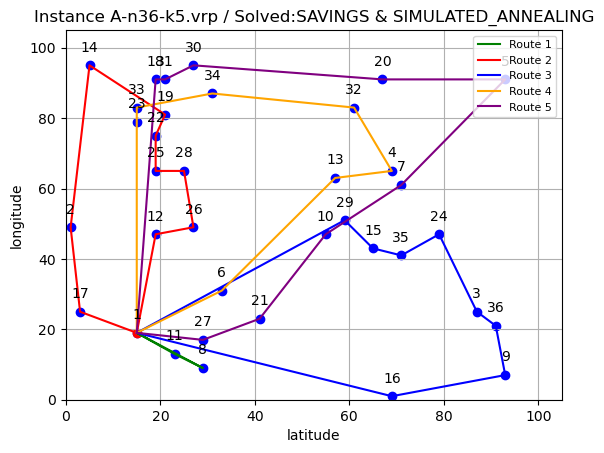

Local Search: TABU_SEARCH
Objective: 850
Route for vehicle 1:
 1 Load(0) ->  27 Load(13) ->  8 Load(35) ->  11 Load(58) ->  0 Load(58)
Distance of the route: 39m
Load of the route: 58

Route for vehicle 2:
 1 Load(0) ->  17 Load(10) ->  13 Load(31) ->  32 Load(52) ->  20 Load(54) ->  5 Load(65) ->  4 Load(80) ->  7 Load(82) ->  6 Load(100) ->  0 Load(100)
Distance of the route: 244m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  21 Load(20) ->  35 Load(43) ->  15 Load(57) ->  29 Load(72) ->  10 Load(90) ->  0 Load(90)
Distance of the route: 132m
Load of the route: 90

Route for vehicle 4:
 1 Load(0) ->  2 Load(1) ->  23 Load(12) ->  33 Load(24) ->  14 Load(26) ->  18 Load(30) ->  31 Load(41) ->  30 Load(59) ->  34 Load(61) ->  19 Load(80) ->  22 Load(95) ->  0 Load(95)
Distance of the route: 193m
Load of the route: 95

Route for vehicle 5:
 1 Load(0) ->  16 Load(9) ->  9 Load(16) ->  36 Load(27) ->  3 Load(41) ->  24 Load(47) ->  28 Load(55) ->  25 Load(68) ->  26 Load(87)

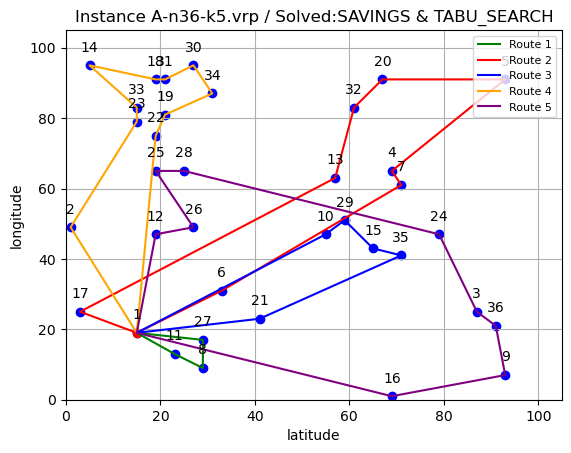

Local Search: GUIDED_LOCAL_SEARCH
Objective: 885
Route for vehicle 1:
 1 Load(0) ->  8 Load(22) ->  11 Load(45) ->  0 Load(45)
Distance of the route: 34m
Load of the route: 45

Route for vehicle 2:
 1 Load(0) ->  27 Load(13) ->  21 Load(33) ->  6 Load(51) ->  26 Load(70) ->  28 Load(78) ->  12 Load(90) ->  17 Load(100) ->  0 Load(100)
Distance of the route: 132m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  16 Load(9) ->  9 Load(16) ->  36 Load(27) ->  3 Load(41) ->  24 Load(47) ->  4 Load(62) ->  35 Load(85) ->  15 Load(99) ->  0 Load(99)
Distance of the route: 231m
Load of the route: 99

Route for vehicle 4:
 1 Load(0) ->  10 Load(18) ->  29 Load(33) ->  13 Load(54) ->  32 Load(75) ->  33 Load(87) ->  23 Load(98) ->  2 Load(99) ->  0 Load(99)
Distance of the route: 203m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  25 Load(13) ->  22 Load(28) ->  19 Load(47) ->  14 Load(49) ->  18 Load(53) ->  31 Load(64) ->  30 Load(82) ->  34 Load(84) ->  20 Load(86) ->  

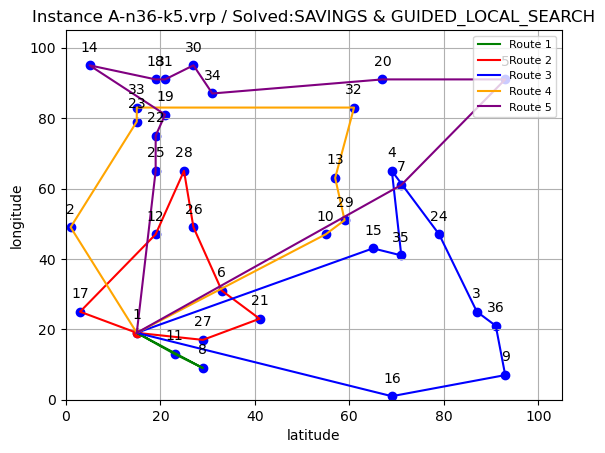

SOLVED INSTANCE: A-n36-k5.vrp
Soluzione ottima: 799
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 869
Gap: 8.760951188986233%
Tempo di esecuzione: 2.0000054836273193s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 864
Gap: 8.1351689612015%
Tempo di esecuzione: 2.001012086868286s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 848
Gap: 6.132665832290362%
Tempo di esecuzione: 2.0000059604644775s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 881
Gap: 10.262828535669586%
Tempo di esecuzione: 1.9999980926513672s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 850
Gap: 6.382978723404255

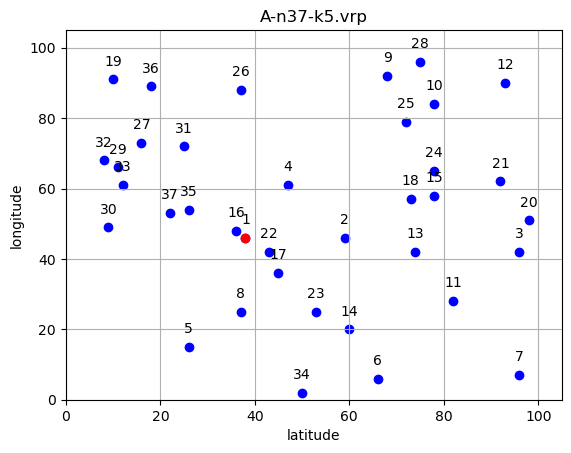

Soluzione ottima: 669
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 669
Route for vehicle 1:
 1 Load(0) ->  22 Load(23) ->  17 Load(39) ->  0 Load(39)
Distance of the route: 24m
Load of the route: 39

Route for vehicle 2:
 1 Load(0) ->  8 Load(7) ->  5 Load(20) ->  34 Load(27) ->  6 Load(35) ->  7 Load(58) ->  11 Load(61) ->  14 Load(80) ->  23 Load(96) ->  0 Load(96)
Distance of the route: 192m
Load of the route: 96

Route for vehicle 3:
 1 Load(0) ->  16 Load(5) ->  31 Load(28) ->  32 Load(34) ->  29 Load(35) ->  33 Load(54) ->  30 Load(63) ->  37 Load(83) ->  0 Load(83)
Distance of the route: 98m
Load of the route: 83

Route for vehicle 4:
 1 Load(0) ->  2 Load(16) ->  13 Load(40) ->  3 Load(58) ->  20 Load(80) ->  21 Load(87) ->  24 Load(89) ->  15 Load(91) ->  18 Load(98) ->  0 Load(98)
Distance of the route: 144m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  35 Load(7) ->  27 Load(9) ->  19 Load(13) ->  36 Load(33) ->  26 Load(42)

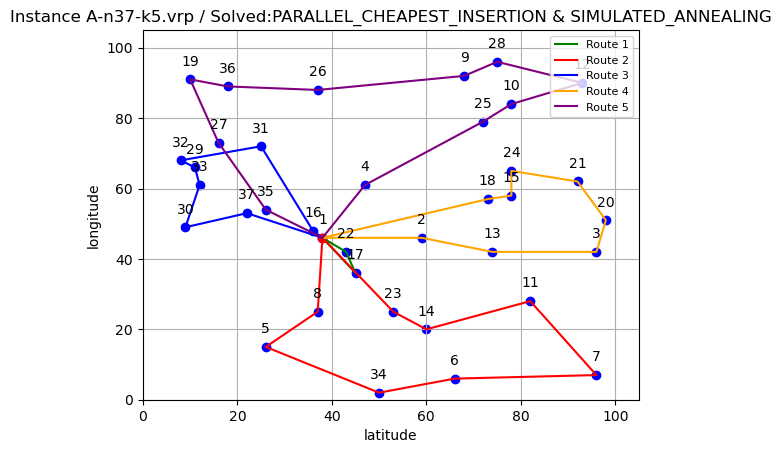

Local Search: TABU_SEARCH
Objective: 670
Route for vehicle 1:
 1 Load(0) ->  17 Load(16) ->  22 Load(39) ->  0 Load(39)
Distance of the route: 24m
Load of the route: 39

Route for vehicle 2:
 1 Load(0) ->  18 Load(7) ->  15 Load(9) ->  24 Load(11) ->  21 Load(18) ->  20 Load(40) ->  3 Load(58) ->  13 Load(82) ->  2 Load(98) ->  0 Load(98)
Distance of the route: 144m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  16 Load(5) ->  31 Load(28) ->  27 Load(30) ->  32 Load(36) ->  29 Load(37) ->  33 Load(56) ->  30 Load(65) ->  37 Load(85) ->  35 Load(92) ->  0 Load(92)
Distance of the route: 100m
Load of the route: 92

Route for vehicle 4:
 1 Load(0) ->  8 Load(7) ->  5 Load(20) ->  34 Load(27) ->  6 Load(35) ->  7 Load(58) ->  11 Load(61) ->  14 Load(80) ->  23 Load(96) ->  0 Load(96)
Distance of the route: 192m
Load of the route: 96

Route for vehicle 5:
 1 Load(0) ->  19 Load(4) ->  36 Load(24) ->  26 Load(33) ->  9 Load(60) ->  28 Load(72) ->  12 Load(78) ->  10 Load(79) ->  

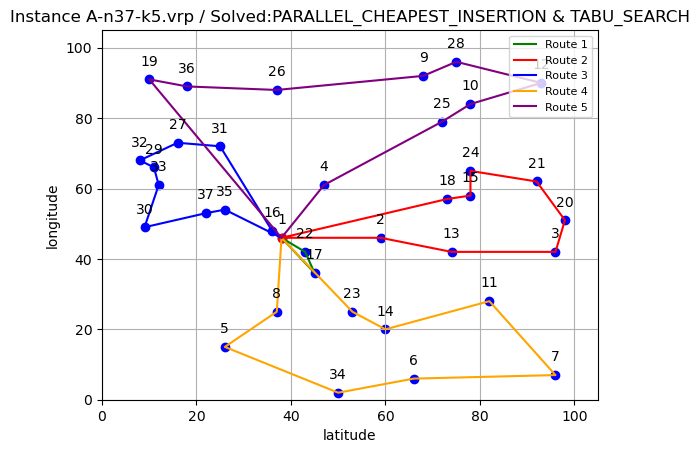

Local Search: GUIDED_LOCAL_SEARCH
Objective: 669
Route for vehicle 1:
 1 Load(0) ->  17 Load(16) ->  22 Load(39) ->  0 Load(39)
Distance of the route: 24m
Load of the route: 39

Route for vehicle 2:
 1 Load(0) ->  18 Load(7) ->  15 Load(9) ->  24 Load(11) ->  21 Load(18) ->  20 Load(40) ->  3 Load(58) ->  13 Load(82) ->  2 Load(98) ->  0 Load(98)
Distance of the route: 144m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  37 Load(20) ->  30 Load(29) ->  33 Load(48) ->  29 Load(49) ->  32 Load(55) ->  31 Load(78) ->  16 Load(83) ->  0 Load(83)
Distance of the route: 98m
Load of the route: 83

Route for vehicle 4:
 1 Load(0) ->  8 Load(7) ->  5 Load(20) ->  34 Load(27) ->  6 Load(35) ->  7 Load(58) ->  11 Load(61) ->  14 Load(80) ->  23 Load(96) ->  0 Load(96)
Distance of the route: 192m
Load of the route: 96

Route for vehicle 5:
 1 Load(0) ->  35 Load(7) ->  27 Load(9) ->  19 Load(13) ->  36 Load(33) ->  26 Load(42) ->  9 Load(69) ->  28 Load(81) ->  12 Load(87) ->  10 Load(8

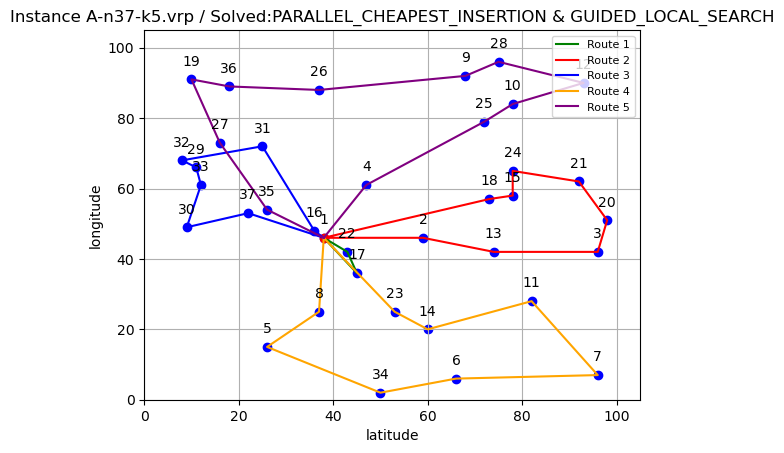

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 670
Route for vehicle 1:
 1 Load(0) ->  17 Load(16) ->  22 Load(39) ->  0 Load(39)
Distance of the route: 24m
Load of the route: 39

Route for vehicle 2:
 1 Load(0) ->  18 Load(7) ->  15 Load(9) ->  24 Load(11) ->  21 Load(18) ->  20 Load(40) ->  3 Load(58) ->  13 Load(82) ->  2 Load(98) ->  0 Load(98)
Distance of the route: 144m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  31 Load(23) ->  27 Load(25) ->  32 Load(31) ->  29 Load(32) ->  33 Load(51) ->  30 Load(60) ->  37 Load(80) ->  35 Load(87) ->  0 Load(87)
Distance of the route: 100m
Load of the route: 87

Route for vehicle 4:
 1 Load(0) ->  8 Load(7) ->  5 Load(20) ->  34 Load(27) ->  6 Load(35) ->  7 Load(58) ->  11 Load(61) ->  14 Load(80) ->  23 Load(96) ->  0 Load(96)
Distance of the route: 192m
Load of the route: 96

Route for vehicle 5:
 1 Load(0) ->  16 Load(5) ->  19 Load(9) ->  36 Load(29) ->  26 Load(38) ->  9 Load(65) ->  28 Load(77) ->  12 Loa

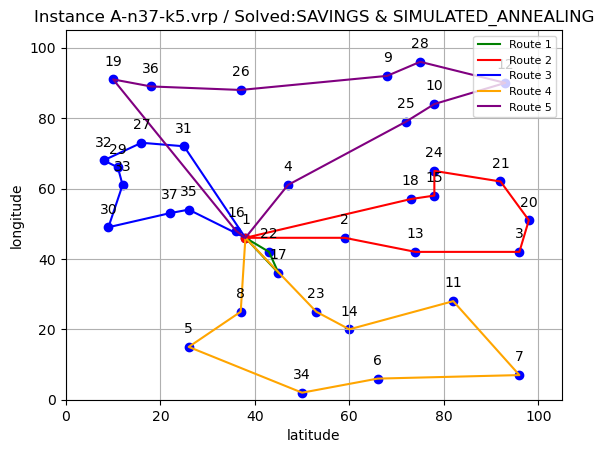

Local Search: TABU_SEARCH
Objective: 670
Route for vehicle 1:
 1 Load(0) ->  17 Load(16) ->  22 Load(39) ->  0 Load(39)
Distance of the route: 24m
Load of the route: 39

Route for vehicle 2:
 1 Load(0) ->  18 Load(7) ->  15 Load(9) ->  24 Load(11) ->  21 Load(18) ->  20 Load(40) ->  3 Load(58) ->  13 Load(82) ->  2 Load(98) ->  0 Load(98)
Distance of the route: 144m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  31 Load(23) ->  27 Load(25) ->  32 Load(31) ->  29 Load(32) ->  33 Load(51) ->  30 Load(60) ->  37 Load(80) ->  35 Load(87) ->  0 Load(87)
Distance of the route: 100m
Load of the route: 87

Route for vehicle 4:
 1 Load(0) ->  8 Load(7) ->  5 Load(20) ->  34 Load(27) ->  6 Load(35) ->  7 Load(58) ->  11 Load(61) ->  14 Load(80) ->  23 Load(96) ->  0 Load(96)
Distance of the route: 192m
Load of the route: 96

Route for vehicle 5:
 1 Load(0) ->  16 Load(5) ->  19 Load(9) ->  36 Load(29) ->  26 Load(38) ->  9 Load(65) ->  28 Load(77) ->  12 Load(83) ->  10 Load(84) ->  

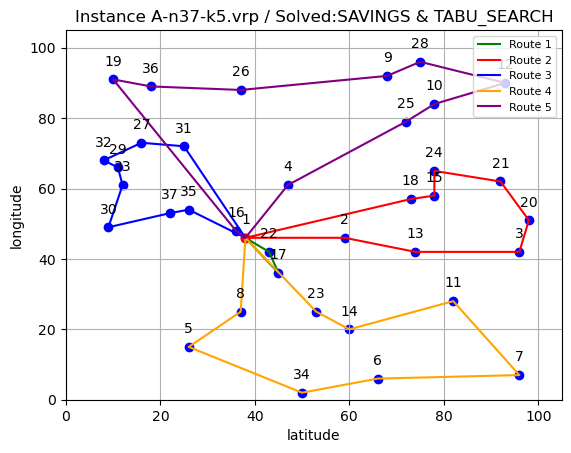

Local Search: GUIDED_LOCAL_SEARCH
Objective: 791
Route for vehicle 1:
 1 Load(0) ->  37 Load(20) ->  35 Load(27) ->  0 Load(27)
Distance of the route: 35m
Load of the route: 27

Route for vehicle 2:
 1 Load(0) ->  18 Load(7) ->  21 Load(14) ->  20 Load(36) ->  3 Load(54) ->  13 Load(78) ->  2 Load(94) ->  0 Load(94)
Distance of the route: 138m
Load of the route: 94

Route for vehicle 3:
 1 Load(0) ->  34 Load(7) ->  6 Load(15) ->  7 Load(38) ->  11 Load(41) ->  15 Load(43) ->  24 Load(45) ->  25 Load(47) ->  28 Load(59) ->  9 Load(86) ->  26 Load(95) ->  16 Load(100) ->  0 Load(100)
Distance of the route: 268m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  8 Load(7) ->  5 Load(20) ->  14 Load(39) ->  23 Load(55) ->  17 Load(71) ->  22 Load(94) ->  0 Load(94)
Distance of the route: 105m
Load of the route: 94

Route for vehicle 5:
 1 Load(0) ->  4 Load(1) ->  12 Load(7) ->  10 Load(8) ->  31 Load(31) ->  36 Load(51) ->  19 Load(55) ->  27 Load(57) ->  32 Load(63) ->  29 Load

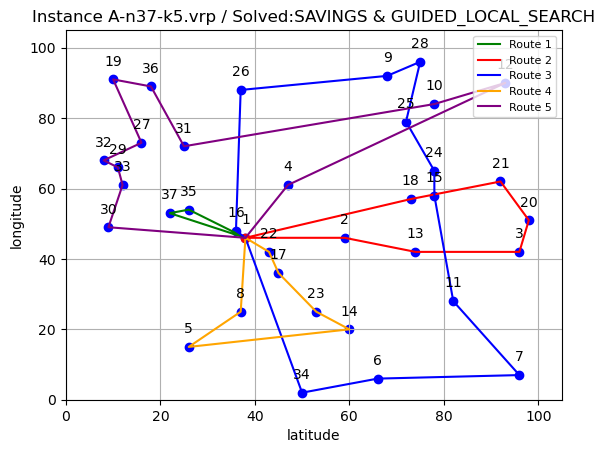

SOLVED INSTANCE: A-n37-k5.vrp
Soluzione ottima: 669
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 669
Gap: 0.0%
Tempo di esecuzione: 2.000998020172119s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 670
Gap: 0.14947683109118087%
Tempo di esecuzione: 2.0009982585906982s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 669
Gap: 0.0%
Tempo di esecuzione: 2.0009992122650146s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 670
Gap: 0.14947683109118087%
Tempo di esecuzione: 1.999969482421875s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 670
Gap: 0.14947683109118087%
Tempo di esecuzione:

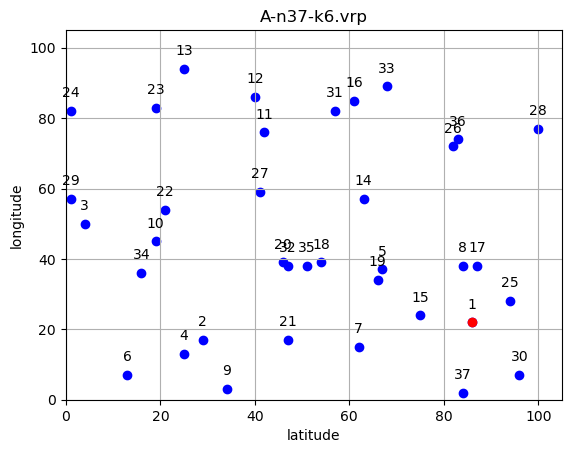

Soluzione ottima: 949
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 1005
Route for vehicle 1:
 1 Load(0) ->  32 Load(21) ->  20 Load(31) ->  18 Load(45) ->  5 Load(50) ->  8 Load(62) ->  17 Load(79) ->  25 Load(97) ->  0 Load(97)
Distance of the route: 106m
Load of the route: 97

Route for vehicle 2:
 1 Load(0) ->  30 Load(18) ->  37 Load(39) ->  7 Load(57) ->  19 Load(65) ->  15 Load(78) ->  0 Load(78)
Distance of the route: 100m
Load of the route: 78

Route for vehicle 3:
 1 Load(0) ->  21 Load(5) ->  2 Load(6) ->  3 Load(29) ->  29 Load(32) ->  24 Load(41) ->  23 Load(53) ->  13 Load(55) ->  11 Load(74) ->  14 Load(100) ->  0 Load(100)
Distance of the route: 257m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  26 Load(4) ->  36 Load(70) ->  33 Load(91) ->  28 Load(99) ->  0 Load(99)
Distance of the route: 164m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  9 Load(20) ->  4 Load(43) ->  6 Load(50) ->  34 Load(58) ->  10 Loa

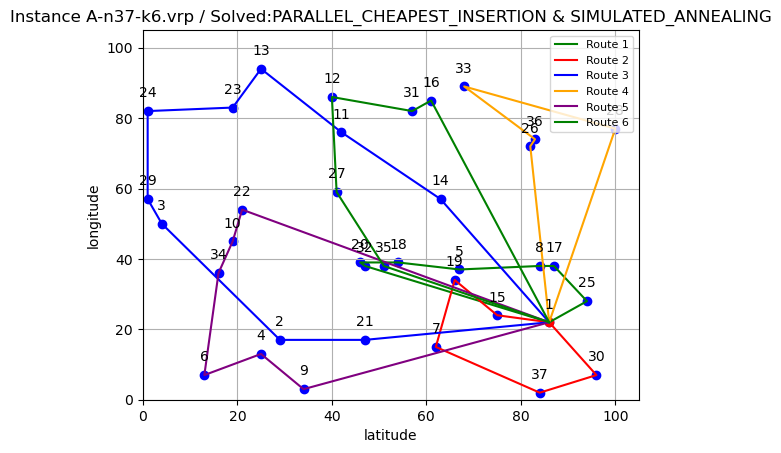

Local Search: TABU_SEARCH
Objective: 979
Route for vehicle 1:
 1 Load(0) ->  8 Load(12) ->  17 Load(29) ->  25 Load(47) ->  30 Load(65) ->  37 Load(86) ->  0 Load(86)
Distance of the route: 85m
Load of the route: 86

Route for vehicle 2:
 1 Load(0) ->  27 Load(20) ->  11 Load(39) ->  12 Load(55) ->  31 Load(81) ->  16 Load(100) ->  0 Load(100)
Distance of the route: 175m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  5 Load(5) ->  18 Load(19) ->  35 Load(38) ->  20 Load(48) ->  32 Load(69) ->  19 Load(77) ->  15 Load(90) ->  0 Load(90)
Distance of the route: 89m
Load of the route: 90

Route for vehicle 4:
 1 Load(0) ->  26 Load(4) ->  36 Load(70) ->  33 Load(91) ->  28 Load(99) ->  0 Load(99)
Distance of the route: 164m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  7 Load(18) ->  21 Load(23) ->  2 Load(24) ->  34 Load(32) ->  10 Load(51) ->  22 Load(70) ->  14 Load(96) ->  0 Load(96)
Distance of the route: 183m
Load of the route: 96

Route for vehicle 6:
 1 Lo

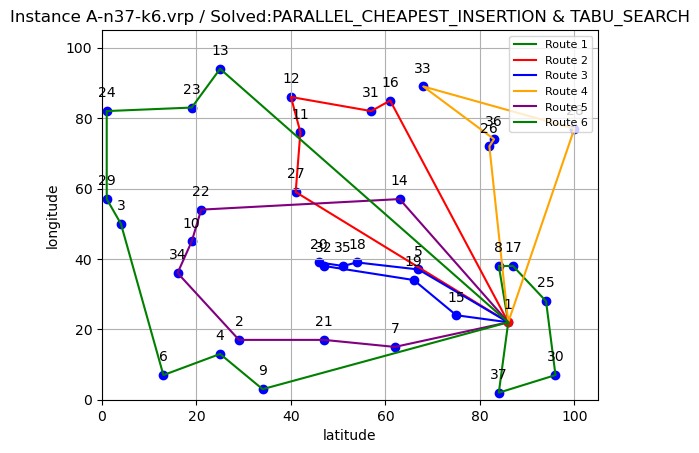

Local Search: GUIDED_LOCAL_SEARCH
Objective: 1055
Route for vehicle 1:
 1 Load(0) ->  8 Load(12) ->  17 Load(29) ->  25 Load(47) ->  30 Load(65) ->  37 Load(86) ->  0 Load(86)
Distance of the route: 85m
Load of the route: 86

Route for vehicle 2:
 1 Load(0) ->  7 Load(18) ->  21 Load(23) ->  2 Load(24) ->  34 Load(32) ->  10 Load(51) ->  12 Load(67) ->  33 Load(88) ->  28 Load(96) ->  0 Load(96)
Distance of the route: 255m
Load of the route: 96

Route for vehicle 3:
 1 Load(0) ->  19 Load(8) ->  18 Load(22) ->  35 Load(41) ->  32 Load(62) ->  20 Load(72) ->  22 Load(91) ->  5 Load(96) ->  0 Load(96)
Distance of the route: 146m
Load of the route: 96

Route for vehicle 4:
 1 Load(0) ->  9 Load(20) ->  4 Load(43) ->  6 Load(50) ->  3 Load(73) ->  29 Load(76) ->  24 Load(85) ->  23 Load(97) ->  13 Load(99) ->  0 Load(99)
Distance of the route: 283m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  26 Load(4) ->  36 Load(70) ->  14 Load(96) ->  0 Load(96)
Distance of the route: 120

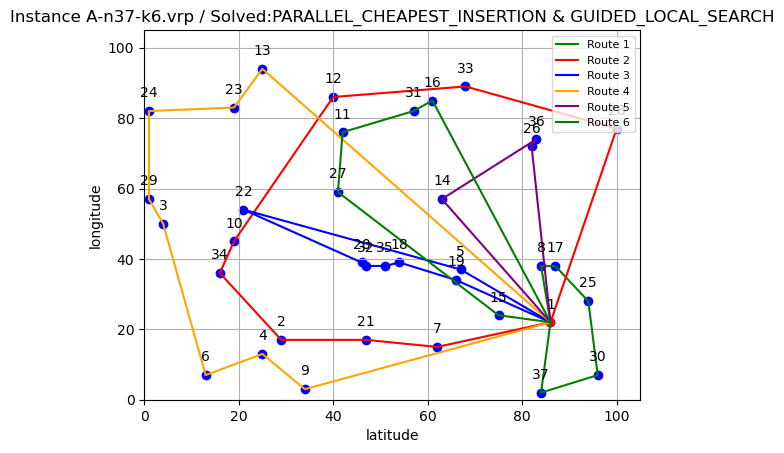

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 1044
Route for vehicle 1:
 1 Load(0) ->  19 Load(8) ->  32 Load(29) ->  20 Load(39) ->  18 Load(53) ->  8 Load(65) ->  17 Load(82) ->  25 Load(100) ->  0 Load(100)
Distance of the route: 106m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  30 Load(18) ->  37 Load(39) ->  7 Load(57) ->  35 Load(76) ->  0 Load(76)
Distance of the route: 120m
Load of the route: 76

Route for vehicle 3:
 1 Load(0) ->  15 Load(13) ->  21 Load(18) ->  2 Load(19) ->  3 Load(42) ->  29 Load(45) ->  24 Load(54) ->  11 Load(73) ->  14 Load(99) ->  0 Load(99)
Distance of the route: 243m
Load of the route: 99

Route for vehicle 4:
 1 Load(0) ->  26 Load(4) ->  36 Load(70) ->  33 Load(91) ->  28 Load(99) ->  0 Load(99)
Distance of the route: 164m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  9 Load(20) ->  4 Load(43) ->  6 Load(50) ->  34 Load(58) ->  10 Load(77) ->  22 Load(96) ->  0 Load(96)
Distance of the route: 200m
Load of

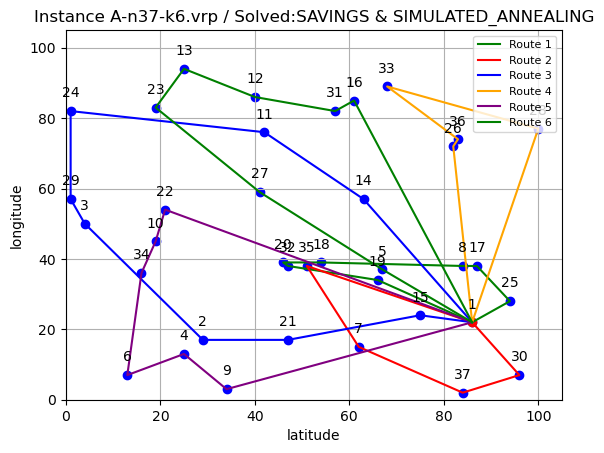

Local Search: TABU_SEARCH
Objective: 1028
Route for vehicle 1:
 1 Load(0) ->  8 Load(12) ->  17 Load(29) ->  25 Load(47) ->  30 Load(65) ->  37 Load(86) ->  0 Load(86)
Distance of the route: 85m
Load of the route: 86

Route for vehicle 2:
 1 Load(0) ->  15 Load(13) ->  19 Load(21) ->  18 Load(35) ->  35 Load(54) ->  32 Load(75) ->  7 Load(93) ->  0 Load(93)
Distance of the route: 96m
Load of the route: 93

Route for vehicle 3:
 1 Load(0) ->  14 Load(26) ->  12 Load(42) ->  11 Load(61) ->  27 Load(81) ->  34 Load(89) ->  20 Load(99) ->  0 Load(99)
Distance of the route: 213m
Load of the route: 99

Route for vehicle 4:
 1 Load(0) ->  26 Load(4) ->  36 Load(70) ->  33 Load(91) ->  28 Load(99) ->  0 Load(99)
Distance of the route: 164m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  9 Load(20) ->  4 Load(43) ->  6 Load(50) ->  10 Load(69) ->  22 Load(88) ->  5 Load(93) ->  0 Load(93)
Distance of the route: 201m
Load of the route: 93

Route for vehicle 6:
 1 Load(0) ->  21 Load(5

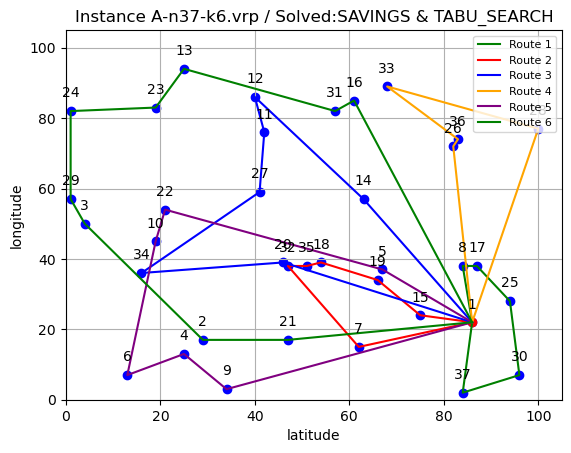

Local Search: GUIDED_LOCAL_SEARCH
Objective: 1055
Route for vehicle 1:
 1 Load(0) ->  8 Load(12) ->  17 Load(29) ->  25 Load(47) ->  30 Load(65) ->  37 Load(86) ->  0 Load(86)
Distance of the route: 85m
Load of the route: 86

Route for vehicle 2:
 1 Load(0) ->  7 Load(18) ->  21 Load(23) ->  2 Load(24) ->  34 Load(32) ->  10 Load(51) ->  12 Load(67) ->  33 Load(88) ->  28 Load(96) ->  0 Load(96)
Distance of the route: 255m
Load of the route: 96

Route for vehicle 3:
 1 Load(0) ->  19 Load(8) ->  18 Load(22) ->  35 Load(41) ->  32 Load(62) ->  20 Load(72) ->  22 Load(91) ->  5 Load(96) ->  0 Load(96)
Distance of the route: 146m
Load of the route: 96

Route for vehicle 4:
 1 Load(0) ->  9 Load(20) ->  4 Load(43) ->  6 Load(50) ->  3 Load(73) ->  29 Load(76) ->  24 Load(85) ->  23 Load(97) ->  13 Load(99) ->  0 Load(99)
Distance of the route: 283m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  26 Load(4) ->  36 Load(70) ->  14 Load(96) ->  0 Load(96)
Distance of the route: 120

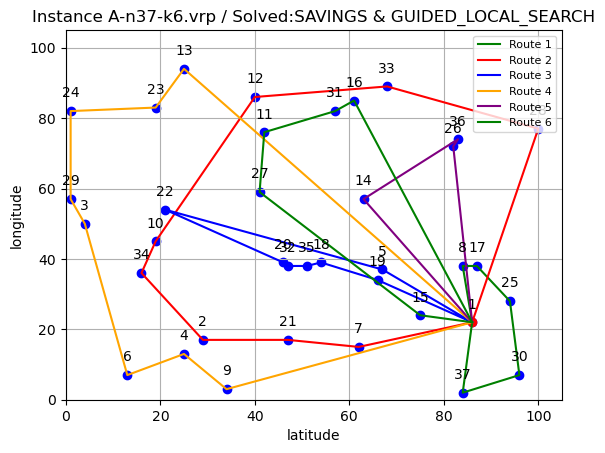

SOLVED INSTANCE: A-n37-k6.vrp
Soluzione ottima: 949
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 1005
Gap: 5.900948366701791%
Tempo di esecuzione: 1.9999992847442627s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 979
Gap: 3.1612223393045316%
Tempo di esecuzione: 2.0009701251983643s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 1055
Gap: 11.169652265542677%
Tempo di esecuzione: 1.9990041255950928s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 1044
Gap: 10.010537407797681%
Tempo di esecuzione: 1.9989681243896484s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 1028
Gap: 8.324552

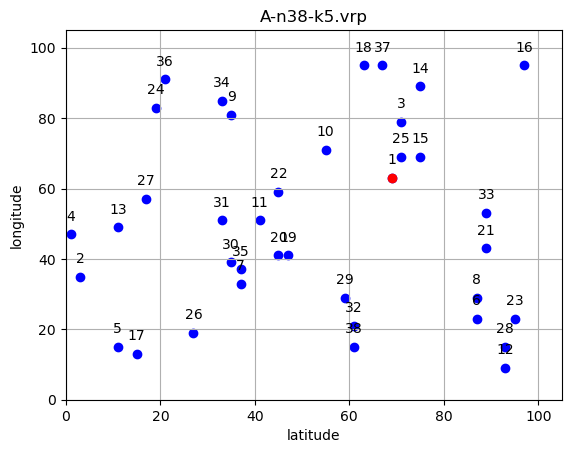

Soluzione ottima: 730
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 820
Route for vehicle 1:
 1 Load(0) ->  25 Load(8) ->  3 Load(13) ->  16 Load(26) ->  14 Load(31) ->  37 Load(45) ->  18 Load(58) ->  9 Load(77) ->  10 Load(100) ->  0 Load(100)
Distance of the route: 153m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  15 Load(17) ->  33 Load(20) ->  23 Load(40) ->  28 Load(52) ->  12 Load(77) ->  6 Load(95) ->  0 Load(95)
Distance of the route: 133m
Load of the route: 95

Route for vehicle 3:
 1 Load(0) ->  22 Load(9) ->  31 Load(34) ->  27 Load(47) ->  13 Load(48) ->  4 Load(56) ->  24 Load(77) ->  36 Load(90) ->  34 Load(92) ->  0 Load(92)
Distance of the route: 178m
Load of the route: 92

Route for vehicle 4:
 1 Load(0) ->  19 Load(19) ->  20 Load(24) ->  26 Load(36) ->  7 Load(48) ->  35 Load(72) ->  30 Load(91) ->  11 Load(99) ->  0 Load(99)
Distance of the route: 128m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  21 

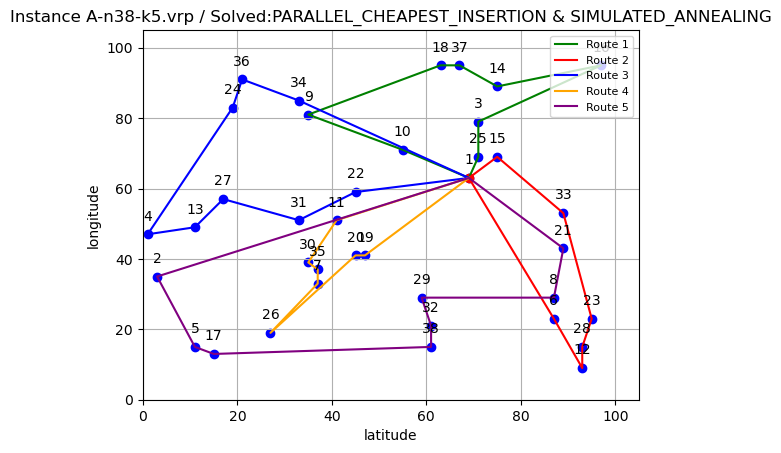

Local Search: TABU_SEARCH
Objective: 853
Route for vehicle 1:
 1 Load(0) ->  25 Load(8) ->  15 Load(25) ->  3 Load(30) ->  14 Load(35) ->  37 Load(49) ->  18 Load(62) ->  34 Load(64) ->  22 Load(73) ->  10 Load(96) ->  0 Load(96)
Distance of the route: 139m
Load of the route: 96

Route for vehicle 2:
 1 Load(0) ->  6 Load(18) ->  12 Load(43) ->  28 Load(55) ->  23 Load(75) ->  8 Load(86) ->  0 Load(86)
Distance of the route: 121m
Load of the route: 86

Route for vehicle 3:
 1 Load(0) ->  19 Load(19) ->  20 Load(24) ->  7 Load(36) ->  26 Load(48) ->  35 Load(72) ->  30 Load(91) ->  11 Load(99) ->  0 Load(99)
Distance of the route: 128m
Load of the route: 99

Route for vehicle 4:
 1 Load(0) ->  9 Load(19) ->  36 Load(32) ->  24 Load(53) ->  4 Load(61) ->  13 Load(62) ->  27 Load(75) ->  31 Load(100) ->  0 Load(100)
Distance of the route: 178m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  16 Load(13) ->  33 Load(16) ->  21 Load(42) ->  29 Load(46) ->  32 Load(53) ->  38 Load

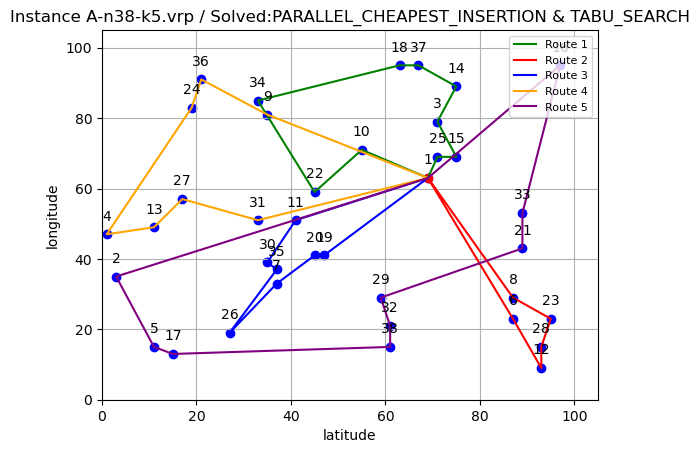

Local Search: GUIDED_LOCAL_SEARCH
Objective: 832
Route for vehicle 1:
 1 Load(0) ->  9 Load(19) ->  34 Load(21) ->  36 Load(34) ->  24 Load(55) ->  27 Load(68) ->  4 Load(76) ->  13 Load(77) ->  11 Load(85) ->  22 Load(94) ->  0 Load(94)
Distance of the route: 181m
Load of the route: 94

Route for vehicle 2:
 1 Load(0) ->  19 Load(19) ->  20 Load(24) ->  30 Load(43) ->  35 Load(67) ->  7 Load(79) ->  32 Load(86) ->  29 Load(90) ->  0 Load(90)
Distance of the route: 120m
Load of the route: 90

Route for vehicle 3:
 1 Load(0) ->  6 Load(18) ->  12 Load(43) ->  28 Load(55) ->  23 Load(75) ->  15 Load(92) ->  25 Load(100) ->  0 Load(100)
Distance of the route: 133m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  3 Load(5) ->  16 Load(18) ->  14 Load(23) ->  37 Load(37) ->  18 Load(50) ->  10 Load(73) ->  31 Load(98) ->  0 Load(98)
Distance of the route: 177m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  33 Load(3) ->  21 Load(29) ->  8 Load(40) ->  38 Load(54) ->  

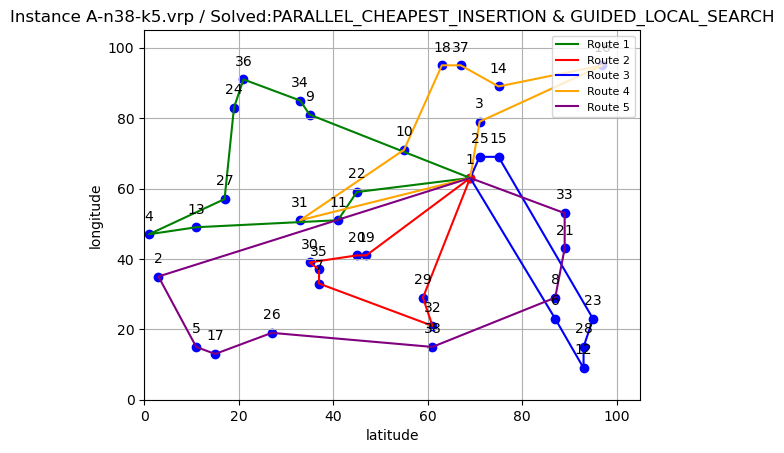

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 869
Route for vehicle 1:
 1 Load(0) ->  25 Load(8) ->  3 Load(13) ->  16 Load(26) ->  14 Load(31) ->  37 Load(45) ->  18 Load(58) ->  9 Load(77) ->  4 Load(85) ->  13 Load(86) ->  22 Load(95) ->  0 Load(95)
Distance of the route: 232m
Load of the route: 95

Route for vehicle 2:
 1 Load(0) ->  8 Load(11) ->  6 Load(29) ->  23 Load(49) ->  28 Load(61) ->  12 Load(86) ->  29 Load(90) ->  0 Load(90)
Distance of the route: 140m
Load of the route: 90

Route for vehicle 3:
 1 Load(0) ->  19 Load(19) ->  20 Load(24) ->  7 Load(36) ->  26 Load(48) ->  35 Load(72) ->  30 Load(91) ->  11 Load(99) ->  0 Load(99)
Distance of the route: 128m
Load of the route: 99

Route for vehicle 4:
 1 Load(0) ->  10 Load(23) ->  34 Load(25) ->  36 Load(38) ->  24 Load(59) ->  27 Load(72) ->  31 Load(97) ->  0 Load(97)
Distance of the route: 144m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  15 Load(17) ->  33 Load(20) ->  21 Load(46) ->  

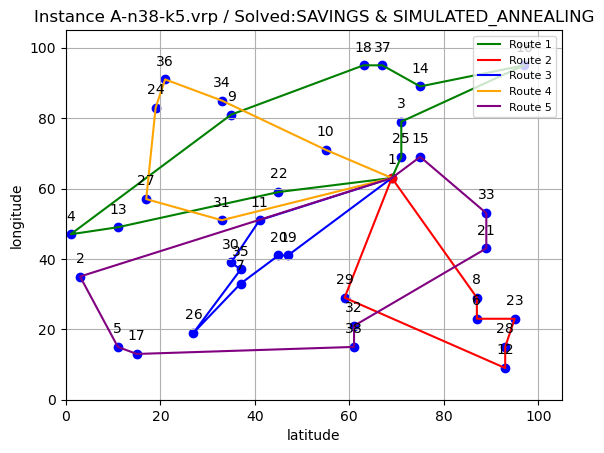

Local Search: TABU_SEARCH
Objective: 799
Route for vehicle 1:
 1 Load(0) ->  25 Load(8) ->  3 Load(13) ->  16 Load(26) ->  14 Load(31) ->  37 Load(45) ->  18 Load(58) ->  10 Load(81) ->  22 Load(90) ->  11 Load(98) ->  0 Load(98)
Distance of the route: 164m
Load of the route: 98

Route for vehicle 2:
 1 Load(0) ->  21 Load(26) ->  23 Load(46) ->  12 Load(71) ->  28 Load(83) ->  8 Load(94) ->  0 Load(94)
Distance of the route: 122m
Load of the route: 94

Route for vehicle 3:
 1 Load(0) ->  29 Load(4) ->  38 Load(18) ->  7 Load(30) ->  35 Load(54) ->  30 Load(73) ->  20 Load(78) ->  19 Load(97) ->  0 Load(97)
Distance of the route: 129m
Load of the route: 97

Route for vehicle 4:
 1 Load(0) ->  9 Load(19) ->  34 Load(21) ->  36 Load(34) ->  24 Load(55) ->  27 Load(68) ->  31 Load(93) ->  0 Load(93)
Distance of the route: 144m
Load of the route: 93

Route for vehicle 5:
 1 Load(0) ->  15 Load(17) ->  33 Load(20) ->  6 Load(38) ->  32 Load(45) ->  26 Load(57) ->  17 Load(66) ->  5 Load(78)

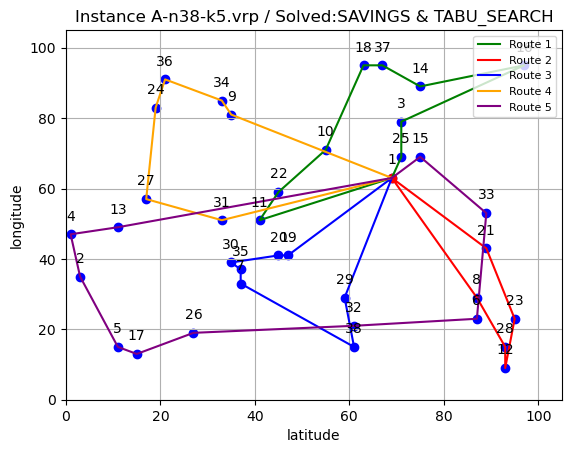

Local Search: GUIDED_LOCAL_SEARCH
Objective: 791
Route for vehicle 1:
 1 Load(0) ->  10 Load(23) ->  34 Load(25) ->  18 Load(38) ->  37 Load(52) ->  14 Load(57) ->  16 Load(70) ->  3 Load(75) ->  15 Load(92) ->  25 Load(100) ->  0 Load(100)
Distance of the route: 163m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  33 Load(3) ->  21 Load(29) ->  23 Load(49) ->  28 Load(61) ->  12 Load(86) ->  8 Load(97) ->  0 Load(97)
Distance of the route: 126m
Load of the route: 97

Route for vehicle 3:
 1 Load(0) ->  11 Load(8) ->  30 Load(27) ->  35 Load(51) ->  7 Load(63) ->  20 Load(68) ->  19 Load(87) ->  0 Load(87)
Distance of the route: 94m
Load of the route: 87

Route for vehicle 4:
 1 Load(0) ->  9 Load(19) ->  36 Load(32) ->  24 Load(53) ->  4 Load(61) ->  13 Load(62) ->  27 Load(75) ->  31 Load(100) ->  0 Load(100)
Distance of the route: 178m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  6 Load(18) ->  38 Load(32) ->  32 Load(39) ->  29 Load(43) ->  26 Load(55) ->

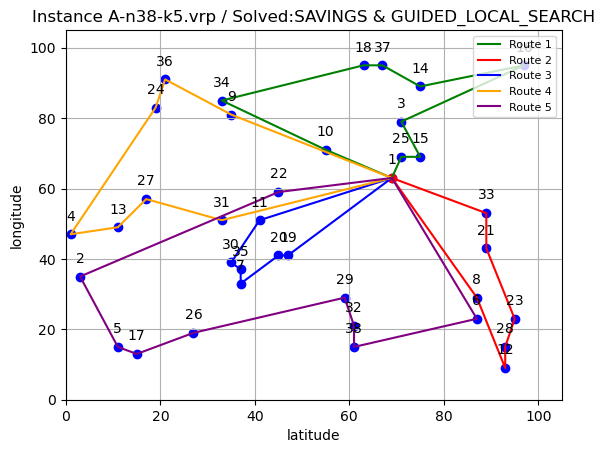

SOLVED INSTANCE: A-n38-k5.vrp
Soluzione ottima: 730
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 820
Gap: 12.32876712328767%
Tempo di esecuzione: 1.999997854232788s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 853
Gap: 16.84931506849315%
Tempo di esecuzione: 2.0009703636169434s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 832
Gap: 13.972602739726028%
Tempo di esecuzione: 1.9999620914459229s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 869
Gap: 19.041095890410958%
Tempo di esecuzione: 1.999997615814209s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 799
Gap: 9.4520547945205

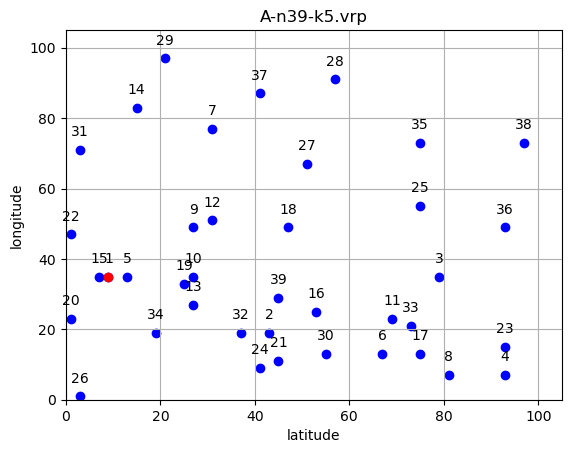

Soluzione ottima: 822
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 906
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  10 Load(41) ->  19 Load(54) ->  5 Load(74) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 51m
Load of the route: 98

Route for vehicle 2:
 1 Load(0) ->  20 Load(5) ->  26 Load(15) ->  34 Load(22) ->  24 Load(38) ->  21 Load(41) ->  30 Load(47) ->  16 Load(61) ->  39 Load(68) ->  12 Load(77) ->  9 Load(80) ->  0 Load(80)
Distance of the route: 172m
Load of the route: 80

Route for vehicle 3:
 1 Load(0) ->  22 Load(3) ->  31 Load(4) ->  14 Load(7) ->  29 Load(31) ->  7 Load(54) ->  37 Load(73) ->  35 Load(79) ->  27 Load(91) ->  18 Load(97) ->  0 Load(97)
Distance of the route: 226m
Load of the route: 97

Route for vehicle 4:
 1 Load(0) ->  32 Load(2) ->  2 Load(7) ->  6 Load(33) ->  8 Load(48) ->  4 Load(51) ->  23 Load(71) ->  33 Load(84) ->  11 Load(100) ->  0 Load(100)
Distance of the route: 184m
Load of the route: 100

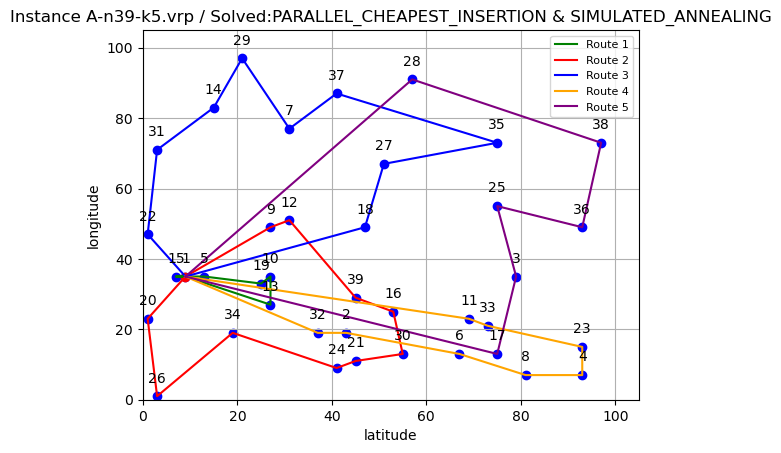

Local Search: TABU_SEARCH
Objective: 858
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  10 Load(41) ->  19 Load(54) ->  5 Load(74) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 51m
Load of the route: 98

Route for vehicle 2:
 1 Load(0) ->  22 Load(3) ->  31 Load(4) ->  14 Load(7) ->  29 Load(31) ->  37 Load(50) ->  28 Load(70) ->  27 Load(82) ->  12 Load(91) ->  9 Load(94) ->  0 Load(94)
Distance of the route: 186m
Load of the route: 94

Route for vehicle 3:
 1 Load(0) ->  20 Load(5) ->  26 Load(15) ->  24 Load(31) ->  21 Load(34) ->  30 Load(40) ->  3 Load(64) ->  16 Load(78) ->  39 Load(85) ->  2 Load(90) ->  32 Load(92) ->  34 Load(99) ->  0 Load(99)
Distance of the route: 212m
Load of the route: 99

Route for vehicle 4:
 1 Load(0) ->  11 Load(16) ->  33 Load(29) ->  23 Load(49) ->  4 Load(52) ->  8 Load(67) ->  17 Load(73) ->  6 Load(99) ->  0 Load(99)
Distance of the route: 184m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  7 Load(23) ->  35 Load(29) ->  

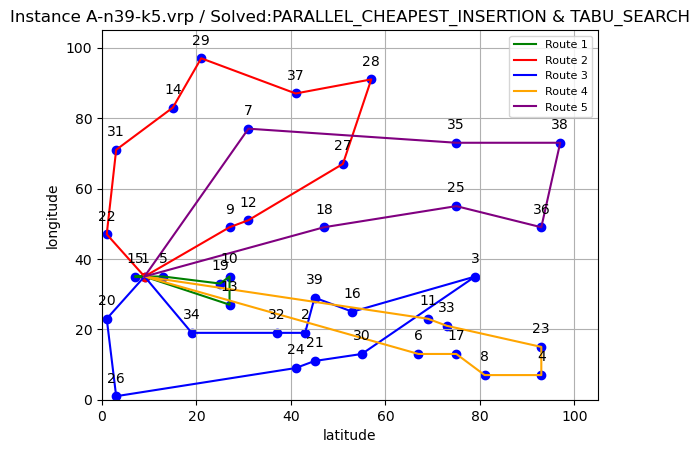

Local Search: GUIDED_LOCAL_SEARCH
Objective: 891
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  10 Load(41) ->  19 Load(54) ->  5 Load(74) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 51m
Load of the route: 98

Route for vehicle 2:
 1 Load(0) ->  20 Load(5) ->  26 Load(15) ->  34 Load(22) ->  24 Load(38) ->  21 Load(41) ->  30 Load(47) ->  16 Load(61) ->  39 Load(68) ->  12 Load(77) ->  9 Load(80) ->  0 Load(80)
Distance of the route: 172m
Load of the route: 80

Route for vehicle 3:
 1 Load(0) ->  22 Load(3) ->  31 Load(4) ->  14 Load(7) ->  29 Load(31) ->  37 Load(50) ->  28 Load(70) ->  38 Load(74) ->  35 Load(80) ->  27 Load(92) ->  18 Load(98) ->  0 Load(98)
Distance of the route: 257m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  11 Load(16) ->  33 Load(29) ->  23 Load(49) ->  4 Load(52) ->  8 Load(67) ->  6 Load(93) ->  2 Load(98) ->  32 Load(100) ->  0 Load(100)
Distance of the route: 184m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  7 L

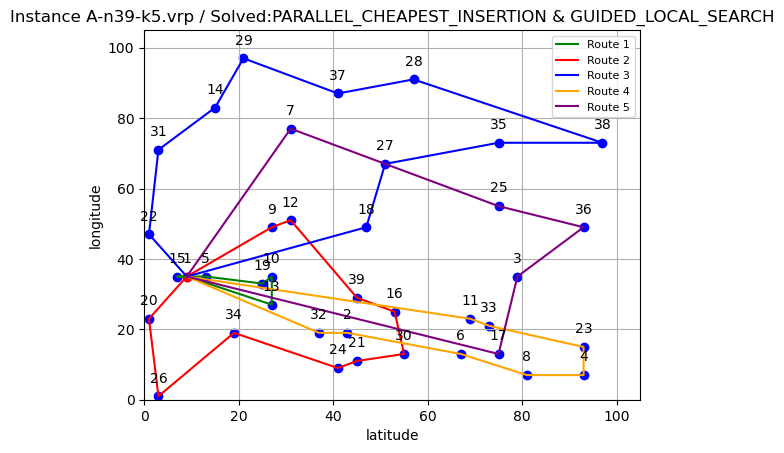

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 880
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  10 Load(41) ->  19 Load(54) ->  5 Load(74) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 51m
Load of the route: 98

Route for vehicle 2:
 1 Load(0) ->  20 Load(5) ->  26 Load(15) ->  34 Load(22) ->  24 Load(38) ->  21 Load(41) ->  30 Load(47) ->  17 Load(53) ->  16 Load(67) ->  39 Load(74) ->  12 Load(83) ->  9 Load(86) ->  0 Load(86)
Distance of the route: 205m
Load of the route: 86

Route for vehicle 3:
 1 Load(0) ->  22 Load(3) ->  31 Load(4) ->  14 Load(7) ->  29 Load(31) ->  37 Load(50) ->  7 Load(73) ->  27 Load(85) ->  18 Load(91) ->  0 Load(91)
Distance of the route: 186m
Load of the route: 91

Route for vehicle 4:
 1 Load(0) ->  11 Load(16) ->  33 Load(29) ->  23 Load(49) ->  4 Load(52) ->  8 Load(67) ->  6 Load(93) ->  2 Load(98) ->  32 Load(100) ->  0 Load(100)
Distance of the route: 184m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  28

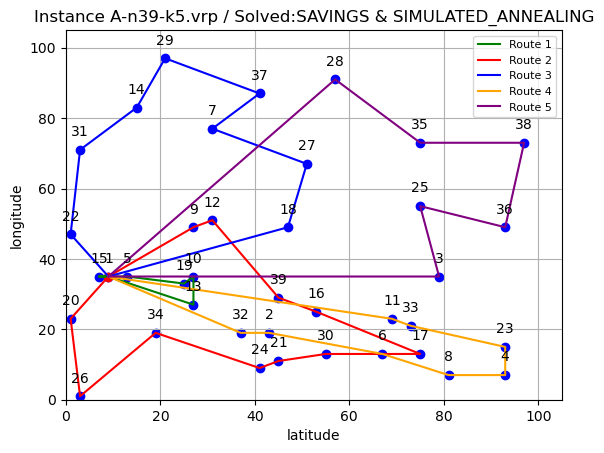

Local Search: TABU_SEARCH
Objective: 906
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  10 Load(41) ->  19 Load(54) ->  5 Load(74) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 51m
Load of the route: 98

Route for vehicle 2:
 1 Load(0) ->  20 Load(5) ->  26 Load(15) ->  34 Load(22) ->  24 Load(38) ->  21 Load(41) ->  30 Load(47) ->  16 Load(61) ->  39 Load(68) ->  12 Load(77) ->  9 Load(80) ->  0 Load(80)
Distance of the route: 172m
Load of the route: 80

Route for vehicle 3:
 1 Load(0) ->  22 Load(3) ->  31 Load(4) ->  14 Load(7) ->  29 Load(31) ->  7 Load(54) ->  37 Load(73) ->  35 Load(79) ->  27 Load(91) ->  18 Load(97) ->  0 Load(97)
Distance of the route: 226m
Load of the route: 97

Route for vehicle 4:
 1 Load(0) ->  32 Load(2) ->  2 Load(7) ->  6 Load(33) ->  8 Load(48) ->  4 Load(51) ->  23 Load(71) ->  33 Load(84) ->  11 Load(100) ->  0 Load(100)
Distance of the route: 184m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  28 Load(20) ->  38 Load(24) ->

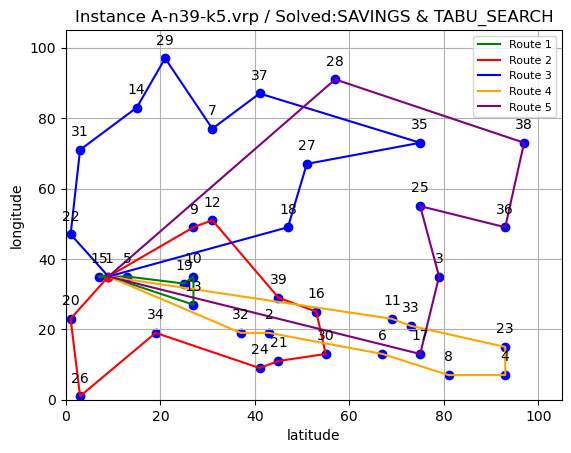

Local Search: GUIDED_LOCAL_SEARCH
Objective: 906
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  10 Load(41) ->  19 Load(54) ->  5 Load(74) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 51m
Load of the route: 98

Route for vehicle 2:
 1 Load(0) ->  20 Load(5) ->  26 Load(15) ->  34 Load(22) ->  24 Load(38) ->  21 Load(41) ->  30 Load(47) ->  16 Load(61) ->  39 Load(68) ->  12 Load(77) ->  9 Load(80) ->  0 Load(80)
Distance of the route: 172m
Load of the route: 80

Route for vehicle 3:
 1 Load(0) ->  22 Load(3) ->  31 Load(4) ->  14 Load(7) ->  29 Load(31) ->  7 Load(54) ->  37 Load(73) ->  35 Load(79) ->  27 Load(91) ->  18 Load(97) ->  0 Load(97)
Distance of the route: 226m
Load of the route: 97

Route for vehicle 4:
 1 Load(0) ->  11 Load(16) ->  33 Load(29) ->  23 Load(49) ->  4 Load(52) ->  8 Load(67) ->  6 Load(93) ->  2 Load(98) ->  32 Load(100) ->  0 Load(100)
Distance of the route: 184m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  28 Load(20) ->  38 L

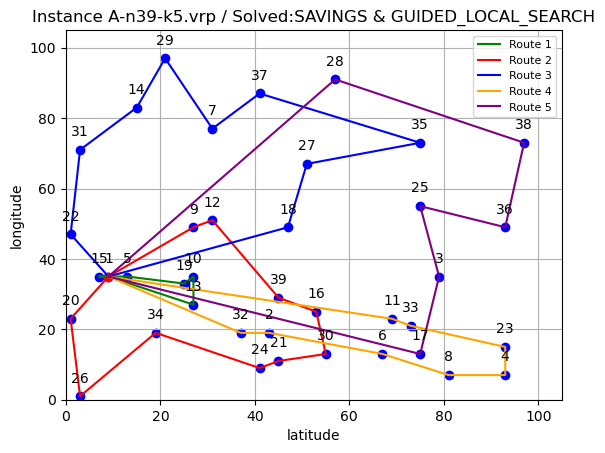

SOLVED INSTANCE: A-n39-k5.vrp
Soluzione ottima: 822
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 906
Gap: 10.218978102189782%
Tempo di esecuzione: 2.0013937950134277s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 858
Gap: 4.37956204379562%
Tempo di esecuzione: 1.9999780654907227s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 891
Gap: 8.394160583941606%
Tempo di esecuzione: 2.00099778175354s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 880
Gap: 7.0559610705596105%
Tempo di esecuzione: 2.0010359287261963s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 906
Gap: 10.2189781021897

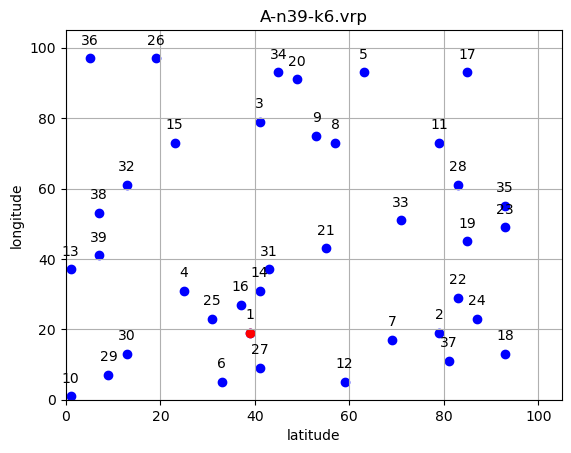

Soluzione ottima: 831
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 920
Route for vehicle 1:
 1 Load(0) ->  27 Load(15) ->  6 Load(18) ->  25 Load(40) ->  0 Load(40)
Distance of the route: 46m
Load of the route: 40

Route for vehicle 2:
 1 Load(0) ->  14 Load(72) ->  24 Load(73) ->  18 Load(77) ->  7 Load(96) ->  0 Load(96)
Distance of the route: 125m
Load of the route: 96

Route for vehicle 3:
 1 Load(0) ->  30 Load(22) ->  29 Load(27) ->  10 Load(33) ->  13 Load(49) ->  39 Load(51) ->  38 Load(61) ->  32 Load(71) ->  15 Load(78) ->  4 Load(100) ->  0 Load(100)
Distance of the route: 185m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  19 Load(22) ->  35 Load(25) ->  23 Load(36) ->  22 Load(47) ->  2 Load(65) ->  37 Load(80) ->  12 Load(98) ->  0 Load(98)
Distance of the route: 160m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  16 Load(16) ->  36 Load(23) ->  26 Load(39) ->  34 Load(48) ->  20 Load(71) ->  3 Load(87) ->  31

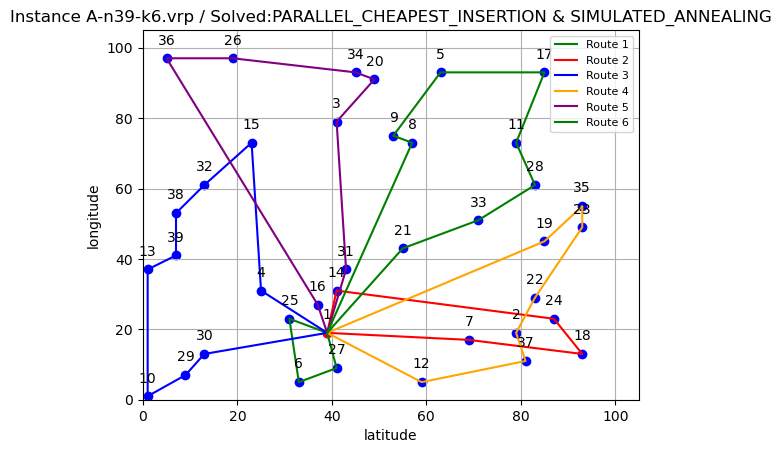

Local Search: TABU_SEARCH
Objective: 925
Route for vehicle 1:
 1 Load(0) ->  25 Load(22) ->  16 Load(38) ->  0 Load(38)
Distance of the route: 24m
Load of the route: 38

Route for vehicle 2:
 1 Load(0) ->  19 Load(22) ->  23 Load(33) ->  22 Load(44) ->  2 Load(62) ->  7 Load(81) ->  12 Load(99) ->  0 Load(99)
Distance of the route: 145m
Load of the route: 99

Route for vehicle 3:
 1 Load(0) ->  4 Load(22) ->  15 Load(29) ->  36 Load(36) ->  26 Load(52) ->  34 Load(61) ->  20 Load(84) ->  3 Load(100) ->  0 Load(100)
Distance of the route: 208m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  33 Load(11) ->  5 Load(35) ->  17 Load(58) ->  11 Load(70) ->  28 Load(77) ->  35 Load(80) ->  24 Load(81) ->  18 Load(85) ->  37 Load(100) ->  0 Load(100)
Distance of the route: 256m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  14 Load(72) ->  31 Load(81) ->  9 Load(87) ->  8 Load(93) ->  21 Load(100) ->  0 Load(100)
Distance of the route: 120m
Load of the route: 100

Rout

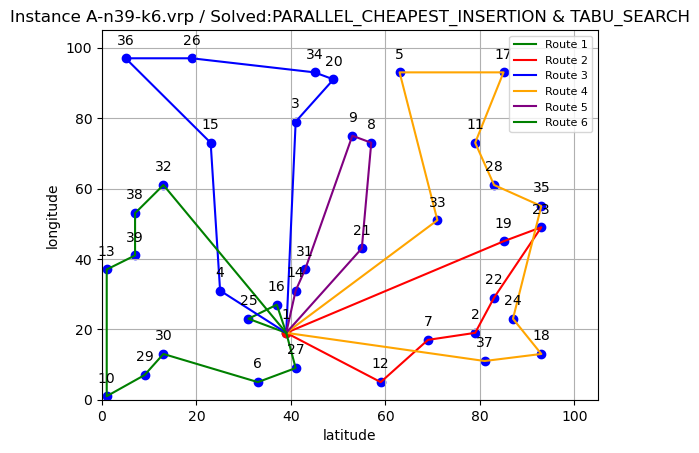

Local Search: GUIDED_LOCAL_SEARCH
Objective: 885
Route for vehicle 1:
 1 Load(0) ->  14 Load(72) ->  16 Load(88) ->  0 Load(88)
Distance of the route: 26m
Load of the route: 88

Route for vehicle 2:
 1 Load(0) ->  19 Load(22) ->  22 Load(33) ->  2 Load(51) ->  7 Load(70) ->  12 Load(88) ->  0 Load(88)
Distance of the route: 130m
Load of the route: 88

Route for vehicle 3:
 1 Load(0) ->  31 Load(9) ->  8 Load(15) ->  9 Load(21) ->  5 Load(45) ->  20 Load(68) ->  34 Load(77) ->  26 Load(93) ->  36 Load(100) ->  0 Load(100)
Distance of the route: 225m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  21 Load(7) ->  33 Load(18) ->  11 Load(30) ->  17 Load(53) ->  28 Load(60) ->  35 Load(63) ->  23 Load(74) ->  24 Load(75) ->  18 Load(79) ->  37 Load(94) ->  0 Load(94)
Distance of the route: 235m
Load of the route: 94

Route for vehicle 5:
 1 Load(0) ->  27 Load(15) ->  6 Load(18) ->  25 Load(40) ->  4 Load(62) ->  0 Load(62)
Distance of the route: 65m
Load of the route: 62

Route

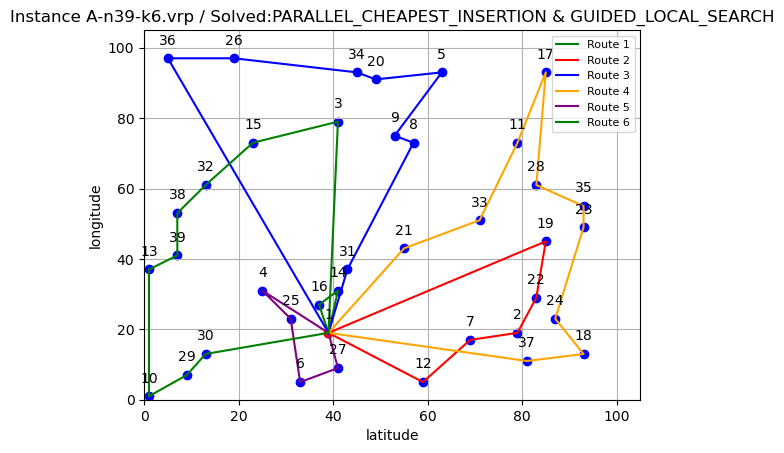

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 925
Route for vehicle 1:
 1 Load(0) ->  25 Load(22) ->  16 Load(38) ->  0 Load(38)
Distance of the route: 24m
Load of the route: 38

Route for vehicle 2:
 1 Load(0) ->  19 Load(22) ->  23 Load(33) ->  22 Load(44) ->  2 Load(62) ->  7 Load(81) ->  12 Load(99) ->  0 Load(99)
Distance of the route: 145m
Load of the route: 99

Route for vehicle 3:
 1 Load(0) ->  4 Load(22) ->  15 Load(29) ->  36 Load(36) ->  26 Load(52) ->  34 Load(61) ->  20 Load(84) ->  3 Load(100) ->  0 Load(100)
Distance of the route: 208m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  33 Load(11) ->  5 Load(35) ->  17 Load(58) ->  11 Load(70) ->  28 Load(77) ->  35 Load(80) ->  24 Load(81) ->  18 Load(85) ->  37 Load(100) ->  0 Load(100)
Distance of the route: 256m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  14 Load(72) ->  31 Load(81) ->  9 Load(87) ->  8 Load(93) ->  21 Load(100) ->  0 Load(100)
Distance of the route: 120m
Lo

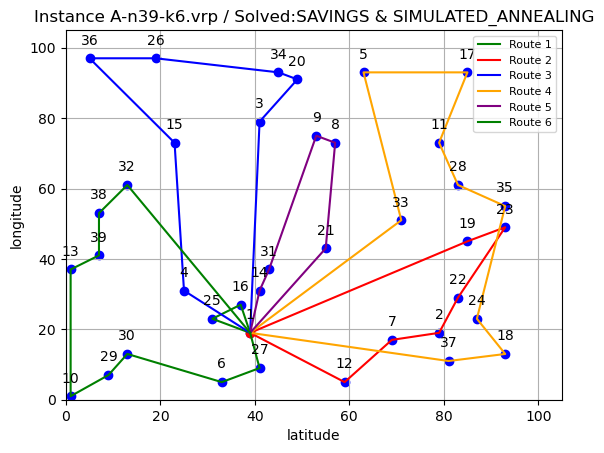

Local Search: TABU_SEARCH
Objective: 881
Route for vehicle 1:
 1 Load(0) ->  14 Load(72) ->  31 Load(81) ->  16 Load(97) ->  0 Load(97)
Distance of the route: 38m
Load of the route: 97

Route for vehicle 2:
 1 Load(0) ->  27 Load(15) ->  12 Load(33) ->  37 Load(48) ->  18 Load(52) ->  24 Load(53) ->  2 Load(71) ->  7 Load(90) ->  0 Load(90)
Distance of the route: 124m
Load of the route: 90

Route for vehicle 3:
 1 Load(0) ->  8 Load(6) ->  9 Load(12) ->  5 Load(36) ->  20 Load(59) ->  34 Load(68) ->  26 Load(84) ->  3 Load(100) ->  0 Load(100)
Distance of the route: 214m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  25 Load(22) ->  4 Load(44) ->  0 Load(44)
Distance of the route: 37m
Load of the route: 44

Route for vehicle 5:
 1 Load(0) ->  33 Load(11) ->  11 Load(23) ->  17 Load(46) ->  28 Load(53) ->  35 Load(56) ->  23 Load(67) ->  19 Load(89) ->  22 Load(100) ->  0 Load(100)
Distance of the route: 209m
Load of the route: 100

Route for vehicle 6:
 1 Load(0) ->  6 Loa

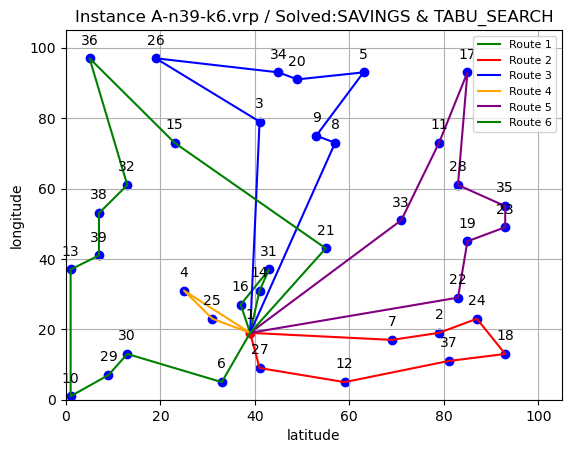

Local Search: GUIDED_LOCAL_SEARCH
Objective: 867
Route for vehicle 1:
 1 Load(0) ->  14 Load(72) ->  16 Load(88) ->  0 Load(88)
Distance of the route: 26m
Load of the route: 88

Route for vehicle 2:
 1 Load(0) ->  33 Load(11) ->  11 Load(23) ->  17 Load(46) ->  28 Load(53) ->  35 Load(56) ->  23 Load(67) ->  24 Load(68) ->  18 Load(72) ->  37 Load(87) ->  0 Load(87)
Distance of the route: 233m
Load of the route: 87

Route for vehicle 3:
 1 Load(0) ->  27 Load(15) ->  6 Load(18) ->  10 Load(24) ->  29 Load(29) ->  30 Load(51) ->  25 Load(73) ->  0 Load(73)
Distance of the route: 98m
Load of the route: 73

Route for vehicle 4:
 1 Load(0) ->  19 Load(22) ->  22 Load(33) ->  2 Load(51) ->  7 Load(70) ->  12 Load(88) ->  0 Load(88)
Distance of the route: 130m
Load of the route: 88

Route for vehicle 5:
 1 Load(0) ->  4 Load(22) ->  13 Load(38) ->  39 Load(40) ->  38 Load(50) ->  32 Load(60) ->  36 Load(67) ->  26 Load(83) ->  15 Load(90) ->  0 Load(90)
Distance of the route: 203m
Load of th

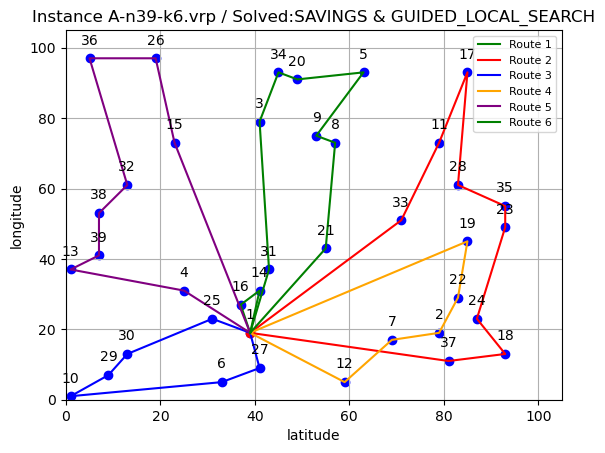

SOLVED INSTANCE: A-n39-k6.vrp
Soluzione ottima: 831
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 920
Gap: 10.709987966305656%
Tempo di esecuzione: 1.9999980926513672s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 925
Gap: 11.311672683513839%
Tempo di esecuzione: 1.9999980926513672s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 885
Gap: 6.4981949458483745%
Tempo di esecuzione: 2.0000338554382324s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 925
Gap: 11.311672683513839%
Tempo di esecuzione: 1.9999938011169434s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 881
Gap: 6.016847172

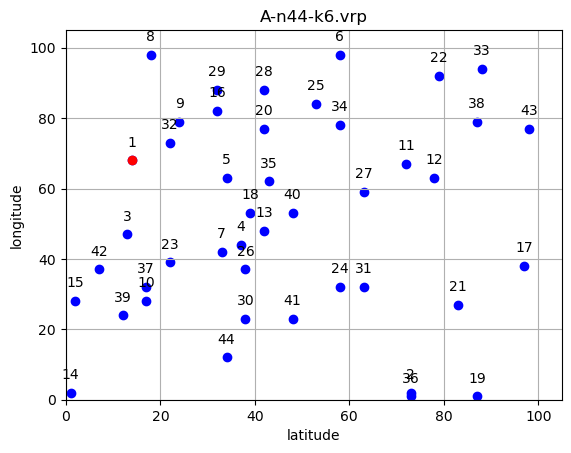

Soluzione ottima: 937
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 985
Route for vehicle 1:
 1 Load(0) ->  8 Load(9) ->  29 Load(23) ->  28 Load(47) ->  16 Load(51) ->  9 Load(65) ->  32 Load(88) ->  0 Load(88)
Distance of the route: 93m
Load of the route: 88

Route for vehicle 2:
 1 Load(0) ->  3 Load(24) ->  42 Load(28) ->  15 Load(46) ->  39 Load(50) ->  10 Load(53) ->  37 Load(71) ->  23 Load(80) ->  7 Load(98) ->  0 Load(98)
Distance of the route: 116m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  5 Load(19) ->  35 Load(33) ->  18 Load(47) ->  13 Load(55) ->  26 Load(79) ->  4 Load(88) ->  0 Load(88)
Distance of the route: 98m
Load of the route: 88

Route for vehicle 4:
 1 Load(0) ->  34 Load(13) ->  25 Load(16) ->  6 Load(25) ->  22 Load(27) ->  33 Load(36) ->  38 Load(60) ->  12 Load(68) ->  11 Load(82) ->  27 Load(90) ->  40 Load(98) ->  0 Load(98)
Distance of the route: 204m
Load of the route: 98

Route for vehicle 5:
 1 Load(

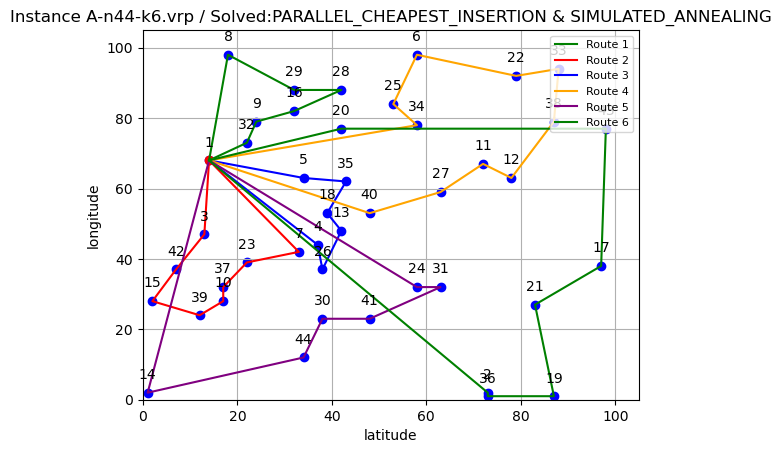

Local Search: TABU_SEARCH
Objective: 985
Route for vehicle 1:
 1 Load(0) ->  32 Load(23) ->  9 Load(37) ->  16 Load(41) ->  28 Load(65) ->  29 Load(79) ->  8 Load(88) ->  0 Load(88)
Distance of the route: 93m
Load of the route: 88

Route for vehicle 2:
 1 Load(0) ->  3 Load(24) ->  42 Load(28) ->  15 Load(46) ->  39 Load(50) ->  10 Load(53) ->  37 Load(71) ->  23 Load(80) ->  7 Load(98) ->  0 Load(98)
Distance of the route: 116m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  5 Load(19) ->  35 Load(33) ->  18 Load(47) ->  13 Load(55) ->  26 Load(79) ->  4 Load(88) ->  0 Load(88)
Distance of the route: 98m
Load of the route: 88

Route for vehicle 4:
 1 Load(0) ->  34 Load(13) ->  25 Load(16) ->  6 Load(25) ->  22 Load(27) ->  33 Load(36) ->  38 Load(60) ->  12 Load(68) ->  11 Load(82) ->  27 Load(90) ->  40 Load(98) ->  0 Load(98)
Distance of the route: 204m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  14 Load(13) ->  44 Load(31) ->  30 Load(44) ->  41 Load(57) 

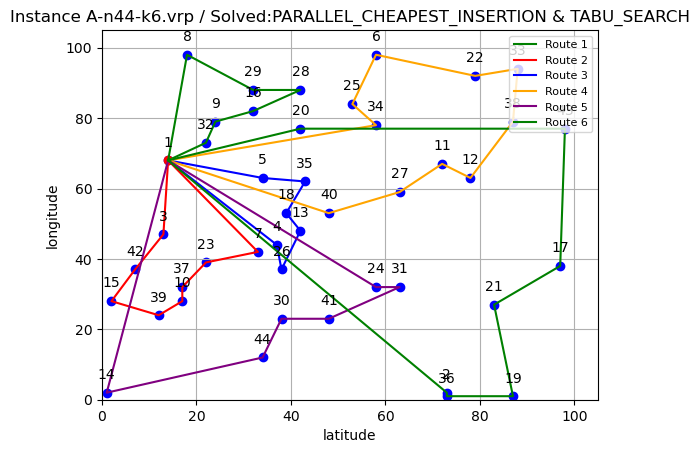

Local Search: GUIDED_LOCAL_SEARCH
Objective: 961
Route for vehicle 1:
 1 Load(0) ->  9 Load(14) ->  29 Load(28) ->  28 Load(52) ->  20 Load(70) ->  32 Load(93) ->  0 Load(93)
Distance of the route: 77m
Load of the route: 93

Route for vehicle 2:
 1 Load(0) ->  3 Load(24) ->  42 Load(28) ->  15 Load(46) ->  39 Load(50) ->  10 Load(53) ->  37 Load(71) ->  23 Load(80) ->  7 Load(98) ->  0 Load(98)
Distance of the route: 116m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  5 Load(19) ->  35 Load(33) ->  40 Load(41) ->  13 Load(49) ->  26 Load(73) ->  4 Load(82) ->  18 Load(96) ->  0 Load(96)
Distance of the route: 105m
Load of the route: 96

Route for vehicle 4:
 1 Load(0) ->  2 Load(8) ->  36 Load(22) ->  19 Load(30) ->  21 Load(43) ->  17 Load(67) ->  12 Load(75) ->  11 Load(89) ->  27 Load(97) ->  0 Load(97)
Distance of the route: 248m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  14 Load(13) ->  44 Load(31) ->  30 Load(44) ->  41 Load(57) ->  31 Load(81) ->  24 

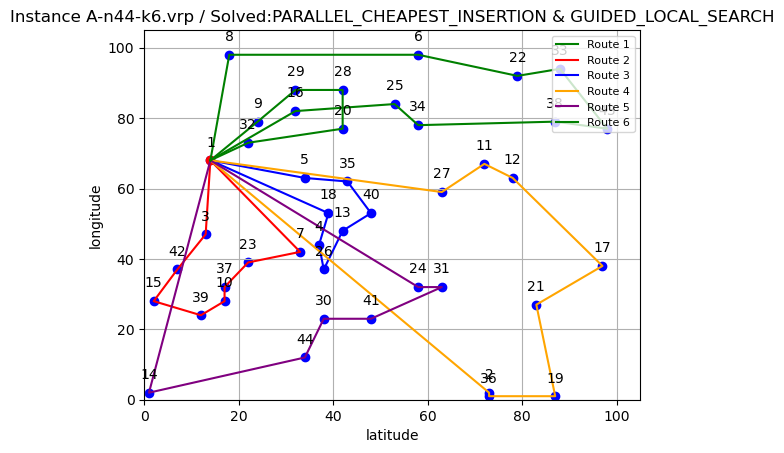

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 971
Route for vehicle 1:
 1 Load(0) ->  9 Load(14) ->  16 Load(18) ->  29 Load(32) ->  28 Load(56) ->  20 Load(74) ->  32 Load(97) ->  0 Load(97)
Distance of the route: 80m
Load of the route: 97

Route for vehicle 2:
 1 Load(0) ->  5 Load(19) ->  18 Load(33) ->  13 Load(41) ->  4 Load(50) ->  26 Load(74) ->  7 Load(92) ->  0 Load(92)
Distance of the route: 90m
Load of the route: 92

Route for vehicle 3:
 1 Load(0) ->  30 Load(13) ->  2 Load(21) ->  36 Load(35) ->  19 Load(43) ->  17 Load(67) ->  12 Load(75) ->  27 Load(83) ->  35 Load(97) ->  0 Load(97)
Distance of the route: 242m
Load of the route: 97

Route for vehicle 4:
 1 Load(0) ->  3 Load(24) ->  42 Load(28) ->  15 Load(46) ->  14 Load(59) ->  39 Load(63) ->  10 Load(66) ->  37 Load(84) ->  23 Load(93) ->  0 Load(93)
Distance of the route: 143m
Load of the route: 93

Route for vehicle 5:
 1 Load(0) ->  44 Load(18) ->  41 Load(31) ->  24 Load(49) ->  31 Load(73) ->  2

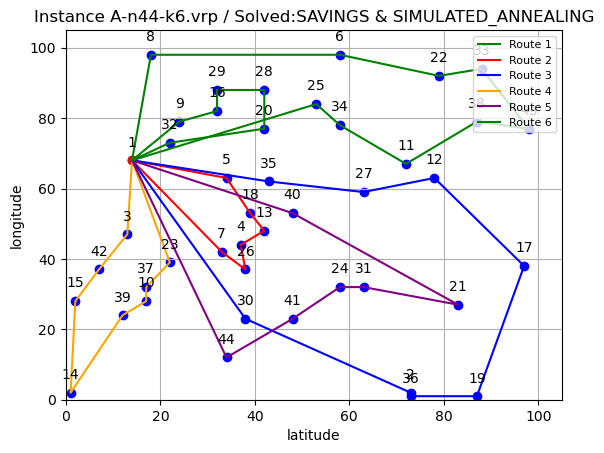

Local Search: TABU_SEARCH
Objective: 948
Route for vehicle 1:
 1 Load(0) ->  32 Load(23) ->  9 Load(37) ->  16 Load(41) ->  28 Load(65) ->  29 Load(79) ->  8 Load(88) ->  0 Load(88)
Distance of the route: 93m
Load of the route: 88

Route for vehicle 2:
 1 Load(0) ->  5 Load(19) ->  35 Load(33) ->  18 Load(47) ->  4 Load(56) ->  26 Load(80) ->  7 Load(98) ->  0 Load(98)
Distance of the route: 95m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  25 Load(3) ->  6 Load(12) ->  22 Load(14) ->  33 Load(23) ->  43 Load(37) ->  38 Load(61) ->  12 Load(69) ->  11 Load(83) ->  27 Load(91) ->  40 Load(99) ->  0 Load(99)
Distance of the route: 209m
Load of the route: 99

Route for vehicle 4:
 1 Load(0) ->  2 Load(8) ->  36 Load(22) ->  19 Load(30) ->  21 Load(43) ->  17 Load(67) ->  34 Load(80) ->  20 Load(98) ->  0 Load(98)
Distance of the route: 249m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  44 Load(18) ->  30 Load(31) ->  41 Load(44) ->  24 Load(62) ->  31 Load(86) ->

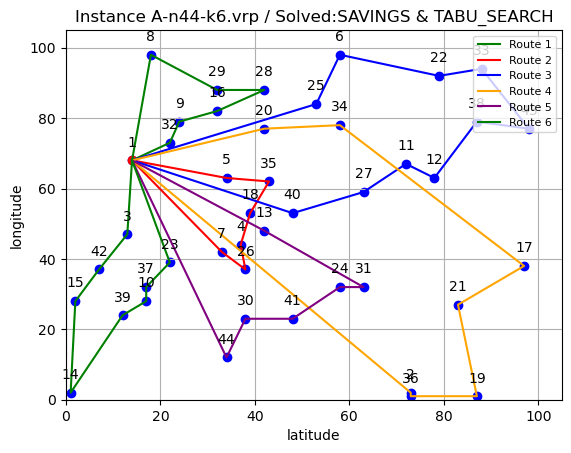

Local Search: GUIDED_LOCAL_SEARCH
Objective: 999
Route for vehicle 1:
 1 Load(0) ->  9 Load(14) ->  29 Load(28) ->  28 Load(52) ->  20 Load(70) ->  32 Load(93) ->  0 Load(93)
Distance of the route: 77m
Load of the route: 93

Route for vehicle 2:
 1 Load(0) ->  3 Load(24) ->  42 Load(28) ->  15 Load(46) ->  39 Load(50) ->  10 Load(53) ->  37 Load(71) ->  23 Load(80) ->  7 Load(98) ->  0 Load(98)
Distance of the route: 116m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  5 Load(19) ->  35 Load(33) ->  18 Load(47) ->  13 Load(55) ->  26 Load(79) ->  4 Load(88) ->  0 Load(88)
Distance of the route: 98m
Load of the route: 88

Route for vehicle 4:
 1 Load(0) ->  8 Load(9) ->  16 Load(13) ->  34 Load(26) ->  6 Load(35) ->  22 Load(37) ->  33 Load(46) ->  38 Load(70) ->  12 Load(78) ->  11 Load(92) ->  27 Load(100) ->  0 Load(100)
Distance of the route: 230m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  14 Load(13) ->  44 Load(31) ->  41 Load(44) ->  24 Load(62) ->  31

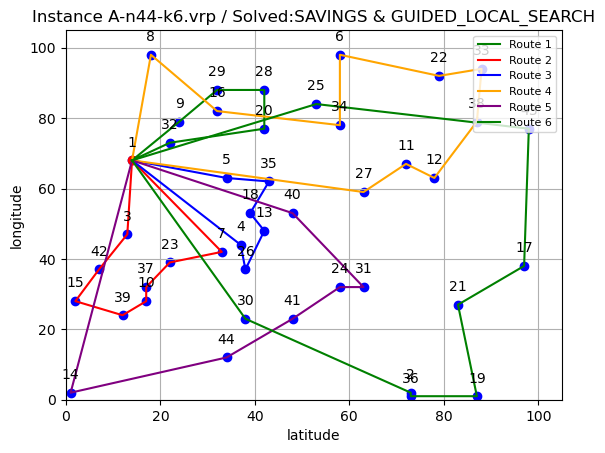

SOLVED INSTANCE: A-n44-k6.vrp
Soluzione ottima: 937
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 985
Gap: 5.122732123799359%
Tempo di esecuzione: 1.9999964237213135s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 985
Gap: 5.122732123799359%
Tempo di esecuzione: 1.999969482421875s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 961
Gap: 2.5613660618996796%
Tempo di esecuzione: 1.9999992847442627s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 971
Gap: 3.628601921024546%
Tempo di esecuzione: 1.9999768733978271s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 948
Gap: 1.1739594450373

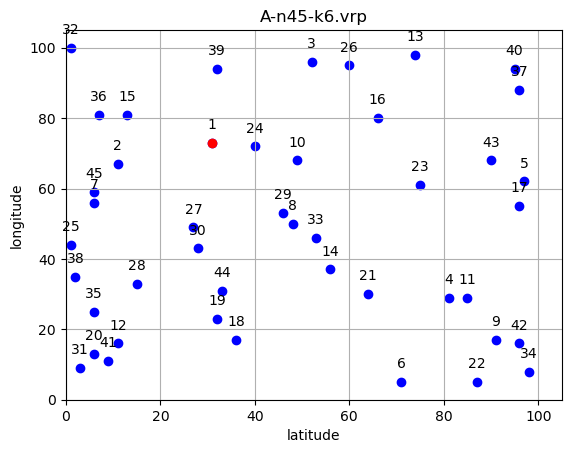

Soluzione ottima: 944
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 1087
Route for vehicle 1:
 1 Load(0) ->  35 Load(11) ->  6 Load(17) ->  22 Load(27) ->  34 Load(38) ->  42 Load(43) ->  9 Load(57) ->  11 Load(65) ->  33 Load(73) ->  29 Load(94) ->  24 Load(100) ->  0 Load(100)
Distance of the route: 250m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  15 Load(14) ->  32 Load(30) ->  36 Load(52) ->  2 Load(71) ->  45 Load(83) ->  7 Load(100) ->  0 Load(100)
Distance of the route: 119m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  39 Load(17) ->  3 Load(19) ->  26 Load(29) ->  13 Load(36) ->  16 Load(53) ->  43 Load(56) ->  5 Load(76) ->  23 Load(96) ->  10 Load(98) ->  0 Load(98)
Distance of the route: 187m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  25 Load(21) ->  38 Load(43) ->  20 Load(45) ->  31 Load(56) ->  41 Load(79) ->  12 Load(84) ->  28 Load(97) ->  0 Load(97)
Distance of the route: 149m
Load of t

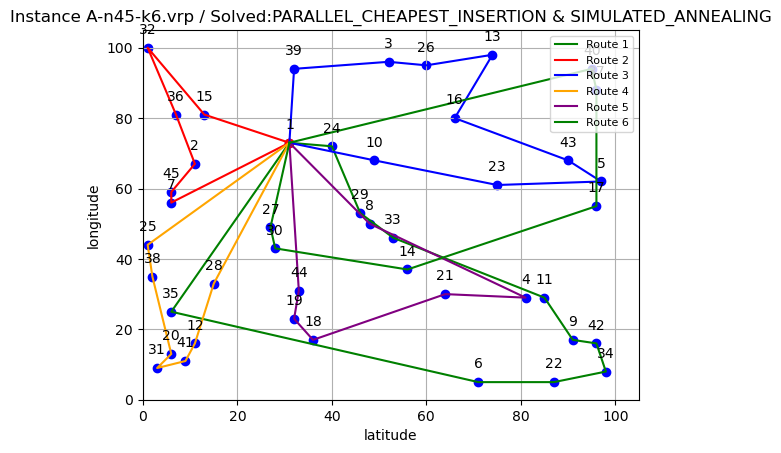

Local Search: TABU_SEARCH
Objective: 1087
Route for vehicle 1:
 1 Load(0) ->  35 Load(11) ->  6 Load(17) ->  22 Load(27) ->  34 Load(38) ->  42 Load(43) ->  9 Load(57) ->  11 Load(65) ->  33 Load(73) ->  29 Load(94) ->  24 Load(100) ->  0 Load(100)
Distance of the route: 250m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  15 Load(14) ->  32 Load(30) ->  36 Load(52) ->  2 Load(71) ->  45 Load(83) ->  7 Load(100) ->  0 Load(100)
Distance of the route: 119m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  39 Load(17) ->  3 Load(19) ->  26 Load(29) ->  13 Load(36) ->  16 Load(53) ->  43 Load(56) ->  5 Load(76) ->  23 Load(96) ->  10 Load(98) ->  0 Load(98)
Distance of the route: 187m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  25 Load(21) ->  38 Load(43) ->  20 Load(45) ->  31 Load(56) ->  41 Load(79) ->  12 Load(84) ->  28 Load(97) ->  0 Load(97)
Distance of the route: 149m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  44 Load(18) ->  19

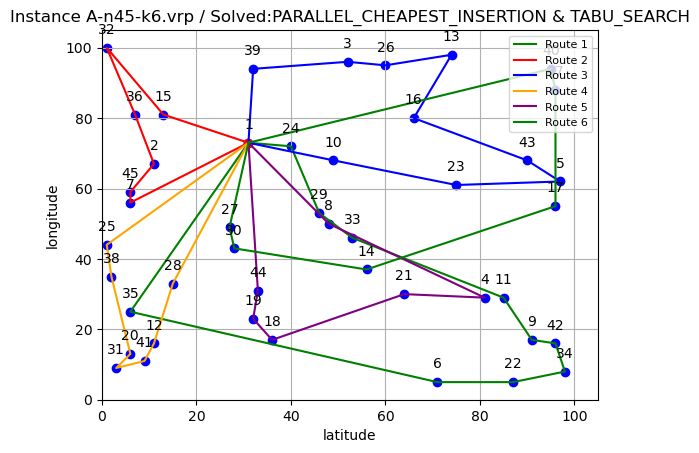

Local Search: GUIDED_LOCAL_SEARCH
Objective: 1087
Route for vehicle 1:
 1 Load(0) ->  35 Load(11) ->  6 Load(17) ->  22 Load(27) ->  34 Load(38) ->  42 Load(43) ->  9 Load(57) ->  11 Load(65) ->  33 Load(73) ->  29 Load(94) ->  24 Load(100) ->  0 Load(100)
Distance of the route: 250m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  15 Load(14) ->  32 Load(30) ->  36 Load(52) ->  2 Load(71) ->  45 Load(83) ->  7 Load(100) ->  0 Load(100)
Distance of the route: 119m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  39 Load(17) ->  3 Load(19) ->  26 Load(29) ->  13 Load(36) ->  16 Load(53) ->  43 Load(56) ->  5 Load(76) ->  23 Load(96) ->  10 Load(98) ->  0 Load(98)
Distance of the route: 187m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  25 Load(21) ->  38 Load(43) ->  20 Load(45) ->  31 Load(56) ->  41 Load(79) ->  12 Load(84) ->  28 Load(97) ->  0 Load(97)
Distance of the route: 149m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  44 Load(18

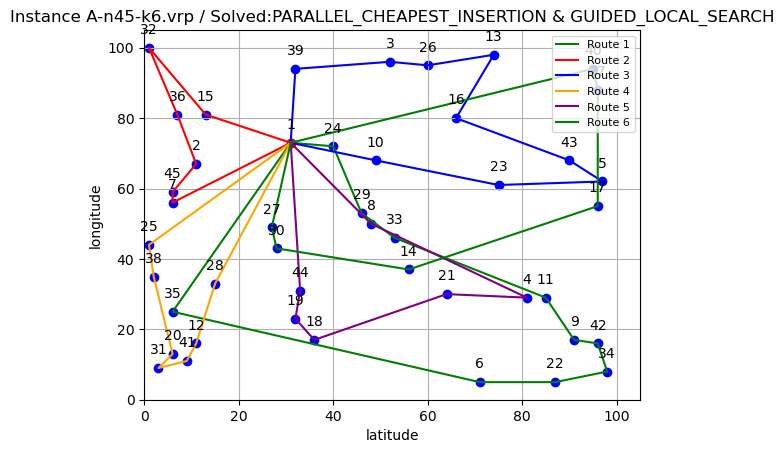

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 1087
Route for vehicle 1:
 1 Load(0) ->  35 Load(11) ->  6 Load(17) ->  22 Load(27) ->  34 Load(38) ->  42 Load(43) ->  9 Load(57) ->  11 Load(65) ->  33 Load(73) ->  29 Load(94) ->  24 Load(100) ->  0 Load(100)
Distance of the route: 250m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  15 Load(14) ->  32 Load(30) ->  36 Load(52) ->  2 Load(71) ->  45 Load(83) ->  7 Load(100) ->  0 Load(100)
Distance of the route: 119m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  39 Load(17) ->  3 Load(19) ->  26 Load(29) ->  13 Load(36) ->  16 Load(53) ->  43 Load(56) ->  5 Load(76) ->  23 Load(96) ->  10 Load(98) ->  0 Load(98)
Distance of the route: 187m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  25 Load(21) ->  38 Load(43) ->  20 Load(45) ->  31 Load(56) ->  41 Load(79) ->  12 Load(84) ->  28 Load(97) ->  0 Load(97)
Distance of the route: 149m
Load of the route: 97

Route for vehicle 5:
 1 Load

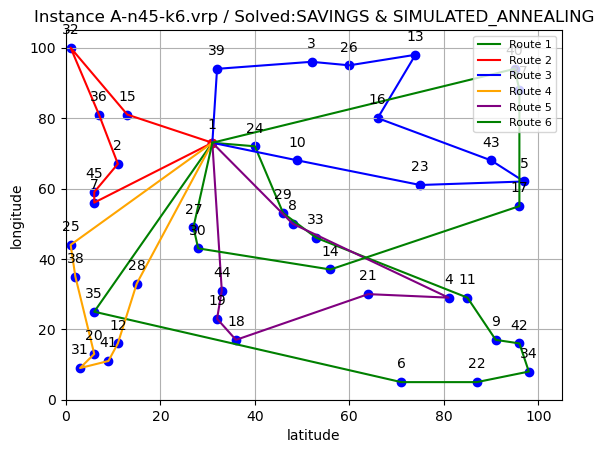

Local Search: TABU_SEARCH
Objective: 1087
Route for vehicle 1:
 1 Load(0) ->  35 Load(11) ->  6 Load(17) ->  22 Load(27) ->  34 Load(38) ->  42 Load(43) ->  9 Load(57) ->  11 Load(65) ->  33 Load(73) ->  29 Load(94) ->  24 Load(100) ->  0 Load(100)
Distance of the route: 250m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  15 Load(14) ->  32 Load(30) ->  36 Load(52) ->  2 Load(71) ->  45 Load(83) ->  7 Load(100) ->  0 Load(100)
Distance of the route: 119m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  39 Load(17) ->  3 Load(19) ->  26 Load(29) ->  13 Load(36) ->  16 Load(53) ->  43 Load(56) ->  5 Load(76) ->  23 Load(96) ->  10 Load(98) ->  0 Load(98)
Distance of the route: 187m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  25 Load(21) ->  38 Load(43) ->  20 Load(45) ->  31 Load(56) ->  41 Load(79) ->  12 Load(84) ->  28 Load(97) ->  0 Load(97)
Distance of the route: 149m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  44 Load(18) ->  19

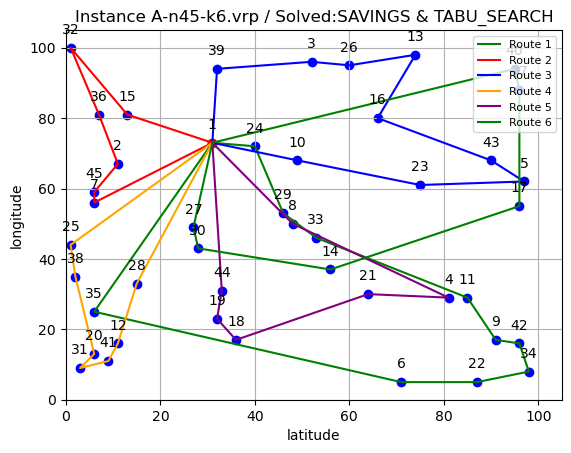

Local Search: GUIDED_LOCAL_SEARCH
Objective: 1087
Route for vehicle 1:
 1 Load(0) ->  35 Load(11) ->  6 Load(17) ->  22 Load(27) ->  34 Load(38) ->  42 Load(43) ->  9 Load(57) ->  11 Load(65) ->  33 Load(73) ->  29 Load(94) ->  24 Load(100) ->  0 Load(100)
Distance of the route: 250m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  15 Load(14) ->  32 Load(30) ->  36 Load(52) ->  2 Load(71) ->  45 Load(83) ->  7 Load(100) ->  0 Load(100)
Distance of the route: 119m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  39 Load(17) ->  3 Load(19) ->  26 Load(29) ->  13 Load(36) ->  16 Load(53) ->  43 Load(56) ->  5 Load(76) ->  23 Load(96) ->  10 Load(98) ->  0 Load(98)
Distance of the route: 187m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  25 Load(21) ->  38 Load(43) ->  20 Load(45) ->  31 Load(56) ->  41 Load(79) ->  12 Load(84) ->  28 Load(97) ->  0 Load(97)
Distance of the route: 149m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  44 Load(18

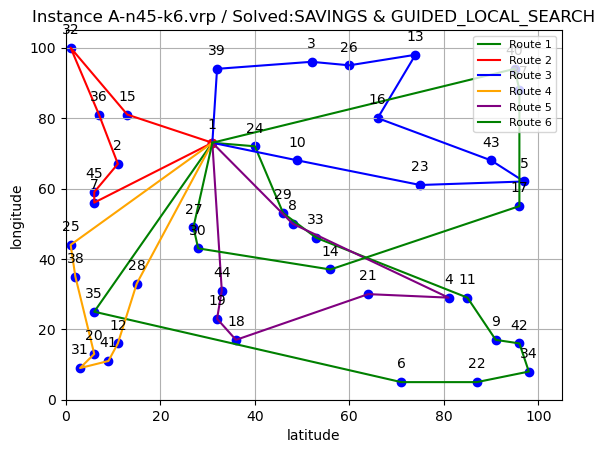

SOLVED INSTANCE: A-n45-k6.vrp
Soluzione ottima: 944
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 1087
Gap: 15.148305084745765%
Tempo di esecuzione: 1.9999873638153076s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 1087
Gap: 15.148305084745765%
Tempo di esecuzione: 1.9999985694885254s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 1087
Gap: 15.148305084745765%
Tempo di esecuzione: 2.001032829284668s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 1087
Gap: 15.148305084745765%
Tempo di esecuzione: 1.9999558925628662s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 1087
Gap: 15.1483

In [14]:
avg_gap= [] #Conterrà le medie dei gap calcolati per ogni algoritmo
avg_tempi = [] #Conterrà le medie dei tempi di calcolo
dim_p = [] #Conterrà le diverse dimensioni delle istanze risolte

tempi_tutti = []
gap_tutti = []

#Variabile per impostare il numero di file di istanze da leggere
#Max file = len(nomi_file)
num_file = 12
for i in range(num_file):
    print("Solving INSTANCE:",nomi_file[i])
    
    # RESET delle variabili
    capacity = None #Capacita dei veicoli
    node_coord_section = [] #Coordinate dei nodi
    demand_section = [] #Richieste dei nodi
    depot_section = [] #Sezione del deposito
    num_vehicl = 0 #Numero di veicoli
    
    #Leggo il file
    read_file(nomi_file[i])
    
    #Plotto l'istanza del problema
    instance_plot(nomi_file[i])
    
    #Salvo la dimensione del problema
    dim_p.append(num_vehicl)
    
    #Calcola la matrice delle distanze sulla base delle coordinate
    distance_matrix = create_distance_matrix(node_coord_section)

    total_distance= 0

    #Istanzio il problema nel dizionario
    data = create_data_model(distance_matrix, demand_section, capacity, num_vehicl)
    
    sol = []
    
    #debug
    #     for row in data['distance_matrix']:
    #         print(row)
    #     print("Demands:")
    #     print(data['demands'])
    #     print("Vehicle Capacities:")
    #     print(data['vehicle_capacities'])
    #     print("Number of Vehicles:")
    #     print(data['num_vehicles'])
    #     print("Depot:")
    #     print(data['depot'])

    #Creo gestore dell'indice
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                   data['num_vehicles'], data['depot'])

    #Crea modello di routing
    routing = pywrapcp.RoutingModel(manager)
    
    #Le precedenti
    #Sono funzioni necessarie per utilizzare le funzioni della libreria OR-tools 
    
    #Indice per richiamare la funzione di calcolo distanza
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    #Definisce i costi sugli archi 
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    #Indice per richiamare la funzione di domanda per i nodi
    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    
    #Aggiunge le dimensioni al problema, capacita massima, slack,domanda nodi
    routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    'Capacity')
    
    #Euristiche:
    FS = ["PARALLEL_CHEAPEST_INSERTION","SAVINGS"]
    #Metauiristiche
    LSM = ["SIMULATED_ANNEALING","TABU_SEARCH","GUIDED_LOCAL_SEARCH"]

    read_sol(nomi_sol[i])
    print("Soluzione ottima:",sol_opt)
    gap= []
    sol= []
    #Itero tra gli algoritmi di prima soluzione e applico una metauristica diversa per ognuno
    for x in range(len(FS)):
        print("SOLUTION:", FS[x])
        for y in range(len(LSM)):
            print("Local Search:", LSM[y])
            solve_routing_problem(nomi_file[i],FS[x],LSM[y])
            
            h = len(sol)
            tempi_tutti.append(sol[h-1][1])
            #print("Prova:",tempi_tutti)
            
    print("SOLVED INSTANCE:",nomi_file[i])        
    #Calcolo il gap dall'ottimo
    calc_gap(sol_opt)
    #print(gap)
    #CALCOLO il gap medio per ogni algoritmo e il tempo medio di esecuzione
    somma = 0
    somma_tempi = 0
    # Ciclo for da 0 a 2
    for z in range(3):
        gap_tutti.append(gap[z])
        somma += gap[z]
        somma_tempi += sol[z][1]
    avg=somma/3
    avg_t= somma_tempi / 3
    avg_gap.append(avg)
    avg_tempi.append(avg_t)
    somma=0
    somma_tempi = 0
    for z in range(3,6):
        gap_tutti.append(gap[z])
        somma += gap[z]
        somma_tempi += sol[z][1]
    avg=somma/3
    avg_t= somma_tempi / 3
    avg_gap.append(avg)
    avg_tempi.append(avg_t)
   # print(avg_gap)
    #print(avg_tempi)
    
    #print(gap_tutti)

    
    # #debug   
    # #print (sol)
    
    print("FINE ITER N:",i+1)

#print("Numero di veicoli:",dim_p)
    

In [15]:
#Debug
# print(len(tempi_tutti))
# print(len(gap_tutti))

# Plotting dei dati raccolti

In [16]:
#Lista di euristiche utilizzate (servono solo per il plot)
algorithms = ["PARALLEL_CHEAPEST_INSERTION", "SAVINGS"] * num_file
#print(algorithms)

#Lista di combinazioni euristica + metauristica utilizzate
combo = ["PAR_CHEAP + SIM_ANN.","PAR_CHEAP + TABU_SEARCH","PAR_CHEAP + GUID_LOC.", "SAVINGS+ SIM_ANN.","SAVINGS+ TABU_SEARCH.","SAVINGS+ GUID_LOC."]* num_file

#Costruzione del vettore di nomi da associare ad ogni combo
nomi_com = []
for i in range(num_file):
    for j in range(6):
        nomi_com.append(nomi_file[i])

#Debug
# print(len(combo))
# print(len(nomi_com))

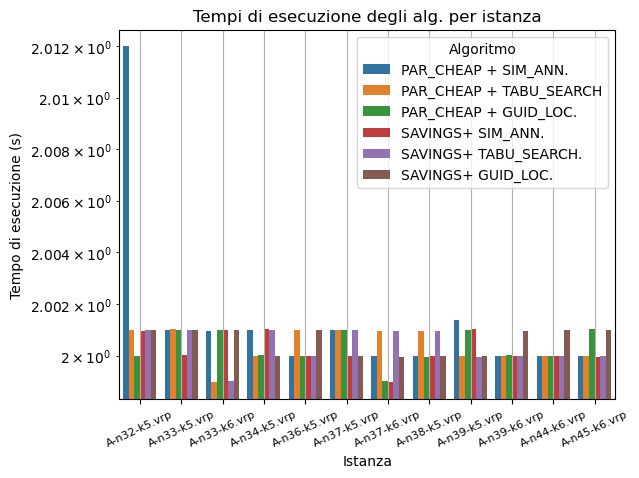

In [17]:
# # Creazione del DataFrame
data = pd.DataFrame({'Algoritmo': combo, 'Tempo di esecuzione': tempi_tutti, 'Istanza': nomi_com})

# Creazione del barplot con Seaborn
sns.barplot(x='Istanza', y='Tempo di esecuzione', data=data, hue='Algoritmo')
plt.title('Tempi di esecuzione degli alg. per istanza')
plt.xlabel('Istanza')
plt.ylabel('Tempo di esecuzione (s)')
plt.yscale('log')
plt.grid()

# Rimpicciolire i nomi
plt.xticks(rotation=25, fontsize=8)

# Mostra il grafico
plt.show()

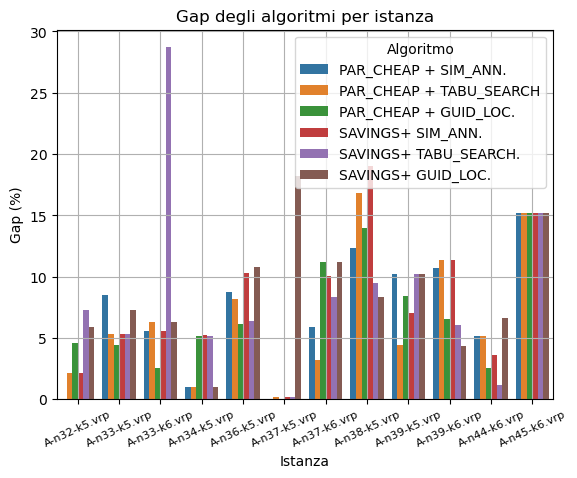

In [18]:
# # Creazione del DataFrame
data = pd.DataFrame({'Algoritmo': combo, 'Gap': gap_tutti, 'Istanza': nomi_com})

# Creazione del barplot con Seaborn
sns.barplot(x='Istanza', y='Gap', data=data, hue='Algoritmo')
plt.title('Gap degli algoritmi per istanza')
plt.xlabel('Istanza')
plt.ylabel('Gap (%)')
#plt.yscale('log')
plt.grid()
# Rimpicciolire i nomi degli algoritmi
plt.xticks(rotation=25, fontsize=8)

# Mostra il grafico
plt.show()

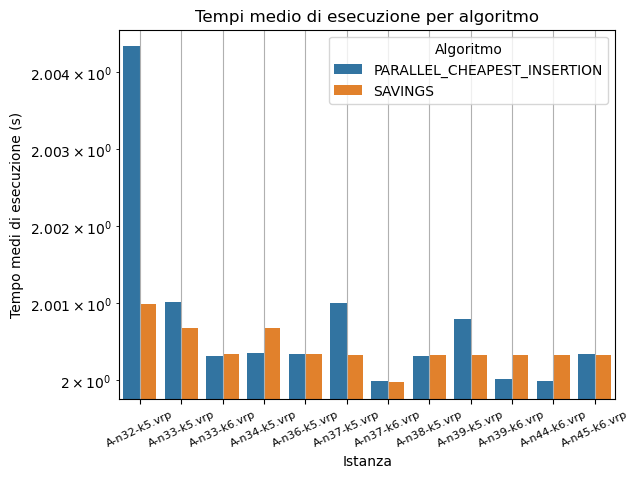

In [19]:
#Costruzione del vettore di nomi da associare ad ogni algoritmo
nuomi= []
for i in range(num_file):
    for j in range(2):
        nuomi.append(nomi_file[i])

        #debug        
#print(nuomi)
# print(len(algorithms))
# print(len(avg_tempi))
#print(len(nuomi))



# # Creazione del DataFrame
data = pd.DataFrame({'Algoritmo': algorithms, 'Tempo medio di esecuzione': avg_tempi, 'Istanza': nuomi})

# Creazione del barplot con Seaborn
sns.barplot(x='Istanza', y='Tempo medio di esecuzione', data=data, hue='Algoritmo')
plt.title('Tempi medio di esecuzione per algoritmo')
plt.xlabel('Istanza')
plt.ylabel('Tempo medi di esecuzione (s)')
plt.yscale('log')
plt.grid()
# Rimpicciolire i nomi degli algoritmi
plt.xticks(rotation=25, fontsize=8)

# Mostra il grafico
plt.show()

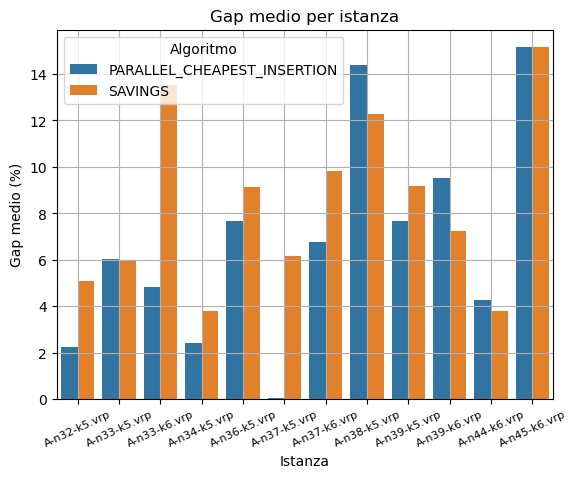

In [20]:
data = pd.DataFrame({'Algoritmo': algorithms, 'Gap Medio': avg_gap, 'Istanza': nuomi})

# Creazione del barplot con Seaborn
sns.barplot(x='Istanza', y='Gap Medio', data=data, hue='Algoritmo')
plt.title('Gap medio per istanza')
plt.xlabel('Istanza')
plt.ylabel('Gap medio (%)')
#plt.yscale('log')
plt.grid()
# Rimpicciolire i nomi degli algoritmi
plt.xticks(rotation=25, fontsize=8)

# Mostra il grafico
plt.show()

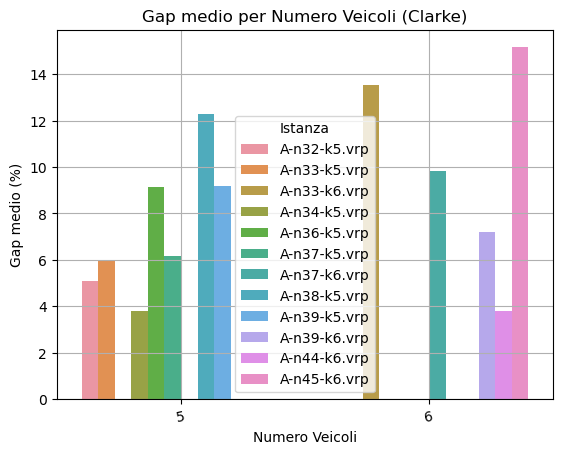

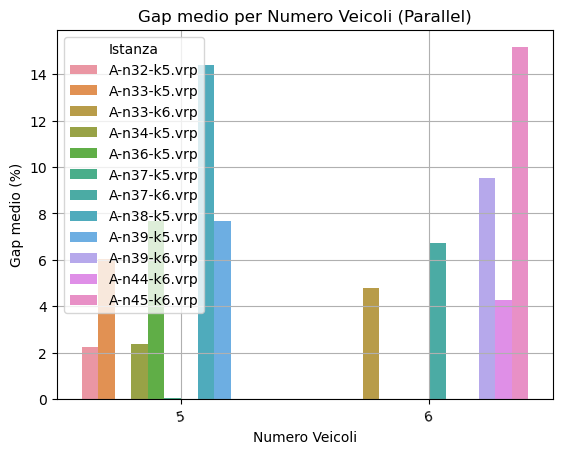

In [21]:
#Costruzione dei vett di medie da associare ad ogni istanza
gapS= []
gapP= []
for i in range(num_file * 2):
    #Se sta in posizione pari è l'avg dell'algoritmo parallel
    if i % 2 == 0:
        gapP.append(avg_gap[i])
    #Se sta in posizione dispari è l'avg dell'algoritmo di clarke
    else:
        gapS.append(avg_gap[i])
nomini= []
for i in range(num_file):
    nomini.append(nomi_file[i])

#Debug
# # print(avg_gap)
# # print(len(dimi))
# # print(len(avg_gap))
# # print(len(nuomi))
# print(gapS)
# print(dim_p)
# print(nomini)

data = pd.DataFrame({'Dim': dim_p, 'Gap Medio Clarke': gapS, 'Istanza': nomini,'Gap Medio Parallel': gapP,})

# Creazione del barplot con Seaborn
sns.barplot(x='Dim', y='Gap Medio Clarke', data=data, hue='Istanza')
plt.title('Gap medio per Numero Veicoli (Clarke)')
plt.xlabel('Numero Veicoli')
plt.ylabel('Gap medio (%)')
#plt.yscale('log')
plt.grid()
# Rimpicciolire i nomi degli algoritmi
plt.xticks(rotation=10, fontsize=10)

# Mostra il grafico
plt.show()


# Creazione del barplot con Seaborn
sns.barplot(x='Dim', y='Gap Medio Parallel', data=data, hue='Istanza')
plt.title('Gap medio per Numero Veicoli (Parallel)')
plt.xlabel('Numero Veicoli')
plt.ylabel('Gap medio (%)')
#plt.yscale('log')
plt.grid()
# Rimpicciolire i nomi degli algoritmi
plt.xticks(rotation=10, fontsize=10)

# Mostra il grafico
plt.show()


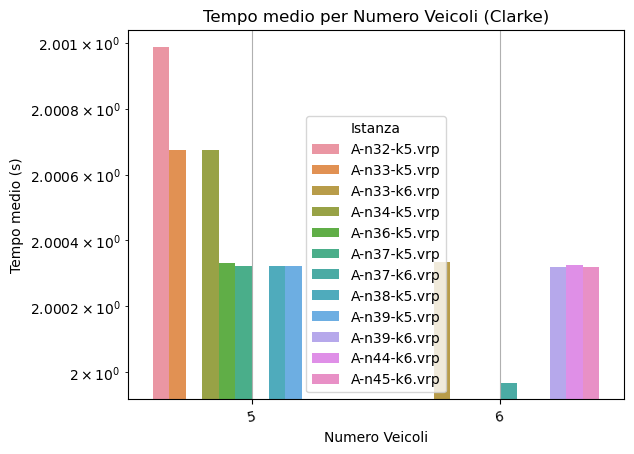

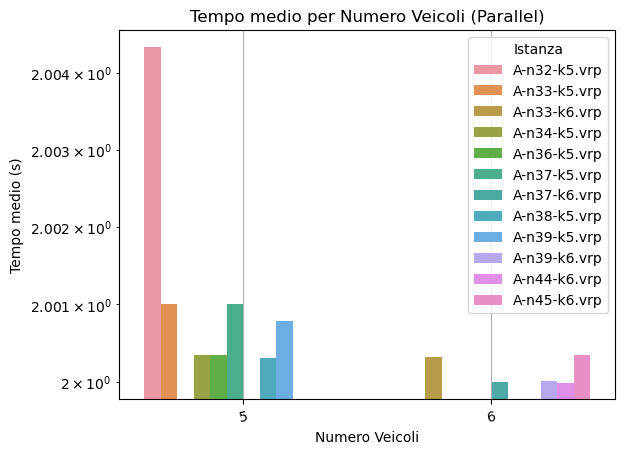

In [22]:
#Costruzione dei vett di medie da associare ad ogni istanza
avgS= []
avgP= []
for i in range(num_file * 2):
    #Se sta in posizione pari è l'avg dell'algoritmo parallel
    if i % 2 == 0:
        avgP.append(avg_tempi[i])
    #Se sta in posizione dispari è l'avg dell'algoritmo di clarke
    else:
        avgS.append(avg_tempi[i])

# print(len(avgS))
# print(len(dim_p))
# print(len(nomini))

data = pd.DataFrame({'Dim': dim_p, 'Tempo Medio Clarke': avgS, 'Istanza': nomini,'Tempo Medio Parallel': avgP,})

# Creazione del barplot con Seaborn
sns.barplot(x='Dim', y='Tempo Medio Clarke', data=data, hue='Istanza')
plt.title('Tempo medio per Numero Veicoli (Clarke)')
plt.xlabel('Numero Veicoli')
plt.ylabel('Tempo medio (s)')
plt.yscale('log')
plt.grid()
# Rimpicciolire i nomi degli algoritmi
plt.xticks(rotation=10, fontsize=10)

# Mostra il grafico
plt.show()


# Creazione del barplot con Seaborn
sns.barplot(x='Dim', y='Tempo Medio Parallel', data=data, hue='Istanza')
plt.title('Tempo medio per Numero Veicoli (Parallel)')
plt.xlabel('Numero Veicoli')
plt.ylabel('Tempo medio (s)')
plt.yscale('log')
plt.grid()
# Rimpicciolire i nomi degli algoritmi
plt.xticks(rotation=10, fontsize=10)

# Mostra il grafico
plt.show()
